In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
cm_target[0]

'NACA0018cm_blade1.csv'

In [11]:
str(cm_target[0])

'NACA0018cm_blade1.csv'

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    #total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    file = cm_target
    df = pd.DataFrame()

    data = pd.read_csv(file, header=None)
    df = pd.concat([df, data], axis=0)

    time = df.iloc[:,0].values
    cm = df.iloc[:,1].values

    time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
    cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]

    # Handle the time that is duplicated because of digits
    # Also, outliers are regulated at the second conditional statement.
    time_beUsed = handler_time(time_beUsed)
    cm_beUsed = handler_cm(cm_beUsed)

    linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                       bounds_error=False,kind='quadratic',
                                       fill_value='extrapolate')
    time_interp = np.arange(10, 15, t_interval).reshape((-1,1))

    cm_interp=linear_func(time_interp).reshape((-1,1))

    cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and $C_m$: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>10:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target[0], n_beta, t_len, normalize=True)

Dimension - time and $C_m$:  (5000, 2)
Dimension - x:  (5000, 1)
Dimension - y:  (5000, 1)


In [21]:
x -=10

In [22]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [23]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=100)

In [24]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [25]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20221226_noflap_randomState100"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20221226unsteadyPrediction_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState100_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 3s - loss: 0.2467 - rmse: 0.4966
Epoch 1: val_loss improved from inf to 0.15463, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 2s 110ms/step - loss: 0.2109 - rmse: 0.4591 - val_loss: 0.1546 - val_rmse: 0.3931 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1349 - rmse: 0.3671
Epoch 2: val_loss improved from 0.15463 to 0.11616, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.1384 - rmse: 0.3718 - val_loss: 0.1162 - val_rmse: 0.3407 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1282 - rmse: 0.3579
Epoch 3: val_loss improved from 0.11616 

Epoch 21/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0823 - rmse: 0.2867
Epoch 21: val_loss improved from 0.07483 to 0.07346, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0790 - rmse: 0.2810 - val_loss: 0.0735 - val_rmse: 0.2709 - lr: 1.0000e-04
Epoch 22/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0738 - rmse: 0.2714
Epoch 22: val_loss improved from 0.07346 to 0.07205, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0735 - rmse: 0.2709 - val_loss: 0.0721 - val_rmse: 0.2682 - lr: 1.0000e-04
Epoch 23/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0796 - rmse: 0.2819
Epoch 23: val_loss improved from

3/3 [==============================] - 0s 49ms/step - loss: 0.0646 - rmse: 0.2540 - val_loss: 0.0620 - val_rmse: 0.2488 - lr: 1.0000e-04
Epoch 42/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0770 - rmse: 0.2774
Epoch 42: val_loss did not improve from 0.06199
3/3 [==============================] - 0s 22ms/step - loss: 0.0676 - rmse: 0.2599 - val_loss: 0.0623 - val_rmse: 0.2495 - lr: 1.0000e-04
Epoch 43/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0652 - rmse: 0.2552
Epoch 43: val_loss did not improve from 0.06199
3/3 [==============================] - 0s 21ms/step - loss: 0.0678 - rmse: 0.2601 - val_loss: 0.0620 - val_rmse: 0.2488 - lr: 1.0000e-04
Epoch 44/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0686 - rmse: 0.2617
Epoch 44: val_loss improved from 0.06199 to 0.06198, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [===

Epoch 63/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0670 - rmse: 0.2586
Epoch 63: val_loss improved from 0.06142 to 0.06138, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0660 - rmse: 0.2568 - val_loss: 0.0614 - val_rmse: 0.2476 - lr: 1.0000e-04
Epoch 64/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0659 - rmse: 0.2566
Epoch 64: val_loss improved from 0.06138 to 0.06132, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0642 - rmse: 0.2532 - val_loss: 0.0613 - val_rmse: 0.2474 - lr: 1.0000e-04
Epoch 65/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0682 - rmse: 0.2610
Epoch 65: val_loss did not impro

3/3 [==============================] - 0s 52ms/step - loss: 0.0634 - rmse: 0.2516 - val_loss: 0.0606 - val_rmse: 0.2460 - lr: 1.0000e-04
Epoch 86/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0697 - rmse: 0.2639
Epoch 86: val_loss improved from 0.06062 to 0.06055, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0643 - rmse: 0.2533 - val_loss: 0.0605 - val_rmse: 0.2459 - lr: 1.0000e-04
Epoch 87/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0640 - rmse: 0.2528
Epoch 87: val_loss did not improve from 0.06055
3/3 [==============================] - 0s 21ms/step - loss: 0.0652 - rmse: 0.2551 - val_loss: 0.0607 - val_rmse: 0.2461 - lr: 1.0000e-04
Epoch 88/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0691 - rmse: 0.2626
Epoch 88: val_loss improved from 0.06055 to 0.06047, sav

3/3 [==============================] - 0s 52ms/step - loss: 0.0627 - rmse: 0.2502 - val_loss: 0.0598 - val_rmse: 0.2443 - lr: 1.0000e-04
Epoch 107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0653 - rmse: 0.2553
Epoch 107: val_loss improved from 0.05977 to 0.05975, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0664 - rmse: 0.2574 - val_loss: 0.0597 - val_rmse: 0.2442 - lr: 1.0000e-04
Epoch 108/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0584 - rmse: 0.2415
Epoch 108: val_loss improved from 0.05975 to 0.05965, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0604 - rmse: 0.2455 - val_loss: 0.0597 - val_rmse: 0.2440 

Epoch 128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0630 - rmse: 0.2509
Epoch 128: val_loss improved from 0.05875 to 0.05861, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0623 - rmse: 0.2493 - val_loss: 0.0586 - val_rmse: 0.2419 - lr: 1.0000e-04
Epoch 129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0724 - rmse: 0.2689
Epoch 129: val_loss improved from 0.05861 to 0.05857, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0618 - rmse: 0.2485 - val_loss: 0.0586 - val_rmse: 0.2418 - lr: 1.0000e-04
Epoch 130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0603 - rmse: 0.2453
Epoch 130: val_loss improve

3/3 [==============================] - 0s 21ms/step - loss: 0.0599 - rmse: 0.2445 - val_loss: 0.0580 - val_rmse: 0.2406 - lr: 1.0000e-04
Epoch 151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0608 - rmse: 0.2464
Epoch 151: val_loss did not improve from 0.05779
3/3 [==============================] - 0s 21ms/step - loss: 0.0600 - rmse: 0.2447 - val_loss: 0.0578 - val_rmse: 0.2402 - lr: 1.0000e-04
Epoch 152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0599 - rmse: 0.2446
Epoch 152: val_loss improved from 0.05779 to 0.05773, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0608 - rmse: 0.2465 - val_loss: 0.0577 - val_rmse: 0.2401 - lr: 1.0000e-04
Epoch 153/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0614 - rmse: 0.2475
Epoch 153: val_loss did not improve from 0.05773
3/

3/3 [==============================] - 0s 56ms/step - loss: 0.0587 - rmse: 0.2421 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0585 - rmse: 0.2416
Epoch 172: val_loss improved from 0.05678 to 0.05675, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0582 - rmse: 0.2410 - val_loss: 0.0567 - val_rmse: 0.2380 - lr: 1.0000e-04
Epoch 173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2373
Epoch 173: val_loss improved from 0.05675 to 0.05668, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 0.0584 - rmse: 0.2415 - val_loss: 0.0567 - val_rmse: 0.2379 

1/3 [=========>....................] - ETA: 0s - loss: 0.0571 - rmse: 0.2388
Epoch 192: val_loss did not improve from 0.05584
3/3 [==============================] - 0s 21ms/step - loss: 0.0586 - rmse: 0.2418 - val_loss: 0.0559 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0567 - rmse: 0.2378
Epoch 193: val_loss improved from 0.05584 to 0.05579, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0584 - rmse: 0.2414 - val_loss: 0.0558 - val_rmse: 0.2360 - lr: 1.0000e-04
Epoch 194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0539 - rmse: 0.2319
Epoch 194: val_loss improved from 0.05579 to 0.05567, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoi

3/3 [==============================] - 0s 45ms/step - loss: 0.0576 - rmse: 0.2398 - val_loss: 0.0547 - val_rmse: 0.2336 - lr: 1.0000e-04
Epoch 215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2342
Epoch 215: val_loss did not improve from 0.05468
3/3 [==============================] - 0s 21ms/step - loss: 0.0536 - rmse: 0.2313 - val_loss: 0.0548 - val_rmse: 0.2339 - lr: 1.0000e-04
Epoch 216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0552 - rmse: 0.2347
Epoch 216: val_loss did not improve from 0.05468
3/3 [==============================] - 0s 21ms/step - loss: 0.0578 - rmse: 0.2402 - val_loss: 0.0551 - val_rmse: 0.2345 - lr: 1.0000e-04
Epoch 217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0624 - rmse: 0.2497
Epoch 217: val_loss improved from 0.05468 to 0.05462, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/

Epoch 237/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0534 - rmse: 0.2308
Epoch 237: val_loss did not improve from 0.05374
3/3 [==============================] - 0s 21ms/step - loss: 0.0547 - rmse: 0.2337 - val_loss: 0.0538 - val_rmse: 0.2318 - lr: 1.0000e-04
Epoch 238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0600 - rmse: 0.2448
Epoch 238: val_loss improved from 0.05374 to 0.05373, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0569 - rmse: 0.2384 - val_loss: 0.0537 - val_rmse: 0.2316 - lr: 1.0000e-04
Epoch 239/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 239: val_loss did not improve from 0.05373
3/3 [==============================] - 0s 21ms/step - loss: 0.0552 - rmse: 0.2348 - val_loss: 0.0538 - val_rmse: 0.2317 - lr: 1.0000e-04
Ep

3/3 [==============================] - 0s 51ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0529 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoch 261/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0570 - rmse: 0.2385
Epoch 261: val_loss did not improve from 0.05293
3/3 [==============================] - 0s 21ms/step - loss: 0.0552 - rmse: 0.2348 - val_loss: 0.0530 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoch 262/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0508 - rmse: 0.2252
Epoch 262: val_loss improved from 0.05293 to 0.05292, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 62ms/step - loss: 0.0536 - rmse: 0.2313 - val_loss: 0.0529 - val_rmse: 0.2298 - lr: 1.0000e-04
Epoch 263/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0572 - rmse: 0.2389
Epoch 263: val_loss did not improve from 0.05292
3/

3/3 [==============================] - 0s 50ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 285/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0555 - rmse: 0.2353
Epoch 285: val_loss improved from 0.05238 to 0.05229, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0542 - rmse: 0.2326 - val_loss: 0.0523 - val_rmse: 0.2284 - lr: 1.0000e-04
Epoch 286/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2300
Epoch 286: val_loss did not improve from 0.05229
3/3 [==============================] - 0s 21ms/step - loss: 0.0529 - rmse: 0.2297 - val_loss: 0.0524 - val_rmse: 0.2287 - lr: 1.0000e-04
Epoch 287/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2336
Epoch 287: val_loss did not improve from 0.05229
3/

1/3 [=========>....................] - ETA: 0s - loss: 0.0537 - rmse: 0.2316
Epoch 309: val_loss did not improve from 0.05194
3/3 [==============================] - 0s 21ms/step - loss: 0.0527 - rmse: 0.2294 - val_loss: 0.0521 - val_rmse: 0.2281 - lr: 1.0000e-04
Epoch 310/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0605 - rmse: 0.2458
Epoch 310: val_loss improved from 0.05194 to 0.05184, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0548 - rmse: 0.2339 - val_loss: 0.0518 - val_rmse: 0.2275 - lr: 1.0000e-04
Epoch 311/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0560 - rmse: 0.2364
Epoch 311: val_loss improved from 0.05184 to 0.05182, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoi

Epoch 333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0542 - rmse: 0.2326
Epoch 333: val_loss improved from 0.05153 to 0.05152, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 53ms/step - loss: 0.0547 - rmse: 0.2336 - val_loss: 0.0515 - val_rmse: 0.2268 - lr: 1.0000e-04
Epoch 334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0446 - rmse: 0.2110
Epoch 334: val_loss improved from 0.05152 to 0.05151, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0516 - rmse: 0.2270 - val_loss: 0.0515 - val_rmse: 0.2267 - lr: 1.0000e-04
Epoch 335/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2276
Epoch 335: val_loss did not

Epoch 358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0494 - rmse: 0.2220
Epoch 358: val_loss did not improve from 0.05129
3/3 [==============================] - 0s 21ms/step - loss: 0.0518 - rmse: 0.2275 - val_loss: 0.0515 - val_rmse: 0.2267 - lr: 1.0000e-04
Epoch 359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0569 - rmse: 0.2384
Epoch 359: val_loss did not improve from 0.05129
3/3 [==============================] - 0s 20ms/step - loss: 0.0546 - rmse: 0.2334 - val_loss: 0.0520 - val_rmse: 0.2279 - lr: 1.0000e-04
Epoch 360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0547 - rmse: 0.2336
Epoch 360: val_loss did not improve from 0.05129
3/3 [==============================] - 0s 21ms/step - loss: 0.0523 - rmse: 0.2286 - val_loss: 0.0528 - val_rmse: 0.2296 - lr: 1.0000e-04
Epoch 361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0580 - rmse: 0.2407
Epoch 361: val_loss did not improve from 0.05129
3/3 [================

3/3 [==============================] - 0s 52ms/step - loss: 0.0533 - rmse: 0.2307 - val_loss: 0.0512 - val_rmse: 0.2261 - lr: 1.0000e-04
Epoch 386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2226
Epoch 386: val_loss improved from 0.05122 to 0.05118, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 64ms/step - loss: 0.0529 - rmse: 0.2298 - val_loss: 0.0512 - val_rmse: 0.2260 - lr: 1.0000e-04
Epoch 387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2225
Epoch 387: val_loss did not improve from 0.05118
3/3 [==============================] - 0s 22ms/step - loss: 0.0530 - rmse: 0.2301 - val_loss: 0.0517 - val_rmse: 0.2271 - lr: 1.0000e-04
Epoch 388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0526 - rmse: 0.2291
Epoch 388: val_loss did not improve from 0.05118
3/

3/3 [==============================] - 0s 53ms/step - loss: 0.0519 - rmse: 0.2275 - val_loss: 0.0510 - val_rmse: 0.2256 - lr: 1.0000e-04
Epoch 412/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0523 - rmse: 0.2286
Epoch 412: val_loss improved from 0.05100 to 0.05098, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0523 - rmse: 0.2284 - val_loss: 0.0510 - val_rmse: 0.2256 - lr: 1.0000e-04
Epoch 413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2312
Epoch 413: val_loss improved from 0.05098 to 0.05095, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0534 - rmse: 0.2309 - val_loss: 0.0510 - val_rmse: 0.2255 

3/3 [==============================] - 0s 22ms/step - loss: 0.0514 - rmse: 0.2265 - val_loss: 0.0508 - val_rmse: 0.2253 - lr: 1.0000e-04
Epoch 438/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0581 - rmse: 0.2408
Epoch 438: val_loss did not improve from 0.05075
3/3 [==============================] - 0s 21ms/step - loss: 0.0531 - rmse: 0.2302 - val_loss: 0.0509 - val_rmse: 0.2254 - lr: 1.0000e-04
Epoch 439/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2341
Epoch 439: val_loss improved from 0.05075 to 0.05066, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0527 - rmse: 0.2294 - val_loss: 0.0507 - val_rmse: 0.2249 - lr: 1.0000e-04
Epoch 440/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0511 - rmse: 0.2258
Epoch 440: val_loss improved from 0.05066 to 0.0506

Epoch 462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0478 - rmse: 0.2184
Epoch 462: val_loss did not improve from 0.05039
3/3 [==============================] - 0s 21ms/step - loss: 0.0524 - rmse: 0.2287 - val_loss: 0.0506 - val_rmse: 0.2247 - lr: 1.0000e-04
Epoch 463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2188
Epoch 463: val_loss improved from 0.05039 to 0.05038, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 91ms/step - loss: 0.0525 - rmse: 0.2288 - val_loss: 0.0504 - val_rmse: 0.2243 - lr: 1.0000e-04
Epoch 464/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2181
Epoch 464: val_loss did not improve from 0.05038
3/3 [==============================] - 0s 21ms/step - loss: 0.0499 - rmse: 0.2232 - val_loss: 0.0504 - val_rmse: 0.2243 - lr: 1.0000e-04
Ep

Epoch 487/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0530 - rmse: 0.2300
Epoch 487: val_loss did not improve from 0.05002
3/3 [==============================] - 0s 21ms/step - loss: 0.0540 - rmse: 0.2322 - val_loss: 0.0500 - val_rmse: 0.2234 - lr: 1.0000e-04
Epoch 488/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0486 - rmse: 0.2203
Epoch 488: val_loss did not improve from 0.05002
3/3 [==============================] - 0s 22ms/step - loss: 0.0508 - rmse: 0.2252 - val_loss: 0.0501 - val_rmse: 0.2237 - lr: 1.0000e-04
Epoch 489/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0545 - rmse: 0.2332
Epoch 489: val_loss did not improve from 0.05002
3/3 [==============================] - 0s 21ms/step - loss: 0.0517 - rmse: 0.2271 - val_loss: 0.0501 - val_rmse: 0.2235 - lr: 1.0000e-04
Epoch 490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0503 - rmse: 0.2241
Epoch 490: val_loss did not improve from 0.05002
3/3 [================

3/3 [==============================] - 0s 47ms/step - loss: 0.0506 - rmse: 0.2248 - val_loss: 0.0496 - val_rmse: 0.2225 - lr: 1.0000e-04
Epoch 514/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0535 - rmse: 0.2310
Epoch 514: val_loss did not improve from 0.04960
3/3 [==============================] - 0s 22ms/step - loss: 0.0518 - rmse: 0.2275 - val_loss: 0.0497 - val_rmse: 0.2226 - lr: 1.0000e-04
Epoch 515/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0514 - rmse: 0.2265
Epoch 515: val_loss improved from 0.04960 to 0.04960, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0496 - rmse: 0.2225 - val_loss: 0.0496 - val_rmse: 0.2225 - lr: 1.0000e-04
Epoch 516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0500 - rmse: 0.2234
Epoch 516: val_loss did not improve from 0.04960
3/

3/3 [==============================] - 0s 57ms/step - loss: 0.0489 - rmse: 0.2210 - val_loss: 0.0491 - val_rmse: 0.2215 - lr: 1.0000e-04
Epoch 536/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0499 - rmse: 0.2231
Epoch 536: val_loss did not improve from 0.04914
3/3 [==============================] - 0s 22ms/step - loss: 0.0503 - rmse: 0.2240 - val_loss: 0.0492 - val_rmse: 0.2215 - lr: 1.0000e-04
Epoch 537/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0517 - rmse: 0.2271
Epoch 537: val_loss did not improve from 0.04914
3/3 [==============================] - 0s 21ms/step - loss: 0.0508 - rmse: 0.2252 - val_loss: 0.0492 - val_rmse: 0.2216 - lr: 1.0000e-04
Epoch 538/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2200
Epoch 538: val_loss improved from 0.04914 to 0.04907, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/

Epoch 560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2191
Epoch 560: val_loss did not improve from 0.04876
3/3 [==============================] - 0s 21ms/step - loss: 0.0497 - rmse: 0.2226 - val_loss: 0.0488 - val_rmse: 0.2207 - lr: 1.0000e-04
Epoch 561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0485 - rmse: 0.2201
Epoch 561: val_loss improved from 0.04876 to 0.04874, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0498 - rmse: 0.2230 - val_loss: 0.0487 - val_rmse: 0.2206 - lr: 1.0000e-04
Epoch 562/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0532 - rmse: 0.2305
Epoch 562: val_loss improved from 0.04874 to 0.04873, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomS

1/3 [=========>....................] - ETA: 0s - loss: 0.0519 - rmse: 0.2275
Epoch 584: val_loss improved from 0.04827 to 0.04824, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0482 - val_rmse: 0.2194 - lr: 1.0000e-04
Epoch 585/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0515 - rmse: 0.2267
Epoch 585: val_loss did not improve from 0.04824
3/3 [==============================] - 0s 22ms/step - loss: 0.0488 - rmse: 0.2207 - val_loss: 0.0483 - val_rmse: 0.2197 - lr: 1.0000e-04
Epoch 586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0537 - rmse: 0.2315
Epoch 586: val_loss did not improve from 0.04824
3/3 [==============================] - 0s 22ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0485 - val_rmse: 0.2200 - lr: 1.0000e-04
Epoch 587/10000
1/

3/3 [==============================] - 0s 46ms/step - loss: 0.0473 - rmse: 0.2174 - val_loss: 0.0478 - val_rmse: 0.2185 - lr: 1.0000e-04
Epoch 611/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0534 - rmse: 0.2309
Epoch 611: val_loss did not improve from 0.04781
3/3 [==============================] - 0s 22ms/step - loss: 0.0501 - rmse: 0.2236 - val_loss: 0.0479 - val_rmse: 0.2188 - lr: 1.0000e-04
Epoch 612/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0495 - rmse: 0.2222
Epoch 612: val_loss improved from 0.04781 to 0.04769, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0505 - rmse: 0.2246 - val_loss: 0.0477 - val_rmse: 0.2182 - lr: 1.0000e-04
Epoch 613/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0520 - rmse: 0.2279
Epoch 613: val_loss did not improve from 0.04769
3/

3/3 [==============================] - 0s 50ms/step - loss: 0.0488 - rmse: 0.2208 - val_loss: 0.0474 - val_rmse: 0.2175 - lr: 1.0000e-04
Epoch 637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0457 - rmse: 0.2135
Epoch 637: val_loss improved from 0.04738 to 0.04728, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0486 - rmse: 0.2203 - val_loss: 0.0473 - val_rmse: 0.2172 - lr: 1.0000e-04
Epoch 638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0482 - rmse: 0.2194
Epoch 638: val_loss did not improve from 0.04728
3/3 [==============================] - 0s 22ms/step - loss: 0.0495 - rmse: 0.2223 - val_loss: 0.0473 - val_rmse: 0.2173 - lr: 1.0000e-04
Epoch 639/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0426 - rmse: 0.2062
Epoch 639: val_loss did not improve from 0.04728
3/

Epoch 663/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0480 - rmse: 0.2189
Epoch 663: val_loss improved from 0.04679 to 0.04668, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0488 - rmse: 0.2206 - val_loss: 0.0467 - val_rmse: 0.2159 - lr: 1.0000e-04
Epoch 664/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0461 - rmse: 0.2146
Epoch 664: val_loss did not improve from 0.04668
3/3 [==============================] - 0s 21ms/step - loss: 0.0483 - rmse: 0.2196 - val_loss: 0.0468 - val_rmse: 0.2161 - lr: 1.0000e-04
Epoch 665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0467 - rmse: 0.2159
Epoch 665: val_loss improved from 0.04668 to 0.04665, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomS

1/3 [=========>....................] - ETA: 0s - loss: 0.0478 - rmse: 0.2185
Epoch 688: val_loss improved from 0.04616 to 0.04613, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0470 - rmse: 0.2166 - val_loss: 0.0461 - val_rmse: 0.2146 - lr: 1.0000e-04
Epoch 689/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2180
Epoch 689: val_loss did not improve from 0.04613
3/3 [==============================] - 0s 22ms/step - loss: 0.0479 - rmse: 0.2187 - val_loss: 0.0465 - val_rmse: 0.2155 - lr: 1.0000e-04
Epoch 690/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0476 - rmse: 0.2181
Epoch 690: val_loss did not improve from 0.04613
3/3 [==============================] - 0s 22ms/step - loss: 0.0494 - rmse: 0.2221 - val_loss: 0.0464 - val_rmse: 0.2153 - lr: 1.0000e-04
Epoch 691/10000
1/

Epoch 714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0483 - rmse: 0.2197
Epoch 714: val_loss did not improve from 0.04564
3/3 [==============================] - 0s 24ms/step - loss: 0.0477 - rmse: 0.2182 - val_loss: 0.0457 - val_rmse: 0.2137 - lr: 1.0000e-04
Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0482 - rmse: 0.2193
Epoch 715: val_loss did not improve from 0.04564
3/3 [==============================] - 0s 21ms/step - loss: 0.0466 - rmse: 0.2157 - val_loss: 0.0459 - val_rmse: 0.2140 - lr: 1.0000e-04
Epoch 716/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0481 - rmse: 0.2191
Epoch 716: val_loss improved from 0.04564 to 0.04553, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0466 - rmse: 0.2157 - val_loss: 0.0455 - val_rmse: 0.2132 - lr: 1.0000e-04
Ep

1/3 [=========>....................] - ETA: 0s - loss: 0.0424 - rmse: 0.2057
Epoch 739: val_loss did not improve from 0.04504
3/3 [==============================] - 0s 22ms/step - loss: 0.0454 - rmse: 0.2129 - val_loss: 0.0454 - val_rmse: 0.2129 - lr: 1.0000e-04
Epoch 740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0473 - rmse: 0.2174
Epoch 740: val_loss did not improve from 0.04504
3/3 [==============================] - 0s 21ms/step - loss: 0.0463 - rmse: 0.2151 - val_loss: 0.0454 - val_rmse: 0.2129 - lr: 1.0000e-04
Epoch 741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0455 - rmse: 0.2131
Epoch 741: val_loss did not improve from 0.04504
3/3 [==============================] - 0s 21ms/step - loss: 0.0457 - rmse: 0.2136 - val_loss: 0.0451 - val_rmse: 0.2121 - lr: 1.0000e-04
Epoch 742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0527 - rmse: 0.2293
Epoch 742: val_loss improved from 0.04504 to 0.04490, saving model to D:\TrainedModels

Epoch 764/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0465 - rmse: 0.2154
Epoch 764: val_loss did not improve from 0.04420
3/3 [==============================] - 0s 22ms/step - loss: 0.0436 - rmse: 0.2085 - val_loss: 0.0444 - val_rmse: 0.2106 - lr: 1.0000e-04
Epoch 765/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0429 - rmse: 0.2070
Epoch 765: val_loss did not improve from 0.04420
3/3 [==============================] - 0s 21ms/step - loss: 0.0460 - rmse: 0.2143 - val_loss: 0.0442 - val_rmse: 0.2101 - lr: 1.0000e-04
Epoch 766/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0422 - rmse: 0.2052
Epoch 766: val_loss improved from 0.04420 to 0.04402, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 0.0442 - rmse: 0.2100 - val_loss: 0.0440 - val_rmse: 0.2096 - lr: 1.0000e-04
Ep

1/3 [=========>....................] - ETA: 0s - loss: 0.0412 - rmse: 0.2027
Epoch 789: val_loss did not improve from 0.04339
3/3 [==============================] - 0s 22ms/step - loss: 0.0438 - rmse: 0.2092 - val_loss: 0.0436 - val_rmse: 0.2086 - lr: 1.0000e-04
Epoch 790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0475 - rmse: 0.2178
Epoch 790: val_loss improved from 0.04339 to 0.04333, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0461 - rmse: 0.2145 - val_loss: 0.0433 - val_rmse: 0.2080 - lr: 1.0000e-04
Epoch 791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0421 - rmse: 0.2050
Epoch 791: val_loss did not improve from 0.04333
3/3 [==============================] - 0s 22ms/step - loss: 0.0447 - rmse: 0.2111 - val_loss: 0.0436 - val_rmse: 0.2085 - lr: 1.0000e-04
Epoch 792/10000
1/

3/3 [==============================] - 0s 21ms/step - loss: 0.0432 - rmse: 0.2077 - val_loss: 0.0427 - val_rmse: 0.2065 - lr: 1.0000e-04
Epoch 815/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0451 - rmse: 0.2122
Epoch 815: val_loss improved from 0.04256 to 0.04255, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0440 - rmse: 0.2096 - val_loss: 0.0425 - val_rmse: 0.2061 - lr: 1.0000e-04
Epoch 816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0434 - rmse: 0.2081
Epoch 816: val_loss did not improve from 0.04255
3/3 [==============================] - 0s 22ms/step - loss: 0.0435 - rmse: 0.2084 - val_loss: 0.0426 - val_rmse: 0.2062 - lr: 1.0000e-04
Epoch 817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0430 - rmse: 0.2071
Epoch 817: val_loss improved from 0.04255 to 0.0423

Epoch 840/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0418 - rmse: 0.2043
Epoch 840: val_loss did not improve from 0.04132
3/3 [==============================] - 0s 22ms/step - loss: 0.0427 - rmse: 0.2065 - val_loss: 0.0423 - val_rmse: 0.2055 - lr: 1.0000e-04
Epoch 841/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0416 - rmse: 0.2039
Epoch 841: val_loss did not improve from 0.04132
3/3 [==============================] - 0s 21ms/step - loss: 0.0432 - rmse: 0.2076 - val_loss: 0.0418 - val_rmse: 0.2042 - lr: 1.0000e-04
Epoch 842/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0416 - rmse: 0.2038
Epoch 842: val_loss did not improve from 0.04132
3/3 [==============================] - 0s 22ms/step - loss: 0.0412 - rmse: 0.2028 - val_loss: 0.0415 - val_rmse: 0.2035 - lr: 1.0000e-04
Epoch 843/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0447 - rmse: 0.2112
Epoch 843: val_loss did not improve from 0.04132
3/3 [================

Epoch 864/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1971
Epoch 864: val_loss did not improve from 0.04021
3/3 [==============================] - 0s 21ms/step - loss: 0.0429 - rmse: 0.2069 - val_loss: 0.0408 - val_rmse: 0.2019 - lr: 1.0000e-04
Epoch 865/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0410 - rmse: 0.2022
Epoch 865: val_loss improved from 0.04021 to 0.04003, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0418 - rmse: 0.2043 - val_loss: 0.0400 - val_rmse: 0.1999 - lr: 1.0000e-04
Epoch 866/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0414 - rmse: 0.2034
Epoch 866: val_loss improved from 0.04003 to 0.03990, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomS

Epoch 889/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0423 - rmse: 0.2054
Epoch 889: val_loss improved from 0.03906 to 0.03890, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0402 - rmse: 0.2002 - val_loss: 0.0389 - val_rmse: 0.1970 - lr: 1.0000e-04
Epoch 890/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0447 - rmse: 0.2111
Epoch 890: val_loss did not improve from 0.03890
3/3 [==============================] - 0s 21ms/step - loss: 0.0424 - rmse: 0.2058 - val_loss: 0.0391 - val_rmse: 0.1975 - lr: 1.0000e-04
Epoch 891/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0391 - rmse: 0.1976
Epoch 891: val_loss did not improve from 0.03890
3/3 [==============================] - 0s 21ms/step - loss: 0.0399 - rmse: 0.1997 - val_loss: 0.0402 - val_rmse: 0.2003 - lr: 1.0000e-04
Ep

1/3 [=========>....................] - ETA: 0s - loss: 0.0343 - rmse: 0.1850
Epoch 914: val_loss improved from 0.03820 to 0.03791, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0404 - rmse: 0.2009 - val_loss: 0.0379 - val_rmse: 0.1945 - lr: 1.0000e-04
Epoch 915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0357 - rmse: 0.1886
Epoch 915: val_loss did not improve from 0.03791
3/3 [==============================] - 0s 21ms/step - loss: 0.0378 - rmse: 0.1942 - val_loss: 0.0381 - val_rmse: 0.1951 - lr: 1.0000e-04
Epoch 916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0401 - rmse: 0.2000
Epoch 916: val_loss improved from 0.03791 to 0.03775, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoi

1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1970
Epoch 938: val_loss did not improve from 0.03658
3/3 [==============================] - 0s 21ms/step - loss: 0.0374 - rmse: 0.1931 - val_loss: 0.0369 - val_rmse: 0.1919 - lr: 1.0000e-04
Epoch 939/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0405 - rmse: 0.2010
Epoch 939: val_loss did not improve from 0.03658
3/3 [==============================] - 0s 21ms/step - loss: 0.0393 - rmse: 0.1981 - val_loss: 0.0368 - val_rmse: 0.1915 - lr: 1.0000e-04
Epoch 940/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1867
Epoch 940: val_loss did not improve from 0.03658
3/3 [==============================] - 0s 22ms/step - loss: 0.0382 - rmse: 0.1953 - val_loss: 0.0375 - val_rmse: 0.1934 - lr: 1.0000e-04
Epoch 941/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0382 - rmse: 0.1951
Epoch 941: val_loss did not improve from 0.03658
3/3 [==============================] 

Epoch 964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0370 - rmse: 0.1921
Epoch 964: val_loss improved from 0.03570 to 0.03559, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0375 - rmse: 0.1935 - val_loss: 0.0356 - val_rmse: 0.1884 - lr: 1.0000e-04
Epoch 965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1895
Epoch 965: val_loss improved from 0.03559 to 0.03545, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0378 - rmse: 0.1943 - val_loss: 0.0355 - val_rmse: 0.1881 - lr: 1.0000e-04
Epoch 966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1867
Epoch 966: val_loss did not

3/3 [==============================] - 0s 48ms/step - loss: 0.0371 - rmse: 0.1924 - val_loss: 0.0345 - val_rmse: 0.1856 - lr: 1.0000e-04
Epoch 990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1896
Epoch 990: val_loss did not improve from 0.03453
3/3 [==============================] - 0s 21ms/step - loss: 0.0370 - rmse: 0.1920 - val_loss: 0.0349 - val_rmse: 0.1866 - lr: 1.0000e-04
Epoch 991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0365 - rmse: 0.1909
Epoch 991: val_loss did not improve from 0.03453
3/3 [==============================] - 0s 22ms/step - loss: 0.0368 - rmse: 0.1917 - val_loss: 0.0346 - val_rmse: 0.1857 - lr: 1.0000e-04
Epoch 992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0379 - rmse: 0.1945
Epoch 992: val_loss did not improve from 0.03453
3/3 [==============================] - 0s 21ms/step - loss: 0.0363 - rmse: 0.1904 - val_loss: 0.0356 - val_rmse: 0.1885 - lr: 1.0000e-04
Epoch 993/10000
1/3 [=====

Epoch 1016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1880
Epoch 1016: val_loss improved from 0.03362 to 0.03340, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0356 - rmse: 0.1885 - val_loss: 0.0334 - val_rmse: 0.1825 - lr: 1.0000e-04
Epoch 1017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0364 - rmse: 0.1905
Epoch 1017: val_loss did not improve from 0.03340
3/3 [==============================] - 0s 22ms/step - loss: 0.0355 - rmse: 0.1882 - val_loss: 0.0336 - val_rmse: 0.1830 - lr: 1.0000e-04
Epoch 1018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0350 - rmse: 0.1869
Epoch 1018: val_loss did not improve from 0.03340
3/3 [==============================] - 0s 21ms/step - loss: 0.0358 - rmse: 0.1891 - val_loss: 0.0338 - val_rmse: 0.1835 - lr: 1.0000e

1/3 [=========>....................] - ETA: 0s - loss: 0.0364 - rmse: 0.1905
Epoch 1042: val_loss did not improve from 0.03280
3/3 [==============================] - 0s 21ms/step - loss: 0.0361 - rmse: 0.1898 - val_loss: 0.0335 - val_rmse: 0.1827 - lr: 1.0000e-04
Epoch 1043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0367 - rmse: 0.1914
Epoch 1043: val_loss did not improve from 0.03280
3/3 [==============================] - 0s 21ms/step - loss: 0.0346 - rmse: 0.1857 - val_loss: 0.0343 - val_rmse: 0.1851 - lr: 1.0000e-04
Epoch 1044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0380 - rmse: 0.1947
Epoch 1044: val_loss improved from 0.03280 to 0.03233, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0367 - rmse: 0.1914 - val_loss: 0.0323 - val_rmse: 0.1796 - lr: 1.0000e-04
Epoch 1045/10

Epoch 1069/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1844
Epoch 1069: val_loss did not improve from 0.03189
3/3 [==============================] - 0s 21ms/step - loss: 0.0342 - rmse: 0.1847 - val_loss: 0.0322 - val_rmse: 0.1792 - lr: 1.0000e-04
Epoch 1070/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0343 - rmse: 0.1849
Epoch 1070: val_loss did not improve from 0.03189
3/3 [==============================] - 0s 21ms/step - loss: 0.0344 - rmse: 0.1852 - val_loss: 0.0324 - val_rmse: 0.1799 - lr: 1.0000e-04
Epoch 1071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0353 - rmse: 0.1876
Epoch 1071: val_loss did not improve from 0.03189
3/3 [==============================] - 0s 22ms/step - loss: 0.0337 - rmse: 0.1833 - val_loss: 0.0337 - val_rmse: 0.1834 - lr: 1.0000e-04
Epoch 1072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0349 - rmse: 0.1866
Epoch 1072: val_loss did not improve from 0.03189
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0324 - rmse: 0.1798
Epoch 1094: val_loss did not improve from 0.03095
3/3 [==============================] - 0s 22ms/step - loss: 0.0336 - rmse: 0.1832 - val_loss: 0.0318 - val_rmse: 0.1782 - lr: 1.0000e-04
Epoch 1095/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0308 - rmse: 0.1753
Epoch 1095: val_loss did not improve from 0.03095
3/3 [==============================] - 0s 21ms/step - loss: 0.0323 - rmse: 0.1796 - val_loss: 0.0312 - val_rmse: 0.1763 - lr: 1.0000e-04
Epoch 1096/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0354 - rmse: 0.1880
Epoch 1096: val_loss did not improve from 0.03095
3/3 [==============================] - 0s 22ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0310 - val_rmse: 0.1758 - lr: 1.0000e-04
Epoch 1097/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0359 - rmse: 0.1893
Epoch 1097: val_loss improved from 0.03095 to 0.03095, saving model to D:\Traine

3/3 [==============================] - 0s 49ms/step - loss: 0.0320 - rmse: 0.1786 - val_loss: 0.0304 - val_rmse: 0.1742 - lr: 1.0000e-04
Epoch 1121/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0335 - rmse: 0.1828
Epoch 1121: val_loss improved from 0.03041 to 0.03030, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 44ms/step - loss: 0.0324 - rmse: 0.1797 - val_loss: 0.0303 - val_rmse: 0.1739 - lr: 1.0000e-04
Epoch 1122/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1800
Epoch 1122: val_loss improved from 0.03030 to 0.03023, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0337 - rmse: 0.1834 - val_loss: 0.0302 - val_rmse: 0.1

3/3 [==============================] - 0s 55ms/step - loss: 0.0333 - rmse: 0.1824 - val_loss: 0.0296 - val_rmse: 0.1717 - lr: 1.0000e-04
Epoch 1148/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0312 - rmse: 0.1765
Epoch 1148: val_loss did not improve from 0.02956
3/3 [==============================] - 0s 21ms/step - loss: 0.0319 - rmse: 0.1784 - val_loss: 0.0301 - val_rmse: 0.1734 - lr: 1.0000e-04
Epoch 1149/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0325 - rmse: 0.1800
Epoch 1149: val_loss did not improve from 0.02956
3/3 [==============================] - 0s 21ms/step - loss: 0.0320 - rmse: 0.1786 - val_loss: 0.0299 - val_rmse: 0.1728 - lr: 1.0000e-04
Epoch 1150/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1844
Epoch 1150: val_loss did not improve from 0.02956
3/3 [==============================] - 0s 21ms/step - loss: 0.0316 - rmse: 0.1776 - val_loss: 0.0301 - val_rmse: 0.1733 - lr: 1.0000e-04
Epoch 1151/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0330 - rmse: 0.1814
Epoch 1173: val_loss did not improve from 0.02908
3/3 [==============================] - 0s 21ms/step - loss: 0.0318 - rmse: 0.1780 - val_loss: 0.0293 - val_rmse: 0.1709 - lr: 1.0000e-04
Epoch 1174/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0316 - rmse: 0.1775
Epoch 1174: val_loss improved from 0.02908 to 0.02886, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0300 - rmse: 0.1729 - val_loss: 0.0289 - val_rmse: 0.1697 - lr: 1.0000e-04
Epoch 1175/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0341 - rmse: 0.1846
Epoch 1175: val_loss did not improve from 0.02886
3/3 [==============================] - 0s 22ms/step - loss: 0.0329 - rmse: 0.1812 - val_loss: 0.0290 - val_rmse: 0.1701 - lr: 1.0000e-04
Epoch 1176/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1794
Epoch 1198: val_loss improved from 0.02855 to 0.02843, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0323 - rmse: 0.1794 - val_loss: 0.0284 - val_rmse: 0.1684 - lr: 1.0000e-04
Epoch 1199/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1796
Epoch 1199: val_loss did not improve from 0.02843
3/3 [==============================] - 0s 21ms/step - loss: 0.0294 - rmse: 0.1714 - val_loss: 0.0290 - val_rmse: 0.1702 - lr: 1.0000e-04
Epoch 1200/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0337 - rmse: 0.1833
Epoch 1200: val_loss did not improve from 0.02843
3/3 [==============================] - 0s 21ms/step - loss: 0.0318 - rmse: 0.1782 - val_loss: 0.0293 - val_rmse: 0.1709 - lr: 1.0000e-04
Epoch 1201/10

Epoch 1224/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1720
Epoch 1224: val_loss did not improve from 0.02799
3/3 [==============================] - 0s 21ms/step - loss: 0.0314 - rmse: 0.1770 - val_loss: 0.0281 - val_rmse: 0.1674 - lr: 1.0000e-04
Epoch 1225/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1713
Epoch 1225: val_loss did not improve from 0.02799
3/3 [==============================] - 0s 21ms/step - loss: 0.0298 - rmse: 0.1725 - val_loss: 0.0281 - val_rmse: 0.1674 - lr: 1.0000e-04
Epoch 1226/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0314 - rmse: 0.1770
Epoch 1226: val_loss did not improve from 0.02799
3/3 [==============================] - 0s 21ms/step - loss: 0.0309 - rmse: 0.1757 - val_loss: 0.0282 - val_rmse: 0.1678 - lr: 1.0000e-04
Epoch 1227/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0311 - rmse: 0.1762
Epoch 1227: val_loss did not improve from 0.02799
3/3 [========

Epoch 1251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1722
Epoch 1251: val_loss improved from 0.02748 to 0.02723, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0300 - rmse: 0.1731 - val_loss: 0.0272 - val_rmse: 0.1648 - lr: 1.0000e-04
Epoch 1252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1694
Epoch 1252: val_loss did not improve from 0.02723
3/3 [==============================] - 0s 21ms/step - loss: 0.0294 - rmse: 0.1714 - val_loss: 0.0276 - val_rmse: 0.1659 - lr: 1.0000e-04
Epoch 1253/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0315 - rmse: 0.1773
Epoch 1253: val_loss did not improve from 0.02723
3/3 [==============================] - 0s 21ms/step - loss: 0.0301 - rmse: 0.1733 - val_loss: 0.0292 - val_rmse: 0.1707 - lr: 1.0000e

Epoch 1277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0297 - rmse: 0.1723
Epoch 1277: val_loss did not improve from 0.02677
3/3 [==============================] - 0s 22ms/step - loss: 0.0296 - rmse: 0.1717 - val_loss: 0.0270 - val_rmse: 0.1640 - lr: 1.0000e-04
Epoch 1278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0271 - rmse: 0.1643
Epoch 1278: val_loss did not improve from 0.02677
3/3 [==============================] - 0s 21ms/step - loss: 0.0298 - rmse: 0.1723 - val_loss: 0.0277 - val_rmse: 0.1662 - lr: 1.0000e-04
Epoch 1279/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0296 - rmse: 0.1717
Epoch 1279: val_loss did not improve from 0.02677
3/3 [==============================] - 0s 22ms/step - loss: 0.0297 - rmse: 0.1721 - val_loss: 0.0272 - val_rmse: 0.1647 - lr: 1.0000e-04
Epoch 1280/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0277 - rmse: 0.1661
Epoch 1280: val_loss did not improve from 0.02677
3/3 [========

Epoch 1304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1656
Epoch 1304: val_loss did not improve from 0.02639
3/3 [==============================] - 0s 21ms/step - loss: 0.0287 - rmse: 0.1690 - val_loss: 0.0267 - val_rmse: 0.1631 - lr: 1.0000e-04
Epoch 1305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0293 - rmse: 0.1710
Epoch 1305: val_loss did not improve from 0.02639
3/3 [==============================] - 0s 21ms/step - loss: 0.0287 - rmse: 0.1693 - val_loss: 0.0266 - val_rmse: 0.1629 - lr: 1.0000e-04
Epoch 1306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1694
Epoch 1306: val_loss did not improve from 0.02639
3/3 [==============================] - 0s 22ms/step - loss: 0.0283 - rmse: 0.1679 - val_loss: 0.0270 - val_rmse: 0.1641 - lr: 1.0000e-04
Epoch 1307/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0323 - rmse: 0.1796
Epoch 1307: val_loss did not improve from 0.02639
3/3 [========

Epoch 1331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1706
Epoch 1331: val_loss did not improve from 0.02603
3/3 [==============================] - 0s 22ms/step - loss: 0.0290 - rmse: 0.1702 - val_loss: 0.0271 - val_rmse: 0.1643 - lr: 1.0000e-04
Epoch 1332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1704
Epoch 1332: val_loss did not improve from 0.02603
3/3 [==============================] - 0s 22ms/step - loss: 0.0279 - rmse: 0.1667 - val_loss: 0.0264 - val_rmse: 0.1622 - lr: 1.0000e-04
Epoch 1333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1713
Epoch 1333: val_loss did not improve from 0.02603
3/3 [==============================] - 0s 22ms/step - loss: 0.0281 - rmse: 0.1673 - val_loss: 0.0264 - val_rmse: 0.1622 - lr: 1.0000e-04
Epoch 1334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0278 - rmse: 0.1666
Epoch 1334: val_loss did not improve from 0.02603
3/3 [========

Epoch 1358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0269 - rmse: 0.1639
Epoch 1358: val_loss did not improve from 0.02556
3/3 [==============================] - 0s 22ms/step - loss: 0.0291 - rmse: 0.1705 - val_loss: 0.0272 - val_rmse: 0.1646 - lr: 1.0000e-04
Epoch 1359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0291 - rmse: 0.1704
Epoch 1359: val_loss did not improve from 0.02556
3/3 [==============================] - 0s 21ms/step - loss: 0.0298 - rmse: 0.1725 - val_loss: 0.0269 - val_rmse: 0.1638 - lr: 1.0000e-04
Epoch 1360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0273 - rmse: 0.1650
Epoch 1360: val_loss did not improve from 0.02556
3/3 [==============================] - 0s 20ms/step - loss: 0.0280 - rmse: 0.1670 - val_loss: 0.0257 - val_rmse: 0.1602 - lr: 1.0000e-04
Epoch 1361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0275 - rmse: 0.1657
Epoch 1361: val_loss did not improve from 0.02556
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0273 - rmse: 0.1649 - val_loss: 0.0253 - val_rmse: 0.1589 - lr: 1.0000e-04
Epoch 1386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1596
Epoch 1386: val_loss did not improve from 0.02515
3/3 [==============================] - 0s 22ms/step - loss: 0.0262 - rmse: 0.1615 - val_loss: 0.0254 - val_rmse: 0.1593 - lr: 1.0000e-04
Epoch 1387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 1387: val_loss did not improve from 0.02515
3/3 [==============================] - 0s 21ms/step - loss: 0.0268 - rmse: 0.1636 - val_loss: 0.0255 - val_rmse: 0.1594 - lr: 1.0000e-04
Epoch 1388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1695
Epoch 1388: val_loss improved from 0.02515 to 0.02508, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint

Epoch 1413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0262 - rmse: 0.1616
Epoch 1413: val_loss did not improve from 0.02459
3/3 [==============================] - 0s 22ms/step - loss: 0.0278 - rmse: 0.1664 - val_loss: 0.0260 - val_rmse: 0.1610 - lr: 1.0000e-04
Epoch 1414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0244 - rmse: 0.1561
Epoch 1414: val_loss did not improve from 0.02459
3/3 [==============================] - 0s 21ms/step - loss: 0.0257 - rmse: 0.1602 - val_loss: 0.0255 - val_rmse: 0.1595 - lr: 1.0000e-04
Epoch 1415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0292 - rmse: 0.1706
Epoch 1415: val_loss did not improve from 0.02459
3/3 [==============================] - 0s 22ms/step - loss: 0.0268 - rmse: 0.1636 - val_loss: 0.0257 - val_rmse: 0.1601 - lr: 1.0000e-04
Epoch 1416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0295 - rmse: 0.1715
Epoch 1416: val_loss did not improve from 0.02459
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0263 - rmse: 0.1621
Epoch 1439: val_loss did not improve from 0.02434
3/3 [==============================] - 0s 21ms/step - loss: 0.0280 - rmse: 0.1672 - val_loss: 0.0249 - val_rmse: 0.1576 - lr: 1.0000e-04
Epoch 1440/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0253 - rmse: 0.1588
Epoch 1440: val_loss did not improve from 0.02434
3/3 [==============================] - 0s 22ms/step - loss: 0.0250 - rmse: 0.1580 - val_loss: 0.0265 - val_rmse: 0.1626 - lr: 1.0000e-04
Epoch 1441/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1647
Epoch 1441: val_loss did not improve from 0.02434
3/3 [==============================] - 0s 22ms/step - loss: 0.0263 - rmse: 0.1619 - val_loss: 0.0247 - val_rmse: 0.1568 - lr: 1.0000e-04
Epoch 1442/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0294 - rmse: 0.1711
Epoch 1442: val_loss did not improve from 0.02434
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0241 - val_rmse: 0.1548 - lr: 1.0000e-04
Epoch 1467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1596
Epoch 1467: val_loss did not improve from 0.02389
3/3 [==============================] - 0s 21ms/step - loss: 0.0257 - rmse: 0.1600 - val_loss: 0.0240 - val_rmse: 0.1547 - lr: 1.0000e-04
Epoch 1468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0284 - rmse: 0.1684
Epoch 1468: val_loss did not improve from 0.02389
3/3 [==============================] - 0s 21ms/step - loss: 0.0266 - rmse: 0.1629 - val_loss: 0.0243 - val_rmse: 0.1556 - lr: 1.0000e-04
Epoch 1469/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0274 - rmse: 0.1654
Epoch 1469: val_loss did not improve from 0.02389
3/3 [==============================] - 0s 21ms/step - loss: 0.0271 - rmse: 0.1645 - val_loss: 0.0242 - val_rmse: 0.1553 - lr: 1.0000e-04
Epoch 1470/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0255 - rmse: 0.1594 - val_loss: 0.0241 - val_rmse: 0.1550 - lr: 1.0000e-04
Epoch 1494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0252 - rmse: 0.1587
Epoch 1494: val_loss did not improve from 0.02356
3/3 [==============================] - 0s 22ms/step - loss: 0.0259 - rmse: 0.1607 - val_loss: 0.0237 - val_rmse: 0.1536 - lr: 1.0000e-04
Epoch 1495/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0266 - rmse: 0.1628
Epoch 1495: val_loss did not improve from 0.02356
3/3 [==============================] - 0s 22ms/step - loss: 0.0261 - rmse: 0.1614 - val_loss: 0.0245 - val_rmse: 0.1561 - lr: 1.0000e-04
Epoch 1496/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0287 - rmse: 0.1691
Epoch 1496: val_loss did not improve from 0.02356
3/3 [==============================] - 0s 21ms/step - loss: 0.0262 - rmse: 0.1615 - val_loss: 0.0248 - val_rmse: 0.1573 - lr: 1.0000e-04
Epoch 1497/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0246 - rmse: 0.1566 - val_loss: 0.0234 - val_rmse: 0.1528 - lr: 1.0000e-04
Epoch 1521/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0254 - rmse: 0.1590
Epoch 1521: val_loss did not improve from 0.02300
3/3 [==============================] - 0s 21ms/step - loss: 0.0246 - rmse: 0.1567 - val_loss: 0.0237 - val_rmse: 0.1538 - lr: 1.0000e-04
Epoch 1522/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0265 - rmse: 0.1625
Epoch 1522: val_loss did not improve from 0.02300
3/3 [==============================] - 0s 22ms/step - loss: 0.0243 - rmse: 0.1555 - val_loss: 0.0236 - val_rmse: 0.1533 - lr: 1.0000e-04
Epoch 1523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0272 - rmse: 0.1648
Epoch 1523: val_loss did not improve from 0.02300
3/3 [==============================] - 0s 22ms/step - loss: 0.0258 - rmse: 0.1604 - val_loss: 0.0234 - val_rmse: 0.1528 - lr: 1.0000e-04
Epoch 1524/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0255 - rmse: 0.1594
Epoch 1549: val_loss did not improve from 0.02280
3/3 [==============================] - 0s 21ms/step - loss: 0.0253 - rmse: 0.1590 - val_loss: 0.0240 - val_rmse: 0.1547 - lr: 1.0000e-04
Epoch 1550/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0235 - rmse: 0.1532
Epoch 1550: val_loss did not improve from 0.02280
3/3 [==============================] - 0s 21ms/step - loss: 0.0258 - rmse: 0.1603 - val_loss: 0.0237 - val_rmse: 0.1536 - lr: 1.0000e-04
Epoch 1551/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1485
Epoch 1551: val_loss did not improve from 0.02280
3/3 [==============================] - 0s 21ms/step - loss: 0.0242 - rmse: 0.1553 - val_loss: 0.0242 - val_rmse: 0.1555 - lr: 1.0000e-04
Epoch 1552/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0251 - rmse: 0.1582
Epoch 1552: val_loss improved from 0.02280 to 0.02262, saving model to D:\Traine

1/3 [=========>....................] - ETA: 0s - loss: 0.0234 - rmse: 0.1529
Epoch 1577: val_loss did not improve from 0.02239
3/3 [==============================] - 0s 21ms/step - loss: 0.0243 - rmse: 0.1558 - val_loss: 0.0237 - val_rmse: 0.1538 - lr: 1.0000e-04
Epoch 1578/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0242 - rmse: 0.1553
Epoch 1578: val_loss did not improve from 0.02239
3/3 [==============================] - 0s 22ms/step - loss: 0.0235 - rmse: 0.1531 - val_loss: 0.0227 - val_rmse: 0.1506 - lr: 1.0000e-04
Epoch 1579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0256 - rmse: 0.1599
Epoch 1579: val_loss did not improve from 0.02239
3/3 [==============================] - 0s 21ms/step - loss: 0.0252 - rmse: 0.1584 - val_loss: 0.0230 - val_rmse: 0.1515 - lr: 1.0000e-04
Epoch 1580/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0222 - rmse: 0.1488
Epoch 1580: val_loss did not improve from 0.02239
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0234 - rmse: 0.1526
Epoch 1605: val_loss did not improve from 0.02205
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0224 - val_rmse: 0.1494 - lr: 1.0000e-04
Epoch 1606/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1568
Epoch 1606: val_loss did not improve from 0.02205
3/3 [==============================] - 0s 21ms/step - loss: 0.0237 - rmse: 0.1538 - val_loss: 0.0225 - val_rmse: 0.1496 - lr: 1.0000e-04
Epoch 1607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0247 - rmse: 0.1569
Epoch 1607: val_loss did not improve from 0.02205
3/3 [==============================] - 0s 22ms/step - loss: 0.0246 - rmse: 0.1565 - val_loss: 0.0233 - val_rmse: 0.1523 - lr: 1.0000e-04
Epoch 1608/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0237 - rmse: 0.1538
Epoch 1608: val_loss did not improve from 0.02205
3/3 [=========================

Epoch 1631/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0239 - rmse: 0.1542
Epoch 1631: val_loss did not improve from 0.02136
3/3 [==============================] - 0s 21ms/step - loss: 0.0237 - rmse: 0.1537 - val_loss: 0.0221 - val_rmse: 0.1485 - lr: 1.0000e-04
Epoch 1632/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0234 - rmse: 0.1528
Epoch 1632: val_loss did not improve from 0.02136
3/3 [==============================] - 0s 22ms/step - loss: 0.0231 - rmse: 0.1516 - val_loss: 0.0218 - val_rmse: 0.1475 - lr: 1.0000e-04
Epoch 1633/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0237 - rmse: 0.1536
Epoch 1633: val_loss did not improve from 0.02136
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0222 - val_rmse: 0.1489 - lr: 1.0000e-04
Epoch 1634/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 1634: val_loss did not improve from 0.02136
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0218 - rmse: 0.1474 - val_loss: 0.0219 - val_rmse: 0.1478 - lr: 1.0000e-04
Epoch 1659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1526
Epoch 1659: val_loss did not improve from 0.02080
3/3 [==============================] - 0s 21ms/step - loss: 0.0238 - rmse: 0.1539 - val_loss: 0.0211 - val_rmse: 0.1450 - lr: 1.0000e-04
Epoch 1660/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1501
Epoch 1660: val_loss did not improve from 0.02080
3/3 [==============================] - 0s 21ms/step - loss: 0.0223 - rmse: 0.1491 - val_loss: 0.0208 - val_rmse: 0.1440 - lr: 1.0000e-04
Epoch 1661/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 1661: val_loss did not improve from 0.02080
3/3 [==============================] - 0s 21ms/step - loss: 0.0217 - rmse: 0.1470 - val_loss: 0.0209 - val_rmse: 0.1443 - lr: 1.0000e-04
Epoch 1662/10000
1/3

Epoch 1685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1416
Epoch 1685: val_loss did not improve from 0.02020
3/3 [==============================] - 0s 22ms/step - loss: 0.0214 - rmse: 0.1462 - val_loss: 0.0205 - val_rmse: 0.1431 - lr: 1.0000e-04
Epoch 1686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - rmse: 0.1478
Epoch 1686: val_loss did not improve from 0.02020
3/3 [==============================] - 0s 21ms/step - loss: 0.0223 - rmse: 0.1491 - val_loss: 0.0213 - val_rmse: 0.1458 - lr: 1.0000e-04
Epoch 1687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0233 - rmse: 0.1523
Epoch 1687: val_loss did not improve from 0.02020
3/3 [==============================] - 0s 22ms/step - loss: 0.0225 - rmse: 0.1499 - val_loss: 0.0210 - val_rmse: 0.1447 - lr: 1.0000e-04
Epoch 1688/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0218 - rmse: 0.1474
Epoch 1688: val_loss did not improve from 0.02020
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0206 - rmse: 0.1433 - val_loss: 0.0208 - val_rmse: 0.1441 - lr: 1.0000e-04
Epoch 1713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0217 - rmse: 0.1471
Epoch 1713: val_loss did not improve from 0.02009
3/3 [==============================] - 0s 21ms/step - loss: 0.0217 - rmse: 0.1472 - val_loss: 0.0212 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 1714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0226 - rmse: 0.1502
Epoch 1714: val_loss improved from 0.02009 to 0.02002, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0221 - rmse: 0.1485 - val_loss: 0.0200 - val_rmse: 0.1412 - lr: 1.0000e-04
Epoch 1715/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0216 - rmse: 0.1469
Epoch 1715: val_loss did not improve from 0.02

Epoch 1739/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0208 - rmse: 0.1441
Epoch 1739: val_loss did not improve from 0.01954
3/3 [==============================] - 0s 22ms/step - loss: 0.0215 - rmse: 0.1464 - val_loss: 0.0198 - val_rmse: 0.1405 - lr: 1.0000e-04
Epoch 1740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0206 - rmse: 0.1432
Epoch 1740: val_loss did not improve from 0.01954
3/3 [==============================] - 0s 22ms/step - loss: 0.0209 - rmse: 0.1443 - val_loss: 0.0196 - val_rmse: 0.1397 - lr: 1.0000e-04
Epoch 1741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0210 - rmse: 0.1446
Epoch 1741: val_loss improved from 0.01954 to 0.01943, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0204 - rmse: 0.1426 - val_loss: 0.0194 - val_rmse: 0.1391 - lr: 1.0000e

3/3 [==============================] - 0s 23ms/step - loss: 0.0233 - rmse: 0.1524 - val_loss: 0.0246 - val_rmse: 0.1565 - lr: 1.0000e-04
Epoch 1767/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0250 - rmse: 0.1580
Epoch 1767: val_loss did not improve from 0.01924
3/3 [==============================] - 0s 23ms/step - loss: 0.0259 - rmse: 0.1606 - val_loss: 0.0199 - val_rmse: 0.1408 - lr: 1.0000e-04
Epoch 1768/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0199 - rmse: 0.1408
Epoch 1768: val_loss did not improve from 0.01924
3/3 [==============================] - 0s 23ms/step - loss: 0.0211 - rmse: 0.1450 - val_loss: 0.0212 - val_rmse: 0.1455 - lr: 1.0000e-04
Epoch 1769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0254 - rmse: 0.1592
Epoch 1769: val_loss did not improve from 0.01924
3/3 [==============================] - 0s 24ms/step - loss: 0.0217 - rmse: 0.1471 - val_loss: 0.0206 - val_rmse: 0.1433 - lr: 1.0000e-04
Epoch 1770/10000
1/3

Epoch 1795/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1372
Epoch 1795: val_loss improved from 0.01887 to 0.01880, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0187 - rmse: 0.1367 - val_loss: 0.0188 - val_rmse: 0.1369 - lr: 1.0000e-04
Epoch 1796/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1435
Epoch 1796: val_loss did not improve from 0.01880
3/3 [==============================] - 0s 22ms/step - loss: 0.0206 - rmse: 0.1433 - val_loss: 0.0190 - val_rmse: 0.1378 - lr: 1.0000e-04
Epoch 1797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1332
Epoch 1797: val_loss did not improve from 0.01880
3/3 [==============================] - 0s 22ms/step - loss: 0.0196 - rmse: 0.1397 - val_loss: 0.0200 - val_rmse: 0.1412 - lr: 1.0000e

Epoch 1822/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0201 - rmse: 0.1414
Epoch 1822: val_loss did not improve from 0.01819
3/3 [==============================] - 0s 23ms/step - loss: 0.0198 - rmse: 0.1406 - val_loss: 0.0191 - val_rmse: 0.1379 - lr: 1.0000e-04
Epoch 1823/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0215 - rmse: 0.1464
Epoch 1823: val_loss did not improve from 0.01819
3/3 [==============================] - 0s 21ms/step - loss: 0.0220 - rmse: 0.1481 - val_loss: 0.0185 - val_rmse: 0.1358 - lr: 1.0000e-04
Epoch 1824/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0185 - rmse: 0.1357
Epoch 1824: val_loss did not improve from 0.01819
3/3 [==============================] - 0s 22ms/step - loss: 0.0204 - rmse: 0.1427 - val_loss: 0.0191 - val_rmse: 0.1379 - lr: 1.0000e-04
Epoch 1825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0189 - rmse: 0.1371
Epoch 1825: val_loss did not improve from 0.01819
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1397
Epoch 1850: val_loss did not improve from 0.01793
3/3 [==============================] - 0s 23ms/step - loss: 0.0185 - rmse: 0.1358 - val_loss: 0.0187 - val_rmse: 0.1365 - lr: 1.0000e-04
Epoch 1851/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0221 - rmse: 0.1484
Epoch 1851: val_loss did not improve from 0.01793
3/3 [==============================] - 0s 23ms/step - loss: 0.0203 - rmse: 0.1421 - val_loss: 0.0184 - val_rmse: 0.1352 - lr: 1.0000e-04
Epoch 1852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0203 - rmse: 0.1422
Epoch 1852: val_loss did not improve from 0.01793
3/3 [==============================] - 0s 23ms/step - loss: 0.0185 - rmse: 0.1359 - val_loss: 0.0186 - val_rmse: 0.1363 - lr: 1.0000e-04
Epoch 1853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1397
Epoch 1853: val_loss did not improve from 0.01793
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0183 - rmse: 0.1351
Epoch 1878: val_loss did not improve from 0.01759
3/3 [==============================] - 0s 22ms/step - loss: 0.0194 - rmse: 0.1390 - val_loss: 0.0190 - val_rmse: 0.1375 - lr: 1.0000e-04
Epoch 1879/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0205 - rmse: 0.1429
Epoch 1879: val_loss improved from 0.01759 to 0.01758, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0196 - rmse: 0.1397 - val_loss: 0.0176 - val_rmse: 0.1323 - lr: 1.0000e-04
Epoch 1880/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1379
Epoch 1880: val_loss did not improve from 0.01758
3/3 [==============================] - 0s 21ms/step - loss: 0.0186 - rmse: 0.1363 - val_loss: 0.0183 - val_rmse: 0.1349 - lr: 1.0000e-04
Epoch 1881/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0227 - rmse: 0.1504
Epoch 1906: val_loss improved from 0.01745 to 0.01714, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0187 - rmse: 0.1366 - val_loss: 0.0171 - val_rmse: 0.1306 - lr: 1.0000e-04
Epoch 1907/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0202 - rmse: 0.1420
Epoch 1907: val_loss did not improve from 0.01714
3/3 [==============================] - 0s 22ms/step - loss: 0.0189 - rmse: 0.1372 - val_loss: 0.0173 - val_rmse: 0.1314 - lr: 1.0000e-04
Epoch 1908/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0196 - rmse: 0.1397
Epoch 1908: val_loss improved from 0.01714 to 0.01713, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_che

Epoch 1933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1341
Epoch 1933: val_loss did not improve from 0.01683
3/3 [==============================] - 0s 22ms/step - loss: 0.0177 - rmse: 0.1327 - val_loss: 0.0176 - val_rmse: 0.1323 - lr: 1.0000e-04
Epoch 1934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0209 - rmse: 0.1442
Epoch 1934: val_loss did not improve from 0.01683
3/3 [==============================] - 0s 23ms/step - loss: 0.0190 - rmse: 0.1374 - val_loss: 0.0183 - val_rmse: 0.1350 - lr: 1.0000e-04
Epoch 1935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0192 - rmse: 0.1382
Epoch 1935: val_loss did not improve from 0.01683
3/3 [==============================] - 0s 23ms/step - loss: 0.0190 - rmse: 0.1378 - val_loss: 0.0170 - val_rmse: 0.1300 - lr: 1.0000e-04
Epoch 1936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1316
Epoch 1936: val_loss did not improve from 0.01683
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0171 - rmse: 0.1304 - val_loss: 0.0165 - val_rmse: 0.1282 - lr: 1.0000e-04
Epoch 1961/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0178 - rmse: 0.1333
Epoch 1961: val_loss did not improve from 0.01651
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - rmse: 0.1315 - val_loss: 0.0184 - val_rmse: 0.1354 - lr: 1.0000e-04
Epoch 1962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1381
Epoch 1962: val_loss did not improve from 0.01651
3/3 [==============================] - 0s 22ms/step - loss: 0.0188 - rmse: 0.1368 - val_loss: 0.0167 - val_rmse: 0.1291 - lr: 1.0000e-04
Epoch 1963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1291
Epoch 1963: val_loss did not improve from 0.01651
3/3 [==============================] - 0s 21ms/step - loss: 0.0176 - rmse: 0.1323 - val_loss: 0.0173 - val_rmse: 0.1311 - lr: 1.0000e-04
Epoch 1964/10000
1/3

3/3 [==============================] - 0s 52ms/step - loss: 0.0184 - rmse: 0.1355 - val_loss: 0.0161 - val_rmse: 0.1266 - lr: 1.0000e-04
Epoch 1988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0174 - rmse: 0.1318
Epoch 1988: val_loss did not improve from 0.01610
3/3 [==============================] - 0s 21ms/step - loss: 0.0169 - rmse: 0.1298 - val_loss: 0.0172 - val_rmse: 0.1309 - lr: 1.0000e-04
Epoch 1989/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0177 - rmse: 0.1329
Epoch 1989: val_loss did not improve from 0.01610
3/3 [==============================] - 0s 22ms/step - loss: 0.0171 - rmse: 0.1304 - val_loss: 0.0164 - val_rmse: 0.1279 - lr: 1.0000e-04
Epoch 1990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0180 - rmse: 0.1340
Epoch 1990: val_loss did not improve from 0.01610
3/3 [==============================] - 0s 22ms/step - loss: 0.0174 - rmse: 0.1315 - val_loss: 0.0171 - val_rmse: 0.1303 - lr: 1.0000e-04
Epoch 1991/10000
1/3

Epoch 2015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0184 - rmse: 0.1352
Epoch 2015: val_loss did not improve from 0.01596
3/3 [==============================] - 0s 22ms/step - loss: 0.0174 - rmse: 0.1317 - val_loss: 0.0166 - val_rmse: 0.1287 - lr: 1.0000e-04
Epoch 2016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - rmse: 0.1287
Epoch 2016: val_loss did not improve from 0.01596
3/3 [==============================] - 0s 22ms/step - loss: 0.0183 - rmse: 0.1348 - val_loss: 0.0161 - val_rmse: 0.1267 - lr: 1.0000e-04
Epoch 2017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0156 - rmse: 0.1247
Epoch 2017: val_loss did not improve from 0.01596
3/3 [==============================] - 0s 22ms/step - loss: 0.0174 - rmse: 0.1315 - val_loss: 0.0166 - val_rmse: 0.1284 - lr: 1.0000e-04
Epoch 2018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1216
Epoch 2018: val_loss improved from 0.01596 to 0.01593, saving m

3/3 [==============================] - 0s 21ms/step - loss: 0.0173 - rmse: 0.1312 - val_loss: 0.0159 - val_rmse: 0.1258 - lr: 1.0000e-04
Epoch 2043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0157 - rmse: 0.1252
Epoch 2043: val_loss did not improve from 0.01560
3/3 [==============================] - 0s 22ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0161 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 2044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0170 - rmse: 0.1299
Epoch 2044: val_loss did not improve from 0.01560
3/3 [==============================] - 0s 22ms/step - loss: 0.0168 - rmse: 0.1292 - val_loss: 0.0162 - val_rmse: 0.1269 - lr: 1.0000e-04
Epoch 2045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1219
Epoch 2045: val_loss did not improve from 0.01560
3/3 [==============================] - 0s 22ms/step - loss: 0.0165 - rmse: 0.1281 - val_loss: 0.0158 - val_rmse: 0.1255 - lr: 1.0000e-04
Epoch 2046/10000
1/3

Epoch 2071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0186 - rmse: 0.1362
Epoch 2071: val_loss did not improve from 0.01545
3/3 [==============================] - 0s 21ms/step - loss: 0.0173 - rmse: 0.1311 - val_loss: 0.0157 - val_rmse: 0.1250 - lr: 1.0000e-04
Epoch 2072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0161 - rmse: 0.1266
Epoch 2072: val_loss improved from 0.01545 to 0.01537, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0162 - rmse: 0.1269 - val_loss: 0.0154 - val_rmse: 0.1237 - lr: 1.0000e-04
Epoch 2073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0167 - rmse: 0.1288
Epoch 2073: val_loss did not improve from 0.01537
3/3 [==============================] - 0s 22ms/step - loss: 0.0162 - rmse: 0.1271 - val_loss: 0.0159 - val_rmse: 0.1258 - lr: 1.0000e

Epoch 2098/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1220
Epoch 2098: val_loss did not improve from 0.01506
3/3 [==============================] - 0s 21ms/step - loss: 0.0155 - rmse: 0.1241 - val_loss: 0.0153 - val_rmse: 0.1235 - lr: 1.0000e-04
Epoch 2099/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1272
Epoch 2099: val_loss did not improve from 0.01506
3/3 [==============================] - 0s 23ms/step - loss: 0.0164 - rmse: 0.1279 - val_loss: 0.0180 - val_rmse: 0.1339 - lr: 1.0000e-04
Epoch 2100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0181 - rmse: 0.1343
Epoch 2100: val_loss did not improve from 0.01506
3/3 [==============================] - 0s 22ms/step - loss: 0.0182 - rmse: 0.1348 - val_loss: 0.0151 - val_rmse: 0.1226 - lr: 1.0000e-04
Epoch 2101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0168 - rmse: 0.1294
Epoch 2101: val_loss did not improve from 0.01506
3/3 [========

Epoch 2127/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0173 - rmse: 0.1313
Epoch 2127: val_loss did not improve from 0.01493
3/3 [==============================] - 0s 22ms/step - loss: 0.0166 - rmse: 0.1285 - val_loss: 0.0153 - val_rmse: 0.1235 - lr: 1.0000e-04
Epoch 2128/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1237
Epoch 2128: val_loss did not improve from 0.01493
3/3 [==============================] - 0s 22ms/step - loss: 0.0156 - rmse: 0.1244 - val_loss: 0.0150 - val_rmse: 0.1221 - lr: 1.0000e-04
Epoch 2129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0163 - rmse: 0.1273
Epoch 2129: val_loss did not improve from 0.01493
3/3 [==============================] - 0s 21ms/step - loss: 0.0160 - rmse: 0.1261 - val_loss: 0.0155 - val_rmse: 0.1244 - lr: 1.0000e-04
Epoch 2130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1175
Epoch 2130: val_loss did not improve from 0.01493
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0145 - rmse: 0.1203 - val_loss: 0.0148 - val_rmse: 0.1212 - lr: 1.0000e-04
Epoch 2155/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1261
Epoch 2155: val_loss improved from 0.01467 to 0.01461, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0151 - rmse: 0.1227 - val_loss: 0.0146 - val_rmse: 0.1206 - lr: 1.0000e-04
Epoch 2156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1257
Epoch 2156: val_loss did not improve from 0.01461
3/3 [==============================] - 0s 21ms/step - loss: 0.0155 - rmse: 0.1242 - val_loss: 0.0157 - val_rmse: 0.1251 - lr: 1.0000e-04
Epoch 2157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0160 - rmse: 0.1263
Epoch 2157: val_loss improved from 0.01461 to 

Epoch 2183/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0191 - rmse: 0.1381
Epoch 2183: val_loss did not improve from 0.01441
3/3 [==============================] - 0s 21ms/step - loss: 0.0164 - rmse: 0.1278 - val_loss: 0.0146 - val_rmse: 0.1207 - lr: 1.0000e-04
Epoch 2184/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1191
Epoch 2184: val_loss did not improve from 0.01441
3/3 [==============================] - 0s 22ms/step - loss: 0.0154 - rmse: 0.1238 - val_loss: 0.0145 - val_rmse: 0.1202 - lr: 1.0000e-04
Epoch 2185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1109
Epoch 2185: val_loss did not improve from 0.01441
3/3 [==============================] - 0s 21ms/step - loss: 0.0151 - rmse: 0.1225 - val_loss: 0.0148 - val_rmse: 0.1213 - lr: 1.0000e-04
Epoch 2186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0159 - rmse: 0.1258
Epoch 2186: val_loss did not improve from 0.01441
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0140 - rmse: 0.1179 - val_loss: 0.0143 - val_rmse: 0.1192 - lr: 1.0000e-04
Epoch 2212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1166
Epoch 2212: val_loss did not improve from 0.01428
3/3 [==============================] - 0s 21ms/step - loss: 0.0150 - rmse: 0.1223 - val_loss: 0.0144 - val_rmse: 0.1198 - lr: 1.0000e-04
Epoch 2213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1212
Epoch 2213: val_loss did not improve from 0.01428
3/3 [==============================] - 0s 21ms/step - loss: 0.0149 - rmse: 0.1218 - val_loss: 0.0144 - val_rmse: 0.1196 - lr: 1.0000e-04
Epoch 2214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1216
Epoch 2214: val_loss did not improve from 0.01428
3/3 [==============================] - 0s 21ms/step - loss: 0.0147 - rmse: 0.1212 - val_loss: 0.0146 - val_rmse: 0.1207 - lr: 1.0000e-04
Epoch 2215/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0147 - rmse: 0.1209 - val_loss: 0.0145 - val_rmse: 0.1201 - lr: 1.0000e-04
Epoch 2239/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1197
Epoch 2239: val_loss did not improve from 0.01398
3/3 [==============================] - 0s 21ms/step - loss: 0.0153 - rmse: 0.1234 - val_loss: 0.0143 - val_rmse: 0.1195 - lr: 1.0000e-04
Epoch 2240/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1188
Epoch 2240: val_loss did not improve from 0.01398
3/3 [==============================] - 0s 21ms/step - loss: 0.0143 - rmse: 0.1193 - val_loss: 0.0142 - val_rmse: 0.1188 - lr: 1.0000e-04
Epoch 2241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0146 - rmse: 0.1205
Epoch 2241: val_loss did not improve from 0.01398
3/3 [==============================] - 0s 22ms/step - loss: 0.0148 - rmse: 0.1212 - val_loss: 0.0142 - val_rmse: 0.1190 - lr: 1.0000e-04
Epoch 2242/10000
1/3

Epoch 2267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1213
Epoch 2267: val_loss did not improve from 0.01376
3/3 [==============================] - 0s 21ms/step - loss: 0.0146 - rmse: 0.1207 - val_loss: 0.0139 - val_rmse: 0.1177 - lr: 1.0000e-04
Epoch 2268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1187
Epoch 2268: val_loss did not improve from 0.01376
3/3 [==============================] - 0s 22ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0145 - val_rmse: 0.1201 - lr: 1.0000e-04
Epoch 2269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1218
Epoch 2269: val_loss did not improve from 0.01376
3/3 [==============================] - 0s 22ms/step - loss: 0.0145 - rmse: 0.1202 - val_loss: 0.0138 - val_rmse: 0.1172 - lr: 1.0000e-04
Epoch 2270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1169
Epoch 2270: val_loss improved from 0.01376 to 0.01370, saving m

3/3 [==============================] - 0s 22ms/step - loss: 0.0142 - rmse: 0.1189 - val_loss: 0.0148 - val_rmse: 0.1213 - lr: 1.0000e-04
Epoch 2295/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0149 - rmse: 0.1219
Epoch 2295: val_loss did not improve from 0.01358
3/3 [==============================] - 0s 21ms/step - loss: 0.0153 - rmse: 0.1235 - val_loss: 0.0153 - val_rmse: 0.1236 - lr: 1.0000e-04
Epoch 2296/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1237
Epoch 2296: val_loss did not improve from 0.01358
3/3 [==============================] - 0s 22ms/step - loss: 0.0148 - rmse: 0.1212 - val_loss: 0.0140 - val_rmse: 0.1182 - lr: 1.0000e-04
Epoch 2297/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1211
Epoch 2297: val_loss did not improve from 0.01358
3/3 [==============================] - 0s 22ms/step - loss: 0.0156 - rmse: 0.1247 - val_loss: 0.0167 - val_rmse: 0.1290 - lr: 1.0000e-04
Epoch 2298/10000
1/3

3/3 [==============================] - 0s 22ms/step - loss: 0.0138 - rmse: 0.1171 - val_loss: 0.0136 - val_rmse: 0.1161 - lr: 1.0000e-04
Epoch 2322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0154 - rmse: 0.1239
Epoch 2322: val_loss did not improve from 0.01333
3/3 [==============================] - 0s 22ms/step - loss: 0.0137 - rmse: 0.1169 - val_loss: 0.0136 - val_rmse: 0.1162 - lr: 1.0000e-04
Epoch 2323/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0153 - rmse: 0.1236
Epoch 2323: val_loss improved from 0.01333 to 0.01332, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0142 - rmse: 0.1190 - val_loss: 0.0133 - val_rmse: 0.1151 - lr: 1.0000e-04
Epoch 2324/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0145 - rmse: 0.1202
Epoch 2324: val_loss did not improve from 0.01

Epoch 2349/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0158 - rmse: 0.1254
Epoch 2349: val_loss did not improve from 0.01313
3/3 [==============================] - 0s 22ms/step - loss: 0.0147 - rmse: 0.1209 - val_loss: 0.0133 - val_rmse: 0.1150 - lr: 1.0000e-04
Epoch 2350/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1044
Epoch 2350: val_loss did not improve from 0.01313
3/3 [==============================] - 0s 22ms/step - loss: 0.0133 - rmse: 0.1150 - val_loss: 0.0139 - val_rmse: 0.1177 - lr: 1.0000e-04
Epoch 2351/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1199
Epoch 2351: val_loss did not improve from 0.01313
3/3 [==============================] - 0s 21ms/step - loss: 0.0143 - rmse: 0.1194 - val_loss: 0.0135 - val_rmse: 0.1158 - lr: 1.0000e-04
Epoch 2352/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0144 - rmse: 0.1197
Epoch 2352: val_loss did not improve from 0.01313
3/3 [========

Epoch 2378/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0150 - rmse: 0.1220
Epoch 2378: val_loss did not improve from 0.01309
3/3 [==============================] - 0s 22ms/step - loss: 0.0138 - rmse: 0.1171 - val_loss: 0.0135 - val_rmse: 0.1159 - lr: 1.0000e-04
Epoch 2379/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0152 - rmse: 0.1232
Epoch 2379: val_loss improved from 0.01309 to 0.01308, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0144 - rmse: 0.1196 - val_loss: 0.0131 - val_rmse: 0.1141 - lr: 1.0000e-04
Epoch 2380/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1126
Epoch 2380: val_loss did not improve from 0.01308
3/3 [==============================] - 0s 22ms/step - loss: 0.0146 - rmse: 0.1205 - val_loss: 0.0132 - val_rmse: 0.1145 - lr: 1.0000e

3/3 [==============================] - 0s 52ms/step - loss: 0.0136 - rmse: 0.1162 - val_loss: 0.0128 - val_rmse: 0.1128 - lr: 1.0000e-04
Epoch 2405/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1091
Epoch 2405: val_loss did not improve from 0.01278
3/3 [==============================] - 0s 23ms/step - loss: 0.0136 - rmse: 0.1165 - val_loss: 0.0131 - val_rmse: 0.1142 - lr: 1.0000e-04
Epoch 2406/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1134
Epoch 2406: val_loss did not improve from 0.01278
3/3 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1139 - val_loss: 0.0133 - val_rmse: 0.1151 - lr: 1.0000e-04
Epoch 2407/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0139 - rmse: 0.1178
Epoch 2407: val_loss did not improve from 0.01278
3/3 [==============================] - 0s 22ms/step - loss: 0.0135 - rmse: 0.1158 - val_loss: 0.0129 - val_rmse: 0.1131 - lr: 1.0000e-04
Epoch 2408/10000
1/3

Epoch 2433/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0133 - rmse: 0.1150
Epoch 2433: val_loss did not improve from 0.01271
3/3 [==============================] - 0s 22ms/step - loss: 0.0136 - rmse: 0.1164 - val_loss: 0.0129 - val_rmse: 0.1132 - lr: 1.0000e-04
Epoch 2434/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1191
Epoch 2434: val_loss did not improve from 0.01271
3/3 [==============================] - 0s 22ms/step - loss: 0.0138 - rmse: 0.1171 - val_loss: 0.0129 - val_rmse: 0.1133 - lr: 1.0000e-04
Epoch 2435/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1142
Epoch 2435: val_loss did not improve from 0.01271
3/3 [==============================] - 0s 22ms/step - loss: 0.0137 - rmse: 0.1168 - val_loss: 0.0131 - val_rmse: 0.1143 - lr: 1.0000e-04
Epoch 2436/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 2436: val_loss did not improve from 0.01271
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0133 - rmse: 0.1151 - val_loss: 0.0135 - val_rmse: 0.1160 - lr: 1.0000e-04
Epoch 2461/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0147 - rmse: 0.1208
Epoch 2461: val_loss did not improve from 0.01261
3/3 [==============================] - 0s 22ms/step - loss: 0.0141 - rmse: 0.1185 - val_loss: 0.0141 - val_rmse: 0.1185 - lr: 1.0000e-04
Epoch 2462/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1091
Epoch 2462: val_loss did not improve from 0.01261
3/3 [==============================] - 0s 22ms/step - loss: 0.0134 - rmse: 0.1156 - val_loss: 0.0133 - val_rmse: 0.1152 - lr: 1.0000e-04
Epoch 2463/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1128
Epoch 2463: val_loss did not improve from 0.01261
3/3 [==============================] - 0s 22ms/step - loss: 0.0136 - rmse: 0.1165 - val_loss: 0.0128 - val_rmse: 0.1130 - lr: 1.0000e-04
Epoch 2464/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1134
Epoch 2489: val_loss did not improve from 0.01257
3/3 [==============================] - 0s 22ms/step - loss: 0.0136 - rmse: 0.1162 - val_loss: 0.0137 - val_rmse: 0.1169 - lr: 1.0000e-04
Epoch 2490/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1112
Epoch 2490: val_loss improved from 0.01257 to 0.01256, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 63ms/step - loss: 0.0127 - rmse: 0.1122 - val_loss: 0.0126 - val_rmse: 0.1118 - lr: 1.0000e-04
Epoch 2491/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1142
Epoch 2491: val_loss did not improve from 0.01256
3/3 [==============================] - 0s 22ms/step - loss: 0.0141 - rmse: 0.1184 - val_loss: 0.0131 - val_rmse: 0.1142 - lr: 1.0000e-04
Epoch 2492/10

Epoch 2516/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0131 - rmse: 0.1140
Epoch 2516: val_loss did not improve from 0.01226
3/3 [==============================] - 0s 21ms/step - loss: 0.0134 - rmse: 0.1154 - val_loss: 0.0125 - val_rmse: 0.1116 - lr: 1.0000e-04
Epoch 2517/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1155
Epoch 2517: val_loss did not improve from 0.01226
3/3 [==============================] - 0s 23ms/step - loss: 0.0133 - rmse: 0.1150 - val_loss: 0.0125 - val_rmse: 0.1116 - lr: 1.0000e-04
Epoch 2518/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1113
Epoch 2518: val_loss did not improve from 0.01226
3/3 [==============================] - 0s 22ms/step - loss: 0.0136 - rmse: 0.1164 - val_loss: 0.0124 - val_rmse: 0.1110 - lr: 1.0000e-04
Epoch 2519/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1165
Epoch 2519: val_loss did not improve from 0.01226
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0125 - rmse: 0.1115 - val_loss: 0.0123 - val_rmse: 0.1108 - lr: 1.0000e-04
Epoch 2544/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1123
Epoch 2544: val_loss did not improve from 0.01209
3/3 [==============================] - 0s 22ms/step - loss: 0.0127 - rmse: 0.1124 - val_loss: 0.0124 - val_rmse: 0.1111 - lr: 1.0000e-04
Epoch 2545/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1059
Epoch 2545: val_loss did not improve from 0.01209
3/3 [==============================] - 0s 22ms/step - loss: 0.0131 - rmse: 0.1143 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 2546/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0109 - rmse: 0.1039
Epoch 2546: val_loss did not improve from 0.01209
3/3 [==============================] - 0s 22ms/step - loss: 0.0123 - rmse: 0.1107 - val_loss: 0.0122 - val_rmse: 0.1103 - lr: 1.0000e-04
Epoch 2547/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0126 - rmse: 0.1121
Epoch 2572: val_loss did not improve from 0.01201
3/3 [==============================] - 0s 21ms/step - loss: 0.0124 - rmse: 0.1109 - val_loss: 0.0127 - val_rmse: 0.1123 - lr: 1.0000e-04
Epoch 2573/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - rmse: 0.1156
Epoch 2573: val_loss did not improve from 0.01201
3/3 [==============================] - 0s 22ms/step - loss: 0.0130 - rmse: 0.1138 - val_loss: 0.0130 - val_rmse: 0.1138 - lr: 1.0000e-04
Epoch 2574/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1097
Epoch 2574: val_loss did not improve from 0.01201
3/3 [==============================] - 0s 22ms/step - loss: 0.0127 - rmse: 0.1123 - val_loss: 0.0129 - val_rmse: 0.1131 - lr: 1.0000e-04
Epoch 2575/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0137 - rmse: 0.1168
Epoch 2575: val_loss did not improve from 0.01201
3/3 [=========================

Epoch 2601/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 2601: val_loss did not improve from 0.01197
3/3 [==============================] - 0s 21ms/step - loss: 0.0129 - rmse: 0.1135 - val_loss: 0.0132 - val_rmse: 0.1144 - lr: 1.0000e-04
Epoch 2602/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0143 - rmse: 0.1192
Epoch 2602: val_loss did not improve from 0.01197
3/3 [==============================] - 0s 22ms/step - loss: 0.0135 - rmse: 0.1161 - val_loss: 0.0120 - val_rmse: 0.1093 - lr: 1.0000e-04
Epoch 2603/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1096
Epoch 2603: val_loss did not improve from 0.01197
3/3 [==============================] - 0s 22ms/step - loss: 0.0129 - rmse: 0.1135 - val_loss: 0.0125 - val_rmse: 0.1114 - lr: 1.0000e-04
Epoch 2604/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0118 - rmse: 0.1083
Epoch 2604: val_loss did not improve from 0.01197
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1104
Epoch 2629: val_loss did not improve from 0.01180
3/3 [==============================] - 0s 22ms/step - loss: 0.0126 - rmse: 0.1120 - val_loss: 0.0131 - val_rmse: 0.1142 - lr: 1.0000e-04
Epoch 2630/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0140 - rmse: 0.1179
Epoch 2630: val_loss did not improve from 0.01180
3/3 [==============================] - 0s 21ms/step - loss: 0.0127 - rmse: 0.1124 - val_loss: 0.0121 - val_rmse: 0.1096 - lr: 1.0000e-04
Epoch 2631/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1147
Epoch 2631: val_loss did not improve from 0.01180
3/3 [==============================] - 0s 22ms/step - loss: 0.0129 - rmse: 0.1132 - val_loss: 0.0119 - val_rmse: 0.1087 - lr: 1.0000e-04
Epoch 2632/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0121 - rmse: 0.1099
Epoch 2632: val_loss did not improve from 0.01180
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1123
Epoch 2657: val_loss improved from 0.01166 to 0.01166, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0121 - rmse: 0.1095 - val_loss: 0.0117 - val_rmse: 0.1077 - lr: 1.0000e-04
Epoch 2658/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1137
Epoch 2658: val_loss did not improve from 0.01166
3/3 [==============================] - 0s 21ms/step - loss: 0.0117 - rmse: 0.1078 - val_loss: 0.0124 - val_rmse: 0.1109 - lr: 1.0000e-04
Epoch 2659/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1214
Epoch 2659: val_loss did not improve from 0.01166
3/3 [==============================] - 0s 22ms/step - loss: 0.0131 - rmse: 0.1143 - val_loss: 0.0117 - val_rmse: 0.1079 - lr: 1.0000e-04
Epoch 2660/10

Epoch 2684/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0130 - rmse: 0.1137
Epoch 2684: val_loss did not improve from 0.01145
3/3 [==============================] - 0s 22ms/step - loss: 0.0128 - rmse: 0.1129 - val_loss: 0.0126 - val_rmse: 0.1118 - lr: 1.0000e-04
Epoch 2685/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 2685: val_loss did not improve from 0.01145
3/3 [==============================] - 0s 21ms/step - loss: 0.0124 - rmse: 0.1110 - val_loss: 0.0115 - val_rmse: 0.1070 - lr: 1.0000e-04
Epoch 2686/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0125 - rmse: 0.1115
Epoch 2686: val_loss did not improve from 0.01145
3/3 [==============================] - 0s 21ms/step - loss: 0.0124 - rmse: 0.1110 - val_loss: 0.0122 - val_rmse: 0.1101 - lr: 1.0000e-04
Epoch 2687/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1147
Epoch 2687: val_loss did not improve from 0.01145
3/3 [========

3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1069 - val_loss: 0.0115 - val_rmse: 0.1069 - lr: 1.0000e-04
Epoch 2712/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1073
Epoch 2712: val_loss did not improve from 0.01131
3/3 [==============================] - 0s 22ms/step - loss: 0.0125 - rmse: 0.1115 - val_loss: 0.0123 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 2713/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1187
Epoch 2713: val_loss did not improve from 0.01131
3/3 [==============================] - 0s 22ms/step - loss: 0.0129 - rmse: 0.1134 - val_loss: 0.0120 - val_rmse: 0.1091 - lr: 1.0000e-04
Epoch 2714/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1003
Epoch 2714: val_loss did not improve from 0.01131
3/3 [==============================] - 0s 23ms/step - loss: 0.0123 - rmse: 0.1108 - val_loss: 0.0116 - val_rmse: 0.1072 - lr: 1.0000e-04
Epoch 2715/10000
1/3

Epoch 2740/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1032
Epoch 2740: val_loss did not improve from 0.01121
3/3 [==============================] - 0s 22ms/step - loss: 0.0117 - rmse: 0.1081 - val_loss: 0.0113 - val_rmse: 0.1059 - lr: 1.0000e-04
Epoch 2741/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1123
Epoch 2741: val_loss did not improve from 0.01121
3/3 [==============================] - 0s 22ms/step - loss: 0.0118 - rmse: 0.1083 - val_loss: 0.0115 - val_rmse: 0.1068 - lr: 1.0000e-04
Epoch 2742/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0129 - rmse: 0.1133
Epoch 2742: val_loss did not improve from 0.01121
3/3 [==============================] - 0s 22ms/step - loss: 0.0124 - rmse: 0.1113 - val_loss: 0.0120 - val_rmse: 0.1094 - lr: 1.0000e-04
Epoch 2743/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1111
Epoch 2743: val_loss did not improve from 0.01121
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1044
Epoch 2768: val_loss did not improve from 0.01114
3/3 [==============================] - 0s 21ms/step - loss: 0.0115 - rmse: 0.1067 - val_loss: 0.0112 - val_rmse: 0.1054 - lr: 1.0000e-04
Epoch 2769/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1034
Epoch 2769: val_loss did not improve from 0.01114
3/3 [==============================] - 0s 22ms/step - loss: 0.0118 - rmse: 0.1084 - val_loss: 0.0123 - val_rmse: 0.1105 - lr: 1.0000e-04
Epoch 2770/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1162
Epoch 2770: val_loss did not improve from 0.01114
3/3 [==============================] - 0s 22ms/step - loss: 0.0135 - rmse: 0.1158 - val_loss: 0.0112 - val_rmse: 0.1053 - lr: 1.0000e-04
Epoch 2771/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1005
Epoch 2771: val_loss did not improve from 0.01114
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1107
Epoch 2796: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 21ms/step - loss: 0.0116 - rmse: 0.1074 - val_loss: 0.0110 - val_rmse: 0.1045 - lr: 1.0000e-04
Epoch 2797/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0132 - rmse: 0.1145
Epoch 2797: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 24ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0112 - val_rmse: 0.1054 - lr: 1.0000e-04
Epoch 2798/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0141 - rmse: 0.1186
Epoch 2798: val_loss did not improve from 0.01091
3/3 [==============================] - 0s 22ms/step - loss: 0.0117 - rmse: 0.1078 - val_loss: 0.0117 - val_rmse: 0.1079 - lr: 1.0000e-04
Epoch 2799/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - rmse: 0.1163
Epoch 2799: val_loss did not improve from 0.01091
3/3 [=========================

Epoch 2825/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1023
Epoch 2825: val_loss did not improve from 0.01080
3/3 [==============================] - 0s 22ms/step - loss: 0.0114 - rmse: 0.1064 - val_loss: 0.0111 - val_rmse: 0.1049 - lr: 1.0000e-04
Epoch 2826/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1053
Epoch 2826: val_loss improved from 0.01080 to 0.01077, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0116 - rmse: 0.1074 - val_loss: 0.0108 - val_rmse: 0.1035 - lr: 1.0000e-04
Epoch 2827/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0976
Epoch 2827: val_loss did not improve from 0.01077
3/3 [==============================] - 0s 22ms/step - loss: 0.0113 - rmse: 0.1062 - val_loss: 0.0108 - val_rmse: 0.1038 - lr: 1.0000e

1/3 [=========>....................] - ETA: 0s - loss: 0.0127 - rmse: 0.1126
Epoch 2851: val_loss did not improve from 0.01060
3/3 [==============================] - 0s 23ms/step - loss: 0.0122 - rmse: 0.1104 - val_loss: 0.0108 - val_rmse: 0.1035 - lr: 1.0000e-04
Epoch 2852/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1063
Epoch 2852: val_loss did not improve from 0.01060
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1052 - val_loss: 0.0107 - val_rmse: 0.1030 - lr: 1.0000e-04
Epoch 2853/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1111
Epoch 2853: val_loss did not improve from 0.01060
3/3 [==============================] - 0s 22ms/step - loss: 0.0114 - rmse: 0.1064 - val_loss: 0.0107 - val_rmse: 0.1030 - lr: 1.0000e-04
Epoch 2854/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0101 - rmse: 0.1001
Epoch 2854: val_loss did not improve from 0.01060
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0148 - rmse: 0.1212
Epoch 2880: val_loss did not improve from 0.01060
3/3 [==============================] - 0s 22ms/step - loss: 0.0121 - rmse: 0.1099 - val_loss: 0.0107 - val_rmse: 0.1032 - lr: 1.0000e-04
Epoch 2881/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1030
Epoch 2881: val_loss did not improve from 0.01060
3/3 [==============================] - 0s 22ms/step - loss: 0.0110 - rmse: 0.1044 - val_loss: 0.0108 - val_rmse: 0.1037 - lr: 1.0000e-04
Epoch 2882/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0142 - rmse: 0.1188
Epoch 2882: val_loss did not improve from 0.01060
3/3 [==============================] - 0s 22ms/step - loss: 0.0120 - rmse: 0.1091 - val_loss: 0.0112 - val_rmse: 0.1055 - lr: 1.0000e-04
Epoch 2883/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0110 - rmse: 0.1046
Epoch 2883: val_loss did not improve from 0.01060
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1005
Epoch 2908: val_loss did not improve from 0.01033
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1049 - val_loss: 0.0109 - val_rmse: 0.1041 - lr: 1.0000e-04
Epoch 2909/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1069
Epoch 2909: val_loss did not improve from 0.01033
3/3 [==============================] - 0s 22ms/step - loss: 0.0109 - rmse: 0.1043 - val_loss: 0.0111 - val_rmse: 0.1051 - lr: 1.0000e-04
Epoch 2910/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0116 - rmse: 0.1075
Epoch 2910: val_loss did not improve from 0.01033
3/3 [==============================] - 0s 22ms/step - loss: 0.0106 - rmse: 0.1029 - val_loss: 0.0108 - val_rmse: 0.1035 - lr: 1.0000e-04
Epoch 2911/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1108
Epoch 2911: val_loss did not improve from 0.01033
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0109 - rmse: 0.1042 - val_loss: 0.0103 - val_rmse: 0.1014 - lr: 1.0000e-04
Epoch 2936/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0114 - rmse: 0.1066
Epoch 2936: val_loss did not improve from 0.01022
3/3 [==============================] - 0s 22ms/step - loss: 0.0111 - rmse: 0.1051 - val_loss: 0.0110 - val_rmse: 0.1044 - lr: 1.0000e-04
Epoch 2937/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0124 - rmse: 0.1109
Epoch 2937: val_loss did not improve from 0.01022
3/3 [==============================] - 0s 22ms/step - loss: 0.0113 - rmse: 0.1062 - val_loss: 0.0118 - val_rmse: 0.1081 - lr: 1.0000e-04
Epoch 2938/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0106 - rmse: 0.1029
Epoch 2938: val_loss did not improve from 0.01022
3/3 [==============================] - 0s 21ms/step - loss: 0.0107 - rmse: 0.1033 - val_loss: 0.0114 - val_rmse: 0.1063 - lr: 1.0000e-04
Epoch 2939/10000
1/3

Epoch 2964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1062
Epoch 2964: val_loss did not improve from 0.01001
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1034 - val_loss: 0.0103 - val_rmse: 0.1011 - lr: 1.0000e-04
Epoch 2965/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0123 - rmse: 0.1108
Epoch 2965: val_loss did not improve from 0.01001
3/3 [==============================] - 0s 21ms/step - loss: 0.0107 - rmse: 0.1031 - val_loss: 0.0107 - val_rmse: 0.1033 - lr: 1.0000e-04
Epoch 2966/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1021
Epoch 2966: val_loss did not improve from 0.01001
3/3 [==============================] - 0s 22ms/step - loss: 0.0105 - rmse: 0.1021 - val_loss: 0.0109 - val_rmse: 0.1043 - lr: 1.0000e-04
Epoch 2967/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0120 - rmse: 0.1092
Epoch 2967: val_loss did not improve from 0.01001
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.0109 - rmse: 0.1040 - val_loss: 0.0106 - val_rmse: 0.1029 - lr: 1.0000e-04
Epoch 2992/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0085 - rmse: 0.0916
Epoch 2992: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 22ms/step - loss: 0.0101 - rmse: 0.1000 - val_loss: 0.0102 - val_rmse: 0.1006 - lr: 1.0000e-04
Epoch 2993/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0100 - rmse: 0.0995
Epoch 2993: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 22ms/step - loss: 0.0098 - rmse: 0.0988 - val_loss: 0.0102 - val_rmse: 0.1004 - lr: 1.0000e-04
Epoch 2994/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0128 - rmse: 0.1129
Epoch 2994: val_loss did not improve from 0.00975
3/3 [==============================] - 0s 22ms/step - loss: 0.0106 - rmse: 0.1025 - val_loss: 0.0100 - val_rmse: 0.0997 - lr: 1.0000e-04
Epoch 2995/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1006
Epoch 3020: val_loss did not improve from 0.00962
3/3 [==============================] - 0s 22ms/step - loss: 0.0102 - rmse: 0.1006 - val_loss: 0.0106 - val_rmse: 0.1027 - lr: 1.0000e-04
Epoch 3021/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1022
Epoch 3021: val_loss improved from 0.00962 to 0.00961, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0103 - rmse: 0.1011 - val_loss: 0.0096 - val_rmse: 0.0977 - lr: 1.0000e-04
Epoch 3022/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0111 - rmse: 0.1048
Epoch 3022: val_loss did not improve from 0.00961
3/3 [==============================] - 0s 22ms/step - loss: 0.0109 - rmse: 0.1041 - val_loss: 0.0098 - val_rmse: 0.0987 - lr: 1.0000e-04
Epoch 3023/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0112 - rmse: 0.1058
Epoch 3048: val_loss did not improve from 0.00961
3/3 [==============================] - 0s 22ms/step - loss: 0.0103 - rmse: 0.1012 - val_loss: 0.0104 - val_rmse: 0.1018 - lr: 1.0000e-04
Epoch 3049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0096 - rmse: 0.0975
Epoch 3049: val_loss did not improve from 0.00961
3/3 [==============================] - 0s 24ms/step - loss: 0.0101 - rmse: 0.1004 - val_loss: 0.0100 - val_rmse: 0.0997 - lr: 1.0000e-04
Epoch 3050/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1060
Epoch 3050: val_loss did not improve from 0.00961
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1036 - val_loss: 0.0097 - val_rmse: 0.0983 - lr: 1.0000e-04
Epoch 3051/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0099 - rmse: 0.0992
Epoch 3051: val_loss improved from 0.00961 to 0.00956, saving model to D:\Traine

3/3 [==============================] - 0s 51ms/step - loss: 0.0099 - rmse: 0.0993 - val_loss: 0.0094 - val_rmse: 0.0964 - lr: 1.0000e-04
Epoch 3075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0987
Epoch 3075: val_loss did not improve from 0.00937
3/3 [==============================] - 0s 21ms/step - loss: 0.0100 - rmse: 0.0997 - val_loss: 0.0096 - val_rmse: 0.0977 - lr: 1.0000e-04
Epoch 3076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0982
Epoch 3076: val_loss did not improve from 0.00937
3/3 [==============================] - 0s 23ms/step - loss: 0.0094 - rmse: 0.0967 - val_loss: 0.0095 - val_rmse: 0.0970 - lr: 1.0000e-04
Epoch 3077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0971
Epoch 3077: val_loss did not improve from 0.00937
3/3 [==============================] - 0s 22ms/step - loss: 0.0097 - rmse: 0.0983 - val_loss: 0.0095 - val_rmse: 0.0973 - lr: 1.0000e-04
Epoch 3078/10000
1/3

3/3 [==============================] - 0s 21ms/step - loss: 0.0098 - rmse: 0.0987 - val_loss: 0.0096 - val_rmse: 0.0976 - lr: 1.0000e-04
Epoch 3102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0105 - rmse: 0.1023
Epoch 3102: val_loss did not improve from 0.00911
3/3 [==============================] - 0s 22ms/step - loss: 0.0096 - rmse: 0.0979 - val_loss: 0.0095 - val_rmse: 0.0973 - lr: 1.0000e-04
Epoch 3103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1034
Epoch 3103: val_loss did not improve from 0.00911
3/3 [==============================] - 0s 21ms/step - loss: 0.0102 - rmse: 0.1004 - val_loss: 0.0092 - val_rmse: 0.0957 - lr: 1.0000e-04
Epoch 3104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1017
Epoch 3104: val_loss did not improve from 0.00911
3/3 [==============================] - 0s 22ms/step - loss: 0.0094 - rmse: 0.0964 - val_loss: 0.0091 - val_rmse: 0.0951 - lr: 1.0000e-04
Epoch 3105/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0117 - rmse: 0.1079
Epoch 3130: val_loss did not improve from 0.00905
3/3 [==============================] - 0s 22ms/step - loss: 0.0105 - rmse: 0.1020 - val_loss: 0.0094 - val_rmse: 0.0967 - lr: 1.0000e-04
Epoch 3131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0091 - rmse: 0.0948
Epoch 3131: val_loss improved from 0.00905 to 0.00895, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0098 - rmse: 0.0986 - val_loss: 0.0090 - val_rmse: 0.0943 - lr: 1.0000e-04
Epoch 3132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0938
Epoch 3132: val_loss did not improve from 0.00895
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - rmse: 0.0949 - val_loss: 0.0093 - val_rmse: 0.0961 - lr: 1.0000e-04
Epoch 3133/10

Epoch 3156/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1014
Epoch 3156: val_loss improved from 0.00885 to 0.00877, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0093 - rmse: 0.0960 - val_loss: 0.0088 - val_rmse: 0.0933 - lr: 1.0000e-04
Epoch 3157/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1007
Epoch 3157: val_loss did not improve from 0.00877
3/3 [==============================] - 0s 22ms/step - loss: 0.0096 - rmse: 0.0975 - val_loss: 0.0097 - val_rmse: 0.0983 - lr: 1.0000e-04
Epoch 3158/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1012
Epoch 3158: val_loss did not improve from 0.00877
3/3 [==============================] - 0s 22ms/step - loss: 0.0098 - rmse: 0.0984 - val_loss: 0.0097 - val_rmse: 0.0981 - lr: 1.0000e

1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1033
Epoch 3184: val_loss did not improve from 0.00873
3/3 [==============================] - 0s 22ms/step - loss: 0.0096 - rmse: 0.0977 - val_loss: 0.0091 - val_rmse: 0.0952 - lr: 1.0000e-04
Epoch 3185/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0981
Epoch 3185: val_loss improved from 0.00873 to 0.00861, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0092 - rmse: 0.0956 - val_loss: 0.0086 - val_rmse: 0.0924 - lr: 1.0000e-04
Epoch 3186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0098 - rmse: 0.0985
Epoch 3186: val_loss did not improve from 0.00861
3/3 [==============================] - 0s 22ms/step - loss: 0.0098 - rmse: 0.0989 - val_loss: 0.0090 - val_rmse: 0.0945 - lr: 1.0000e-04
Epoch 3187/10

3/3 [==============================] - 0s 22ms/step - loss: 0.0113 - rmse: 0.1059 - val_loss: 0.0089 - val_rmse: 0.0942 - lr: 1.0000e-04
Epoch 3212/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0964
Epoch 3212: val_loss did not improve from 0.00853
3/3 [==============================] - 0s 22ms/step - loss: 0.0108 - rmse: 0.1037 - val_loss: 0.0089 - val_rmse: 0.0940 - lr: 1.0000e-04
Epoch 3213/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0958
Epoch 3213: val_loss did not improve from 0.00853
3/3 [==============================] - 0s 22ms/step - loss: 0.0102 - rmse: 0.1004 - val_loss: 0.0098 - val_rmse: 0.0985 - lr: 1.0000e-04
Epoch 3214/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0089 - rmse: 0.0941
Epoch 3214: val_loss did not improve from 0.00853
3/3 [==============================] - 0s 23ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0089 - val_rmse: 0.0940 - lr: 1.0000e-04
Epoch 3215/10000
1/3

Epoch 3240/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0922
Epoch 3240: val_loss did not improve from 0.00837
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - rmse: 0.0951 - val_loss: 0.0099 - val_rmse: 0.0993 - lr: 1.0000e-04
Epoch 3241/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0108 - rmse: 0.1036
Epoch 3241: val_loss did not improve from 0.00837
3/3 [==============================] - 0s 22ms/step - loss: 0.0096 - rmse: 0.0976 - val_loss: 0.0088 - val_rmse: 0.0936 - lr: 1.0000e-04
Epoch 3242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0102 - rmse: 0.1007
Epoch 3242: val_loss did not improve from 0.00837
3/3 [==============================] - 0s 22ms/step - loss: 0.0093 - rmse: 0.0964 - val_loss: 0.0089 - val_rmse: 0.0937 - lr: 1.0000e-04
Epoch 3243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0097 - rmse: 0.0980
Epoch 3243: val_loss did not improve from 0.00837
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0855
Epoch 3268: val_loss did not improve from 0.00818
3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0905 - val_loss: 0.0088 - val_rmse: 0.0934 - lr: 1.0000e-04
Epoch 3269/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0094 - rmse: 0.0966
Epoch 3269: val_loss did not improve from 0.00818
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0930 - val_loss: 0.0084 - val_rmse: 0.0911 - lr: 1.0000e-04
Epoch 3270/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0946
Epoch 3270: val_loss did not improve from 0.00818
3/3 [==============================] - 0s 22ms/step - loss: 0.0089 - rmse: 0.0940 - val_loss: 0.0084 - val_rmse: 0.0915 - lr: 1.0000e-04
Epoch 3271/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0900
Epoch 3271: val_loss did not improve from 0.00818
3/3 [=========================

Epoch 3297/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0090 - rmse: 0.0946
Epoch 3297: val_loss did not improve from 0.00797
3/3 [==============================] - 0s 22ms/step - loss: 0.0089 - rmse: 0.0939 - val_loss: 0.0088 - val_rmse: 0.0932 - lr: 1.0000e-04
Epoch 3298/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0969
Epoch 3298: val_loss did not improve from 0.00797
3/3 [==============================] - 0s 21ms/step - loss: 0.0090 - rmse: 0.0943 - val_loss: 0.0097 - val_rmse: 0.0982 - lr: 1.0000e-04
Epoch 3299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0103 - rmse: 0.1010
Epoch 3299: val_loss did not improve from 0.00797
3/3 [==============================] - 0s 22ms/step - loss: 0.0091 - rmse: 0.0948 - val_loss: 0.0083 - val_rmse: 0.0905 - lr: 1.0000e-04
Epoch 3300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0095 - rmse: 0.0972
Epoch 3300: val_loss did not improve from 0.00797
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0897
Epoch 3325: val_loss did not improve from 0.00781
3/3 [==============================] - 0s 22ms/step - loss: 0.0085 - rmse: 0.0919 - val_loss: 0.0082 - val_rmse: 0.0903 - lr: 1.0000e-04
Epoch 3326/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 3326: val_loss did not improve from 0.00781
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0927 - val_loss: 0.0081 - val_rmse: 0.0897 - lr: 1.0000e-04
Epoch 3327/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0866
Epoch 3327: val_loss did not improve from 0.00781
3/3 [==============================] - 0s 22ms/step - loss: 0.0080 - rmse: 0.0892 - val_loss: 0.0081 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 3328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0899
Epoch 3328: val_loss did not improve from 0.00781
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0903
Epoch 3353: val_loss did not improve from 0.00774
3/3 [==============================] - 0s 23ms/step - loss: 0.0081 - rmse: 0.0895 - val_loss: 0.0081 - val_rmse: 0.0895 - lr: 1.0000e-04
Epoch 3354/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0914
Epoch 3354: val_loss did not improve from 0.00774
3/3 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0083 - val_rmse: 0.0908 - lr: 1.0000e-04
Epoch 3355/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0093 - rmse: 0.0960
Epoch 3355: val_loss improved from 0.00774 to 0.00772, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 0.0083 - rmse: 0.0905 - val_loss: 0.0077 - val_rmse: 0.0875 - lr: 1.0000e-04
Epoch 3356/10

Epoch 3382/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0073 - rmse: 0.0851
Epoch 3382: val_loss did not improve from 0.00772
3/3 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.0901 - val_loss: 0.0083 - val_rmse: 0.0909 - lr: 1.0000e-04
Epoch 3383/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0890
Epoch 3383: val_loss did not improve from 0.00772
3/3 [==============================] - 0s 22ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0082 - val_rmse: 0.0902 - lr: 1.0000e-04
Epoch 3384/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0871
Epoch 3384: val_loss did not improve from 0.00772
3/3 [==============================] - 0s 21ms/step - loss: 0.0081 - rmse: 0.0898 - val_loss: 0.0078 - val_rmse: 0.0880 - lr: 1.0000e-04
Epoch 3385/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0873
Epoch 3385: val_loss did not improve from 0.00772
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0104 - rmse: 0.1015
Epoch 3410: val_loss did not improve from 0.00734
3/3 [==============================] - 0s 22ms/step - loss: 0.0089 - rmse: 0.0941 - val_loss: 0.0077 - val_rmse: 0.0872 - lr: 1.0000e-04
Epoch 3411/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0084 - rmse: 0.0911
Epoch 3411: val_loss did not improve from 0.00734
3/3 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.0902 - val_loss: 0.0079 - val_rmse: 0.0886 - lr: 1.0000e-04
Epoch 3412/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0086 - rmse: 0.0923
Epoch 3412: val_loss did not improve from 0.00734
3/3 [==============================] - 0s 22ms/step - loss: 0.0083 - rmse: 0.0906 - val_loss: 0.0088 - val_rmse: 0.0934 - lr: 1.0000e-04
Epoch 3413/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0899
Epoch 3413: val_loss did not improve from 0.00734
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0079 - rmse: 0.0884 - val_loss: 0.0092 - val_rmse: 0.0957 - lr: 1.0000e-04
Epoch 3438/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0107 - rmse: 0.1030
Epoch 3438: val_loss did not improve from 0.00714
3/3 [==============================] - 0s 24ms/step - loss: 0.0088 - rmse: 0.0933 - val_loss: 0.0083 - val_rmse: 0.0909 - lr: 1.0000e-04
Epoch 3439/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0088 - rmse: 0.0932
Epoch 3439: val_loss improved from 0.00714 to 0.00707, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0085 - rmse: 0.0920 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 3440/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0855
Epoch 3440: val_loss did not improve from 0.00

Epoch 3466/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0082 - rmse: 0.0901
Epoch 3466: val_loss did not improve from 0.00701
3/3 [==============================] - 0s 22ms/step - loss: 0.0082 - rmse: 0.0900 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 3467/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 3467: val_loss did not improve from 0.00701
3/3 [==============================] - 0s 22ms/step - loss: 0.0072 - rmse: 0.0847 - val_loss: 0.0074 - val_rmse: 0.0856 - lr: 1.0000e-04
Epoch 3468/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0835
Epoch 3468: val_loss did not improve from 0.00701
3/3 [==============================] - 0s 21ms/step - loss: 0.0078 - rmse: 0.0877 - val_loss: 0.0088 - val_rmse: 0.0934 - lr: 1.0000e-04
Epoch 3469/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0092 - rmse: 0.0955
Epoch 3469: val_loss did not improve from 0.00701
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0072 - val_rmse: 0.0845 - lr: 1.0000e-04
Epoch 3494/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0894
Epoch 3494: val_loss did not improve from 0.00679
3/3 [==============================] - 0s 22ms/step - loss: 0.0072 - rmse: 0.0845 - val_loss: 0.0071 - val_rmse: 0.0837 - lr: 1.0000e-04
Epoch 3495/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0870
Epoch 3495: val_loss did not improve from 0.00679
3/3 [==============================] - 0s 22ms/step - loss: 0.0078 - rmse: 0.0879 - val_loss: 0.0072 - val_rmse: 0.0846 - lr: 1.0000e-04
Epoch 3496/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0081 - rmse: 0.0897
Epoch 3496: val_loss did not improve from 0.00679
3/3 [==============================] - 0s 21ms/step - loss: 0.0077 - rmse: 0.0874 - val_loss: 0.0074 - val_rmse: 0.0855 - lr: 1.0000e-04
Epoch 3497/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0798
Epoch 3522: val_loss did not improve from 0.00673
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0809 - val_loss: 0.0068 - val_rmse: 0.0821 - lr: 1.0000e-04
Epoch 3523/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0892
Epoch 3523: val_loss did not improve from 0.00673
3/3 [==============================] - 0s 22ms/step - loss: 0.0072 - rmse: 0.0846 - val_loss: 0.0069 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 3524/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0868
Epoch 3524: val_loss did not improve from 0.00673
3/3 [==============================] - 0s 22ms/step - loss: 0.0073 - rmse: 0.0848 - val_loss: 0.0069 - val_rmse: 0.0829 - lr: 1.0000e-04
Epoch 3525/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0847
Epoch 3525: val_loss did not improve from 0.00673
3/3 [=========================

Epoch 3551/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0079 - rmse: 0.0887
Epoch 3551: val_loss did not improve from 0.00665
3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - rmse: 0.0839 - val_loss: 0.0072 - val_rmse: 0.0847 - lr: 1.0000e-04
Epoch 3552/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0077 - rmse: 0.0874
Epoch 3552: val_loss did not improve from 0.00665
3/3 [==============================] - 0s 22ms/step - loss: 0.0074 - rmse: 0.0856 - val_loss: 0.0070 - val_rmse: 0.0833 - lr: 1.0000e-04
Epoch 3553/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0864
Epoch 3553: val_loss improved from 0.00665 to 0.00653, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0072 - rmse: 0.0844 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e

3/3 [==============================] - 0s 22ms/step - loss: 0.0076 - rmse: 0.0866 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 3579/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0792
Epoch 3579: val_loss did not improve from 0.00640
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0821 - val_loss: 0.0072 - val_rmse: 0.0843 - lr: 1.0000e-04
Epoch 3580/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0816
Epoch 3580: val_loss did not improve from 0.00640
3/3 [==============================] - 0s 23ms/step - loss: 0.0074 - rmse: 0.0859 - val_loss: 0.0072 - val_rmse: 0.0845 - lr: 1.0000e-04
Epoch 3581/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0075 - rmse: 0.0860
Epoch 3581: val_loss improved from 0.00640 to 0.00638, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint

Epoch 3607/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 3607: val_loss did not improve from 0.00634
3/3 [==============================] - 0s 23ms/step - loss: 0.0067 - rmse: 0.0816 - val_loss: 0.0066 - val_rmse: 0.0808 - lr: 1.0000e-04
Epoch 3608/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0068 - rmse: 0.0824
Epoch 3608: val_loss did not improve from 0.00634
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0820 - val_loss: 0.0072 - val_rmse: 0.0842 - lr: 1.0000e-04
Epoch 3609/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0870
Epoch 3609: val_loss did not improve from 0.00634
3/3 [==============================] - 0s 22ms/step - loss: 0.0071 - rmse: 0.0840 - val_loss: 0.0071 - val_rmse: 0.0839 - lr: 1.0000e-04
Epoch 3610/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0070 - rmse: 0.0832
Epoch 3610: val_loss did not improve from 0.00634
3/3 [========

Epoch 3636/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0076 - rmse: 0.0871
Epoch 3636: val_loss did not improve from 0.00610
3/3 [==============================] - 0s 21ms/step - loss: 0.0070 - rmse: 0.0833 - val_loss: 0.0067 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 3637/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0066 - rmse: 0.0810
Epoch 3637: val_loss did not improve from 0.00610
3/3 [==============================] - 0s 22ms/step - loss: 0.0070 - rmse: 0.0830 - val_loss: 0.0062 - val_rmse: 0.0783 - lr: 1.0000e-04
Epoch 3638/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 3638: val_loss improved from 0.00610 to 0.00602, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0070 - rmse: 0.0833 - val_loss: 0.0060 - val_rmse: 0.0772 - lr: 1.0000e

1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0785
Epoch 3664: val_loss improved from 0.00598 to 0.00596, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0061 - rmse: 0.0776 - val_loss: 0.0060 - val_rmse: 0.0768 - lr: 1.0000e-04
Epoch 3665/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0058 - rmse: 0.0759
Epoch 3665: val_loss did not improve from 0.00596
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0775 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 3666/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0064 - rmse: 0.0797
Epoch 3666: val_loss improved from 0.00596 to 0.00596, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_che

3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0810 - val_loss: 0.0059 - val_rmse: 0.0766 - lr: 1.0000e-04
Epoch 3691/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0779
Epoch 3691: val_loss did not improve from 0.00581
3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0790 - val_loss: 0.0061 - val_rmse: 0.0777 - lr: 1.0000e-04
Epoch 3692/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0063 - rmse: 0.0788
Epoch 3692: val_loss did not improve from 0.00581
3/3 [==============================] - 0s 21ms/step - loss: 0.0061 - rmse: 0.0774 - val_loss: 0.0061 - val_rmse: 0.0778 - lr: 1.0000e-04
Epoch 3693/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0770
Epoch 3693: val_loss did not improve from 0.00581
3/3 [==============================] - 0s 22ms/step - loss: 0.0062 - rmse: 0.0783 - val_loss: 0.0059 - val_rmse: 0.0765 - lr: 1.0000e-04
Epoch 3694/10000
1/3

Epoch 3719/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0061 - rmse: 0.0778
Epoch 3719: val_loss did not improve from 0.00575
3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0791 - val_loss: 0.0070 - val_rmse: 0.0832 - lr: 1.0000e-04
Epoch 3720/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0817
Epoch 3720: val_loss did not improve from 0.00575
3/3 [==============================] - 0s 22ms/step - loss: 0.0066 - rmse: 0.0805 - val_loss: 0.0077 - val_rmse: 0.0874 - lr: 1.0000e-04
Epoch 3721/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0072 - rmse: 0.0848
Epoch 3721: val_loss did not improve from 0.00575
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0818 - val_loss: 0.0074 - val_rmse: 0.0858 - lr: 1.0000e-04
Epoch 3722/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0080 - rmse: 0.0889
Epoch 3722: val_loss did not improve from 0.00575
3/3 [========

Epoch 3746/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0069 - rmse: 0.0826
Epoch 3746: val_loss improved from 0.00558 to 0.00553, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 0.0064 - rmse: 0.0794 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 3747/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0720
Epoch 3747: val_loss did not improve from 0.00553
3/3 [==============================] - 0s 22ms/step - loss: 0.0059 - rmse: 0.0765 - val_loss: 0.0059 - val_rmse: 0.0765 - lr: 1.0000e-04
Epoch 3748/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0785
Epoch 3748: val_loss did not improve from 0.00553
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0752 - val_loss: 0.0058 - val_rmse: 0.0757 - lr: 1.0000e

1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0743
Epoch 3771: val_loss did not improve from 0.00537
3/3 [==============================] - 0s 21ms/step - loss: 0.0059 - rmse: 0.0762 - val_loss: 0.0054 - val_rmse: 0.0732 - lr: 1.0000e-04
Epoch 3772/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0765
Epoch 3772: val_loss did not improve from 0.00537
3/3 [==============================] - 0s 22ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0054 - val_rmse: 0.0731 - lr: 1.0000e-04
Epoch 3773/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0768
Epoch 3773: val_loss did not improve from 0.00537
3/3 [==============================] - 0s 22ms/step - loss: 0.0059 - rmse: 0.0763 - val_loss: 0.0062 - val_rmse: 0.0782 - lr: 1.0000e-04
Epoch 3774/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0062 - rmse: 0.0783
Epoch 3774: val_loss did not improve from 0.00537
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0762
Epoch 3800: val_loss did not improve from 0.00537
3/3 [==============================] - 0s 22ms/step - loss: 0.0058 - rmse: 0.0755 - val_loss: 0.0055 - val_rmse: 0.0740 - lr: 1.0000e-04
Epoch 3801/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0738
Epoch 3801: val_loss did not improve from 0.00537
3/3 [==============================] - 0s 23ms/step - loss: 0.0057 - rmse: 0.0753 - val_loss: 0.0054 - val_rmse: 0.0730 - lr: 1.0000e-04
Epoch 3802/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0696
Epoch 3802: val_loss improved from 0.00537 to 0.00532, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0058 - rmse: 0.0755 - val_loss: 0.0053 - val_rmse: 0.0725 - lr: 1.0000e-04
Epoch 3803/10

3/3 [==============================] - 0s 22ms/step - loss: 0.0061 - rmse: 0.0775 - val_loss: 0.0065 - val_rmse: 0.0804 - lr: 1.0000e-04
Epoch 3828/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0857
Epoch 3828: val_loss did not improve from 0.00520
3/3 [==============================] - 0s 22ms/step - loss: 0.0073 - rmse: 0.0848 - val_loss: 0.0073 - val_rmse: 0.0851 - lr: 1.0000e-04
Epoch 3829/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0074 - rmse: 0.0859
Epoch 3829: val_loss did not improve from 0.00520
3/3 [==============================] - 0s 22ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0064 - val_rmse: 0.0795 - lr: 1.0000e-04
Epoch 3830/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0067 - rmse: 0.0815
Epoch 3830: val_loss did not improve from 0.00520
3/3 [==============================] - 0s 22ms/step - loss: 0.0069 - rmse: 0.0828 - val_loss: 0.0062 - val_rmse: 0.0784 - lr: 1.0000e-04
Epoch 3831/10000
1/3

3/3 [==============================] - 0s 58ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0050 - val_rmse: 0.0700 - lr: 1.0000e-04
Epoch 3855/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0726
Epoch 3855: val_loss did not improve from 0.00496
3/3 [==============================] - 0s 23ms/step - loss: 0.0055 - rmse: 0.0735 - val_loss: 0.0052 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 3856/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0762
Epoch 3856: val_loss did not improve from 0.00496
3/3 [==============================] - 0s 24ms/step - loss: 0.0054 - rmse: 0.0733 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 3857/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0723
Epoch 3857: val_loss did not improve from 0.00496
3/3 [==============================] - 0s 23ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0055 - val_rmse: 0.0739 - lr: 1.0000e-04
Epoch 3858/10000
1/3

Epoch 3884/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0751
Epoch 3884: val_loss did not improve from 0.00496
3/3 [==============================] - 0s 22ms/step - loss: 0.0053 - rmse: 0.0725 - val_loss: 0.0058 - val_rmse: 0.0756 - lr: 1.0000e-04
Epoch 3885/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0740
Epoch 3885: val_loss did not improve from 0.00496
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - rmse: 0.0730 - val_loss: 0.0051 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 3886/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0762
Epoch 3886: val_loss did not improve from 0.00496
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0736 - val_loss: 0.0057 - val_rmse: 0.0748 - lr: 1.0000e-04
Epoch 3887/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0059 - rmse: 0.0765
Epoch 3887: val_loss did not improve from 0.00496
3/3 [========

Epoch 3913/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0738
Epoch 3913: val_loss did not improve from 0.00488
3/3 [==============================] - 0s 22ms/step - loss: 0.0054 - rmse: 0.0728 - val_loss: 0.0055 - val_rmse: 0.0735 - lr: 1.0000e-04
Epoch 3914/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0771
Epoch 3914: val_loss did not improve from 0.00488
3/3 [==============================] - 0s 22ms/step - loss: 0.0063 - rmse: 0.0788 - val_loss: 0.0053 - val_rmse: 0.0726 - lr: 1.0000e-04
Epoch 3915/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0056 - rmse: 0.0746
Epoch 3915: val_loss did not improve from 0.00488
3/3 [==============================] - 0s 22ms/step - loss: 0.0060 - rmse: 0.0771 - val_loss: 0.0051 - val_rmse: 0.0710 - lr: 1.0000e-04
Epoch 3916/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0049 - rmse: 0.0698
Epoch 3916: val_loss did not improve from 0.00488
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0735
Epoch 3941: val_loss did not improve from 0.00468
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0703 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 3942/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0729
Epoch 3942: val_loss did not improve from 0.00468
3/3 [==============================] - 0s 22ms/step - loss: 0.0055 - rmse: 0.0735 - val_loss: 0.0057 - val_rmse: 0.0751 - lr: 1.0000e-04
Epoch 3943/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0751
Epoch 3943: val_loss did not improve from 0.00468
3/3 [==============================] - 0s 22ms/step - loss: 0.0052 - rmse: 0.0719 - val_loss: 0.0053 - val_rmse: 0.0721 - lr: 1.0000e-04
Epoch 3944/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0055 - rmse: 0.0734
Epoch 3944: val_loss did not improve from 0.00468
3/3 [=========================

Epoch 3970/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0647
Epoch 3970: val_loss did not improve from 0.00463
3/3 [==============================] - 0s 23ms/step - loss: 0.0053 - rmse: 0.0722 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 3971/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 3971: val_loss did not improve from 0.00463
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0048 - val_rmse: 0.0691 - lr: 1.0000e-04
Epoch 3972/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0690
Epoch 3972: val_loss did not improve from 0.00463
3/3 [==============================] - 0s 21ms/step - loss: 0.0051 - rmse: 0.0709 - val_loss: 0.0049 - val_rmse: 0.0693 - lr: 1.0000e-04
Epoch 3973/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0707
Epoch 3973: val_loss did not improve from 0.00463
3/3 [========

Epoch 3997/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0702
Epoch 3997: val_loss did not improve from 0.00454
3/3 [==============================] - 0s 23ms/step - loss: 0.0048 - rmse: 0.0685 - val_loss: 0.0046 - val_rmse: 0.0673 - lr: 1.0000e-04
Epoch 3998/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0673
Epoch 3998: val_loss did not improve from 0.00454
3/3 [==============================] - 0s 21ms/step - loss: 0.0046 - rmse: 0.0671 - val_loss: 0.0045 - val_rmse: 0.0669 - lr: 1.0000e-04
Epoch 3999/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 3999: val_loss did not improve from 0.00454
3/3 [==============================] - 0s 22ms/step - loss: 0.0051 - rmse: 0.0706 - val_loss: 0.0049 - val_rmse: 0.0697 - lr: 1.0000e-04
Epoch 4000/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0053 - rmse: 0.0721
Epoch 4000: val_loss did not improve from 0.00454
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0046 - rmse: 0.0677 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 4025/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0675
Epoch 4025: val_loss did not improve from 0.00439
3/3 [==============================] - 0s 22ms/step - loss: 0.0047 - rmse: 0.0683 - val_loss: 0.0045 - val_rmse: 0.0663 - lr: 1.0000e-04
Epoch 4026/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 4026: val_loss did not improve from 0.00439
3/3 [==============================] - 0s 23ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0044 - val_rmse: 0.0660 - lr: 1.0000e-04
Epoch 4027/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0048 - rmse: 0.0691
Epoch 4027: val_loss improved from 0.00439 to 0.00434, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint

Epoch 4053/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0717
Epoch 4053: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 22ms/step - loss: 0.0050 - rmse: 0.0704 - val_loss: 0.0050 - val_rmse: 0.0699 - lr: 1.0000e-04
Epoch 4054/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0668
Epoch 4054: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 21ms/step - loss: 0.0048 - rmse: 0.0687 - val_loss: 0.0049 - val_rmse: 0.0695 - lr: 1.0000e-04
Epoch 4055/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0714
Epoch 4055: val_loss did not improve from 0.00431
3/3 [==============================] - 0s 21ms/step - loss: 0.0050 - rmse: 0.0699 - val_loss: 0.0052 - val_rmse: 0.0716 - lr: 1.0000e-04
Epoch 4056/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0052 - rmse: 0.0719
Epoch 4056: val_loss did not improve from 0.00431
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0044 - val_rmse: 0.0657 - lr: 1.0000e-04
Epoch 4081/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 4081: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0657 - val_loss: 0.0044 - val_rmse: 0.0662 - lr: 1.0000e-04
Epoch 4082/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0051 - rmse: 0.0712
Epoch 4082: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 22ms/step - loss: 0.0048 - rmse: 0.0690 - val_loss: 0.0043 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 4083/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0661
Epoch 4083: val_loss did not improve from 0.00418
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0655 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 4084/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0681
Epoch 4109: val_loss did not improve from 0.00415
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0668 - val_loss: 0.0042 - val_rmse: 0.0643 - lr: 1.0000e-04
Epoch 4110/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0649
Epoch 4110: val_loss improved from 0.00415 to 0.00408, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0042 - rmse: 0.0643 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 4111/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 4111: val_loss did not improve from 0.00408
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0042 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 4112/10

Epoch 4135/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 4135: val_loss did not improve from 0.00389
3/3 [==============================] - 0s 23ms/step - loss: 0.0041 - rmse: 0.0639 - val_loss: 0.0041 - val_rmse: 0.0634 - lr: 1.0000e-04
Epoch 4136/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0624
Epoch 4136: val_loss did not improve from 0.00389
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - rmse: 0.0632 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 4137/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 4137: val_loss did not improve from 0.00389
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - rmse: 0.0637 - val_loss: 0.0044 - val_rmse: 0.0657 - lr: 1.0000e-04
Epoch 4138/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0046 - rmse: 0.0672
Epoch 4138: val_loss did not improve from 0.00389
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0632
Epoch 4163: val_loss did not improve from 0.00387
3/3 [==============================] - 0s 23ms/step - loss: 0.0042 - rmse: 0.0646 - val_loss: 0.0041 - val_rmse: 0.0637 - lr: 1.0000e-04
Epoch 4164/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0642
Epoch 4164: val_loss did not improve from 0.00387
3/3 [==============================] - 0s 22ms/step - loss: 0.0045 - rmse: 0.0664 - val_loss: 0.0041 - val_rmse: 0.0638 - lr: 1.0000e-04
Epoch 4165/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0643
Epoch 4165: val_loss improved from 0.00387 to 0.00386, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 0.0044 - rmse: 0.0660 - val_loss: 0.0039 - val_rmse: 0.0616 - lr: 1.0000e-04
Epoch 4166/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4191: val_loss did not improve from 0.00369
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 4192/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 4192: val_loss did not improve from 0.00369
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 1.0000e-04
Epoch 4193/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 4193: val_loss did not improve from 0.00369
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 1.0000e-04
Epoch 4194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0624
Epoch 4194: val_loss did not improve from 0.00369
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 4220: val_loss did not improve from 0.00369
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 4221/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 4221: val_loss did not improve from 0.00369
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0040 - val_rmse: 0.0629 - lr: 1.0000e-04
Epoch 4222/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0628
Epoch 4222: val_loss did not improve from 0.00369
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0037 - val_rmse: 0.0605 - lr: 1.0000e-04
Epoch 4223/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0600
Epoch 4223: val_loss did not improve from 0.00369
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0656
Epoch 4248: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0622 - val_loss: 0.0038 - val_rmse: 0.0613 - lr: 1.0000e-04
Epoch 4249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 4249: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0039 - rmse: 0.0619 - val_loss: 0.0043 - val_rmse: 0.0648 - lr: 1.0000e-04
Epoch 4250/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0681
Epoch 4250: val_loss did not improve from 0.00364
3/3 [==============================] - 0s 22ms/step - loss: 0.0044 - rmse: 0.0656 - val_loss: 0.0045 - val_rmse: 0.0668 - lr: 1.0000e-04
Epoch 4251/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0658
Epoch 4251: val_loss did not improve from 0.00364
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0036 - val_rmse: 0.0599 - lr: 1.0000e-04
Epoch 4276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0602
Epoch 4276: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0036 - val_rmse: 0.0593 - lr: 1.0000e-04
Epoch 4277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 4277: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0609 - val_loss: 0.0036 - val_rmse: 0.0595 - lr: 1.0000e-04
Epoch 4278/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0595
Epoch 4278: val_loss did not improve from 0.00355
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - rmse: 0.0636 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 4279/10000
1/3

Epoch 4303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0598
Epoch 4303: val_loss did not improve from 0.00343
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0599 - val_loss: 0.0038 - val_rmse: 0.0614 - lr: 1.0000e-04
Epoch 4304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0607
Epoch 4304: val_loss did not improve from 0.00343
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 4305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0044 - rmse: 0.0657
Epoch 4305: val_loss did not improve from 0.00343
3/3 [==============================] - 0s 22ms/step - loss: 0.0040 - rmse: 0.0631 - val_loss: 0.0042 - val_rmse: 0.0644 - lr: 1.0000e-04
Epoch 4306/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0040 - rmse: 0.0630
Epoch 4306: val_loss did not improve from 0.00343
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0043 - rmse: 0.0650
Epoch 4331: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0037 - val_rmse: 0.0600 - lr: 1.0000e-04
Epoch 4332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0036 - rmse: 0.0597
Epoch 4332: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0038 - val_rmse: 0.0612 - lr: 1.0000e-04
Epoch 4333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0613
Epoch 4333: val_loss did not improve from 0.00340
3/3 [==============================] - 0s 22ms/step - loss: 0.0041 - rmse: 0.0638 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 4334/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 4334: val_loss did not improve from 0.00340
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 4359: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0035 - val_rmse: 0.0582 - lr: 1.0000e-04
Epoch 4360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0590
Epoch 4360: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 4361/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0622
Epoch 4361: val_loss did not improve from 0.00328
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0038 - val_rmse: 0.0615 - lr: 1.0000e-04
Epoch 4362/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0047 - rmse: 0.0680
Epoch 4362: val_loss did not improve from 0.00328
3/3 [=========================

Epoch 4388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0605
Epoch 4388: val_loss improved from 0.00324 to 0.00323, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 52ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0032 - val_rmse: 0.0563 - lr: 1.0000e-04
Epoch 4389/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0578
Epoch 4389: val_loss improved from 0.00323 to 0.00319, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 51ms/step - loss: 0.0033 - rmse: 0.0572 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 4390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4390: val_loss d

3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0036 - val_rmse: 0.0596 - lr: 1.0000e-04
Epoch 4416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0038 - rmse: 0.0611
Epoch 4416: val_loss did not improve from 0.00316
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0032 - val_rmse: 0.0560 - lr: 1.0000e-04
Epoch 4417/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0562
Epoch 4417: val_loss did not improve from 0.00316
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0569 - val_loss: 0.0033 - val_rmse: 0.0567 - lr: 1.0000e-04
Epoch 4418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0603
Epoch 4418: val_loss did not improve from 0.00316
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0586 - val_loss: 0.0037 - val_rmse: 0.0604 - lr: 1.0000e-04
Epoch 4419/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0571
Epoch 4444: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0612 - val_loss: 0.0043 - val_rmse: 0.0651 - lr: 1.0000e-04
Epoch 4445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0042 - rmse: 0.0644
Epoch 4445: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 4446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0619
Epoch 4446: val_loss did not improve from 0.00313
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0602 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 4447/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0635
Epoch 4447: val_loss did not improve from 0.00313
3/3 [=========================

Epoch 4473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0035 - rmse: 0.0588
Epoch 4473: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 4474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0566
Epoch 4474: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0573 - val_loss: 0.0032 - val_rmse: 0.0561 - lr: 1.0000e-04
Epoch 4475/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4475: val_loss did not improve from 0.00309
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0031 - val_rmse: 0.0553 - lr: 1.0000e-04
Epoch 4476/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0538
Epoch 4476: val_loss did not improve from 0.00309
3/3 [========

Epoch 4502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0037 - rmse: 0.0606
Epoch 4502: val_loss did not improve from 0.00304
3/3 [==============================] - 0s 22ms/step - loss: 0.0037 - rmse: 0.0604 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 4503/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0666
Epoch 4503: val_loss did not improve from 0.00304
3/3 [==============================] - 0s 21ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0038 - val_rmse: 0.0610 - lr: 1.0000e-04
Epoch 4504/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0618
Epoch 4504: val_loss did not improve from 0.00304
3/3 [==============================] - 0s 22ms/step - loss: 0.0038 - rmse: 0.0608 - val_loss: 0.0042 - val_rmse: 0.0646 - lr: 1.0000e-04
Epoch 4505/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0045 - rmse: 0.0663
Epoch 4505: val_loss did not improve from 0.00304
3/3 [========

Epoch 4531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0547
Epoch 4531: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0551 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 4532/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0564
Epoch 4532: val_loss did not improve from 0.00298
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0570 - val_loss: 0.0031 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 4533/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0034 - rmse: 0.0577
Epoch 4533: val_loss improved from 0.00298 to 0.00294, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0036 - rmse: 0.0596 - val_loss: 0.0029 - val_rmse: 0.0536 - lr: 1.0000e

3/3 [==============================] - 0s 50ms/step - loss: 0.0032 - rmse: 0.0560 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 4559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 4559: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0030 - val_rmse: 0.0544 - lr: 1.0000e-04
Epoch 4560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0531
Epoch 4560: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0538 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 4561/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 4561: val_loss did not improve from 0.00289
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0563 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 4562/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0532
Epoch 4587: val_loss did not improve from 0.00281
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 4588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0539
Epoch 4588: val_loss did not improve from 0.00281
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 4589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 4589: val_loss did not improve from 0.00281
3/3 [==============================] - 0s 21ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 4590/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 4590: val_loss did not improve from 0.00281
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0634
Epoch 4615: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0037 - rmse: 0.0603 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 4616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 4616: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 4617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0567
Epoch 4617: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 4618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0568
Epoch 4618: val_loss did not improve from 0.00272
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 4644: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 21ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 4645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0557
Epoch 4645: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 23ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0031 - val_rmse: 0.0550 - lr: 1.0000e-04
Epoch 4646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0549
Epoch 4646: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0537 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 4647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0554
Epoch 4647: val_loss did not improve from 0.00272
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0530
Epoch 4673: val_loss did not improve from 0.00272
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 4674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0552
Epoch 4674: val_loss improved from 0.00272 to 0.00266, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0027 - val_rmse: 0.0510 - lr: 1.0000e-04
Epoch 4675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 4675: val_loss did not improve from 0.00266
3/3 [==============================] - 0s 22ms/step - loss: 0.0029 - rmse: 0.0530 - val_loss: 0.0029 - val_rmse: 0.0534 - lr: 1.0000e-04
Epoch 4676/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0527
Epoch 4701: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 21ms/step - loss: 0.0027 - rmse: 0.0518 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 4702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4702: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0029 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 4703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 4703: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 22ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-04
Epoch 4704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0525
Epoch 4704: val_loss did not improve from 0.00265
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0545
Epoch 4730: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0558 - val_loss: 0.0028 - val_rmse: 0.0522 - lr: 1.0000e-04
Epoch 4731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 4731: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 4732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 4732: val_loss did not improve from 0.00265
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 4733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0550
Epoch 4733: val_loss did not improve from 0.00265
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0519
Epoch 4758: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 23ms/step - loss: 0.0028 - rmse: 0.0524 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 4759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 4759: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0541 - val_loss: 0.0028 - val_rmse: 0.0527 - lr: 1.0000e-04
Epoch 4760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0540
Epoch 4760: val_loss did not improve from 0.00260
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0031 - val_rmse: 0.0547 - lr: 1.0000e-04
Epoch 4761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 4761: val_loss did not improve from 0.00260
3/3 [=========================

Epoch 4787/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0560
Epoch 4787: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 21ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0026 - val_rmse: 0.0504 - lr: 1.0000e-04
Epoch 4788/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0505
Epoch 4788: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 21ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-04
Epoch 4789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 4789: val_loss did not improve from 0.00254
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0502 - val_loss: 0.0026 - val_rmse: 0.0507 - lr: 1.0000e-04
Epoch 4790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0556
Epoch 4790: val_loss did not improve from 0.00254
3/3 [========

3/3 [==============================] - 0s 48ms/step - loss: 0.0028 - rmse: 0.0525 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 4816/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 4816: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 4817: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 22ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0028 - val_rmse: 0.0519 - lr: 1.0000e-04
Epoch 4818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0536
Epoch 4818: val_loss did not improve from 0.00250
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0535 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 4819/10000
1/3

Epoch 4844/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0039 - rmse: 0.0621
Epoch 4844: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 22ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0030 - val_rmse: 0.0541 - lr: 1.0000e-04
Epoch 4845/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0555
Epoch 4845: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 22ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0026 - val_rmse: 0.0501 - lr: 1.0000e-04
Epoch 4846/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0477
Epoch 4846: val_loss did not improve from 0.00249
3/3 [==============================] - 0s 23ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 4847/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0553
Epoch 4847: val_loss did not improve from 0.00249
3/3 [========

3/3 [==============================] - 0s 54ms/step - loss: 0.0025 - rmse: 0.0492 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4872/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0478
Epoch 4872: val_loss improved from 0.00237 to 0.00236, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0026 - rmse: 0.0503 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 4873/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 4873: val_loss did not improve from 0.00236
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 4874/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0029 - rmse: 0.0534
Epoch 4874: val_loss improved from 0.00236 to 

Epoch 4900/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 4900: val_loss did not improve from 0.00226
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 4901/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0499
Epoch 4901: val_loss improved from 0.00226 to 0.00223, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 54ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0022 - val_rmse: 0.0465 - lr: 1.0000e-04
Epoch 4902/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 4902: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e

Epoch 4929/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0031 - rmse: 0.0548
Epoch 4929: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 23ms/step - loss: 0.0030 - rmse: 0.0543 - val_loss: 0.0024 - val_rmse: 0.0485 - lr: 1.0000e-04
Epoch 4930/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 4930: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0025 - val_rmse: 0.0489 - lr: 1.0000e-04
Epoch 4931/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0497
Epoch 4931: val_loss did not improve from 0.00223
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0497 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 4932/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0501
Epoch 4932: val_loss did not improve from 0.00223
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 4957: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 22ms/step - loss: 0.0027 - rmse: 0.0514 - val_loss: 0.0030 - val_rmse: 0.0537 - lr: 1.0000e-04
Epoch 4958/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0544
Epoch 4958: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0027 - val_rmse: 0.0517 - lr: 1.0000e-04
Epoch 4959/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0033 - rmse: 0.0565
Epoch 4959: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 22ms/step - loss: 0.0032 - rmse: 0.0557 - val_loss: 0.0025 - val_rmse: 0.0495 - lr: 1.0000e-04
Epoch 4960/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 4960: val_loss did not improve from 0.00219
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 4986: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 4987/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 4987: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 23ms/step - loss: 0.0023 - rmse: 0.0472 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 4988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 4988: val_loss did not improve from 0.00219
3/3 [==============================] - 0s 21ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 4989/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 4989: val_loss did not improve from 0.00219
3/3 [=========================

Epoch 5015/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0472
Epoch 5015: val_loss did not improve from 0.00214
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 5016/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 5016: val_loss improved from 0.00214 to 0.00213, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 55ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 5017/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 5017: val_loss did not improve from 0.00213
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0458 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e

Epoch 5042/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0436
Epoch 5042: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0468 - val_loss: 0.0022 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 5043/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 5043: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 21ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 5044/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0449
Epoch 5044: val_loss did not improve from 0.00204
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 5045/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 5045: val_loss did not improve from 0.00204
3/3 [========

Epoch 5071/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0454
Epoch 5071: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 5072/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 5072: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0446 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 5073/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0444
Epoch 5073: val_loss did not improve from 0.00201
3/3 [==============================] - 0s 23ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0024 - val_rmse: 0.0484 - lr: 1.0000e-04
Epoch 5074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 5074: val_loss did not improve from 0.00201
3/3 [========

Epoch 5100/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0475
Epoch 5100: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0467 - val_loss: 0.0024 - val_rmse: 0.0479 - lr: 1.0000e-04
Epoch 5101/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0488
Epoch 5101: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0024 - rmse: 0.0481 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 5102/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5102: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0023 - rmse: 0.0476 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 5103/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 5103: val_loss did not improve from 0.00197
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 5129: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0489 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 5130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 5130: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0027 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 5131/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0507
Epoch 5131: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 5132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0028 - rmse: 0.0520
Epoch 5132: val_loss did not improve from 0.00197
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0496
Epoch 5158: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0022 - val_rmse: 0.0466 - lr: 1.0000e-04
Epoch 5159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0480
Epoch 5159: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 23ms/step - loss: 0.0024 - rmse: 0.0488 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 5160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0474
Epoch 5160: val_loss did not improve from 0.00197
3/3 [==============================] - 0s 24ms/step - loss: 0.0021 - rmse: 0.0452 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-04
Epoch 5161/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 5161: val_loss did not improve from 0.00197
3/3 [=========================

3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0483 - val_loss: 0.0024 - val_rmse: 0.0488 - lr: 1.0000e-04
Epoch 5186/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0487
Epoch 5186: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 22ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 5187/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0541
Epoch 5187: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 21ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 5188/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0511
Epoch 5188: val_loss did not improve from 0.00187
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0486 - val_loss: 0.0024 - val_rmse: 0.0487 - lr: 1.0000e-04
Epoch 5189/10000
1/3

1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 5214: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 5215/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 5215: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5216/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0419
Epoch 5216: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - rmse: 0.0444 - val_loss: 0.0023 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 5217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0025 - rmse: 0.0493
Epoch 5217: val_loss did not improve from 0.00184
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0459
Epoch 5243: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - rmse: 0.0445 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 5244/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0481
Epoch 5244: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 23ms/step - loss: 0.0025 - rmse: 0.0490 - val_loss: 0.0023 - val_rmse: 0.0474 - lr: 1.0000e-04
Epoch 5245/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0485
Epoch 5245: val_loss did not improve from 0.00184
3/3 [==============================] - 0s 24ms/step - loss: 0.0022 - rmse: 0.0463 - val_loss: 0.0028 - val_rmse: 0.0520 - lr: 1.0000e-04
Epoch 5246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 5246: val_loss did not improve from 0.00184
3/3 [=========================

Epoch 5272/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 5272: val_loss did not improve from 0.00179
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0019 - val_rmse: 0.0431 - lr: 1.0000e-04
Epoch 5273/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0422
Epoch 5273: val_loss did not improve from 0.00179
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0019 - val_rmse: 0.0433 - lr: 1.0000e-04
Epoch 5274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0443
Epoch 5274: val_loss did not improve from 0.00179
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 5275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0473
Epoch 5275: val_loss did not improve from 0.00179
3/3 [========

Epoch 5299/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0448
Epoch 5299: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 5300/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0461
Epoch 5300: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0019 - val_rmse: 0.0425 - lr: 1.0000e-04
Epoch 5301/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0441
Epoch 5301: val_loss did not improve from 0.00172
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0020 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 5302/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5302: val_loss did not improve from 0.00172
3/3 [========

Epoch 5328/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 5328: val_loss did not improve from 0.00169
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 5329/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0466
Epoch 5329: val_loss did not improve from 0.00169
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0019 - val_rmse: 0.0434 - lr: 1.0000e-04
Epoch 5330/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 5330: val_loss did not improve from 0.00169
3/3 [==============================] - 0s 23ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 5331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0510
Epoch 5331: val_loss did not improve from 0.00169
3/3 [========

Epoch 5357/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0417
Epoch 5357: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0460 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 5358/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0464
Epoch 5358: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 5359/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0427
Epoch 5359: val_loss did not improve from 0.00167
3/3 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0018 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 5360/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0426
Epoch 5360: val_loss did not improve from 0.00167
3/3 [========

Epoch 5386/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0030 - rmse: 0.0546
Epoch 5386: val_loss did not improve from 0.00165
3/3 [==============================] - 0s 22ms/step - loss: 0.0031 - rmse: 0.0552 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 5387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0023 - rmse: 0.0476
Epoch 5387: val_loss did not improve from 0.00165
3/3 [==============================] - 0s 22ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0022 - val_rmse: 0.0461 - lr: 1.0000e-04
Epoch 5388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0463
Epoch 5388: val_loss did not improve from 0.00165
3/3 [==============================] - 0s 21ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0017 - val_rmse: 0.0403 - lr: 1.0000e-04
Epoch 5389/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 5389: val_loss did not improve from 0.00165
3/3 [========

3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 5414/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0423
Epoch 5414: val_loss did not improve from 0.00158
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0416 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 5415/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0437
Epoch 5415: val_loss did not improve from 0.00158
3/3 [==============================] - 0s 21ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 5416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 5416: val_loss did not improve from 0.00158
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 5417/10000
1/3

Epoch 5443/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0415
Epoch 5443: val_loss did not improve from 0.00158
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 5444/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0483
Epoch 5444: val_loss did not improve from 0.00158
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0447 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 5445/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0512
Epoch 5445: val_loss did not improve from 0.00158
3/3 [==============================] - 0s 22ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 5446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0405
Epoch 5446: val_loss did not improve from 0.00158
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 5472: val_loss improved from 0.00158 to 0.00151, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 0.0020 - rmse: 0.0440 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 5473/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 5473: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 5474/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0411
Epoch 5474: val_loss did not improve from 0.00151
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0420 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 5475/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 5500: val_loss did not improve from 0.00150
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 5501/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 5501: val_loss improved from 0.00150 to 0.00137, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 0.0016 - rmse: 0.0390 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 5502/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5502: val_loss did not improve from 0.00137
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0385 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 5503/10

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0375
Epoch 5528: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 5529/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0442
Epoch 5529: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0022 - val_rmse: 0.0459 - lr: 1.0000e-04
Epoch 5530/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 5530: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0410 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 5531/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0457
Epoch 5531: val_loss did not improve from 0.00134
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0460
Epoch 5557: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0014 - val_rmse: 0.0372 - lr: 1.0000e-04
Epoch 5558/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 5558: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0018 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 5559/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0421
Epoch 5559: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0026 - val_rmse: 0.0500 - lr: 1.0000e-04
Epoch 5560/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0513
Epoch 5560: val_loss did not improve from 0.00134
3/3 [=========================

Epoch 5586/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 5586: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 5587/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 5587: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 5588/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 5588: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 5589/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0407
Epoch 5589: val_loss did not improve from 0.00130
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 5615: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0019 - val_rmse: 0.0424 - lr: 1.0000e-04
Epoch 5616/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0423
Epoch 5616: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0014 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 5617/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 5617: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 5618/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 5618: val_loss did not improve from 0.00130
3/3 [=========================

1/3 [=========>....................] - ETA: 0s - loss: 0.0022 - rmse: 0.0467
Epoch 5644: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 5645/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0450
Epoch 5645: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 5646/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5646: val_loss did not improve from 0.00130
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0434 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 5647/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0408
Epoch 5647: val_loss did not improve from 0.00130
3/3 [=========================

Epoch 5673/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 5673: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5674/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 5674: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0373 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 5675/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5675: val_loss did not improve from 0.00128
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0360 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 5676/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0350
Epoch 5676: val_loss did not improve from 0.00128
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0393
Epoch 5701: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0387 - val_loss: 0.0020 - val_rmse: 0.0443 - lr: 1.0000e-04
Epoch 5702/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0019 - rmse: 0.0432
Epoch 5702: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0423 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 5703/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 5703: val_loss did not improve from 0.00122
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0389 - val_loss: 0.0016 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 5704/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 5704: val_loss did not improve from 0.00122
3/3 [=========================

Epoch 5730/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0395
Epoch 5730: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 5731/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5731: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0394 - val_loss: 0.0017 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 5732/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0018 - rmse: 0.0420
Epoch 5732: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0017 - val_rmse: 0.0400 - lr: 1.0000e-04
Epoch 5733/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0394
Epoch 5733: val_loss did not improve from 0.00121
3/3 [========

Epoch 5759/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0384
Epoch 5759: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0016 - rmse: 0.0396 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5760/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 5760: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0386 - val_loss: 0.0016 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 5761/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0390
Epoch 5761: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 5762/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0387
Epoch 5762: val_loss did not improve from 0.00121
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0360
Epoch 5788: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 22ms/step - loss: 0.0015 - rmse: 0.0379 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 5789/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 5789: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 5790/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0370
Epoch 5790: val_loss did not improve from 0.00121
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 5791/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 5791: val_loss did not improve from 0.00121
3/3 [=========================

Epoch 5817/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0456
Epoch 5817: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 22ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0014 - val_rmse: 0.0361 - lr: 1.0000e-04
Epoch 5818/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0379
Epoch 5818: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 21ms/step - loss: 0.0021 - rmse: 0.0456 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 5819/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0403
Epoch 5819: val_loss did not improve from 0.00116
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0399 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 5820/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0372
Epoch 5820: val_loss did not improve from 0.00116
3/3 [========

Epoch 5846/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 5846: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0013 - val_rmse: 0.0348 - lr: 1.0000e-04
Epoch 5847/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0362
Epoch 5847: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 5848/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 5848: val_loss did not improve from 0.00113
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 5849/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0345
Epoch 5849: val_loss did not improve from 0.00113
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 5874: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0430 - val_loss: 0.0016 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 5875/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 5875: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 5876/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 5876: val_loss did not improve from 0.00109
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 5877/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 5877: val_loss did not improve from 0.00109
3/3 [=========================

Epoch 5903/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 5903: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 5904/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0358
Epoch 5904: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 5905/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 5905: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0365 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 5906/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0364
Epoch 5906: val_loss did not improve from 0.00108
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0336
Epoch 5932: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 5933/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0345
Epoch 5933: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 5934/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 5934: val_loss did not improve from 0.00108
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 5935/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0341
Epoch 5935: val_loss did not improve from 0.00108
3/3 [=========================

Epoch 5961/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0343
Epoch 5961: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0334 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 5962/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0338
Epoch 5962: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 5963/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 5963: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 5964/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0381
Epoch 5964: val_loss did not improve from 0.00106
3/3 [========

Epoch 5988/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 5988: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 5989/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 5989: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 5990/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 5990: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 5991/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 5991: val_loss did not improve from 0.00102
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0385
Epoch 6017: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0371 - val_loss: 0.0019 - val_rmse: 0.0430 - lr: 1.0000e-04
Epoch 6018/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 6018: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 6019/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0319
Epoch 6019: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 6020/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0032 - rmse: 0.0558
Epoch 6020: val_loss did not improve from 0.00102
3/3 [=========================

Epoch 6046/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 6046: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 6047/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0021 - rmse: 0.0451
Epoch 6047: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0428 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 6048/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 6048: val_loss did not improve from 0.00102
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0016 - val_rmse: 0.0392 - lr: 1.0000e-04
Epoch 6049/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0401
Epoch 6049: val_loss did not improve from 0.00102
3/3 [========

Epoch 6074/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 6074: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0019 - rmse: 0.0423 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 6075/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 6075: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0019 - val_rmse: 0.0428 - lr: 1.0000e-04
Epoch 6076/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0020 - rmse: 0.0439
Epoch 6076: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0015 - val_rmse: 0.0376 - lr: 1.0000e-04
Epoch 6077/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0396
Epoch 6077: val_loss did not improve from 0.00099
3/3 [========

1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 6103: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 6104/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 6104: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 6105/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3983e-04 - rmse: 0.0296
Epoch 6105: val_loss did not improve from 0.00099
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 6106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6106: val_loss did not improve from 0.00099
3/3 [=====================

3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 6132/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0357
Epoch 6132: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0013 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 6133/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0365
Epoch 6133: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0016 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 6134/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0392
Epoch 6134: val_loss did not improve from 0.00093
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0013 - val_rmse: 0.0345 - lr: 1.0000e-04
Epoch 6135/10000
1/3

Epoch 6160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 6160: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 9.9723e-04 - rmse: 0.0306 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 6161/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 6161: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 6162/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0329
Epoch 6162: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 6163/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0402
Epoch 6163: val_loss did not improve from 0.00092
3/3 [====

3/3 [==============================] - 0s 22ms/step - loss: 9.8224e-04 - rmse: 0.0303 - val_loss: 9.3977e-04 - val_rmse: 0.0296 - lr: 1.0000e-04
Epoch 6189/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 6189: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 9.6632e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 6190/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4748e-04 - rmse: 0.0280
Epoch 6190: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 9.7316e-04 - rmse: 0.0302 - val_loss: 9.3257e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 6191/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8987e-04 - rmse: 0.0305
Epoch 6191: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 9.6281e-04 - val_rmse: 0.0300 - lr:

3/3 [==============================] - 0s 21ms/step - loss: 0.0016 - rmse: 0.0395 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 6218/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0349
Epoch 6218: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 6219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0368
Epoch 6219: val_loss improved from 0.00092 to 0.00092, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 43ms/step - loss: 0.0013 - rmse: 0.0353 - val_loss: 9.1734e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 6220/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1722e-04 - rmse: 0.0293
Epoch 6220: val_loss did not improve f

Epoch 6246/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0396
Epoch 6246: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0016 - val_rmse: 0.0396 - lr: 1.0000e-04
Epoch 6247/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0406
Epoch 6247: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0014 - val_rmse: 0.0370 - lr: 1.0000e-04
Epoch 6248/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0388
Epoch 6248: val_loss did not improve from 0.00092
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 6249/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0374
Epoch 6249: val_loss did not improve from 0.00092
3/3 [========

Epoch 6274/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0027 - rmse: 0.0517
Epoch 6274: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 6275/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0376
Epoch 6275: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 21ms/step - loss: 0.0019 - rmse: 0.0429 - val_loss: 0.0016 - val_rmse: 0.0388 - lr: 1.0000e-04
Epoch 6276/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0380
Epoch 6276: val_loss did not improve from 0.00089
3/3 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0419 - val_loss: 0.0027 - val_rmse: 0.0518 - lr: 1.0000e-04
Epoch 6277/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0026 - rmse: 0.0506
Epoch 6277: val_loss did not improve from 0.00089
3/3 [========

Epoch 6302/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2497e-04 - rmse: 0.0294
Epoch 6302: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0326 - val_loss: 9.9060e-04 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 6303/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 6303: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 6304/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0363
Epoch 6304: val_loss did not improve from 0.00087
3/3 [==============================] - 0s 21ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 6305/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0351
Epoch 6305: val_loss did not improve from 0.00087
3/3 [

1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0325
Epoch 6330: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 6331/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0015 - rmse: 0.0378
Epoch 6331: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 6332/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0331
Epoch 6332: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 6333/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0320
Epoch 6333: val_loss did not improve from 0.00084
3/3 [=========================

Epoch 6359/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8473e-04 - rmse: 0.0287
Epoch 6359: val_loss did not improve from 0.00084
3/3 [==============================] - 0s 21ms/step - loss: 8.4691e-04 - rmse: 0.0280 - val_loss: 9.6707e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 6360/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.7712e-04 - rmse: 0.0303
Epoch 6360: val_loss improved from 0.00084 to 0.00082, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 75ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 8.2236e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 6361/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3634e-04 - rmse: 0.0278
Epoch 6361: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 8.7203e-04 - rmse: 0.0285 - val_loss: 8.6689e-04 

Epoch 6387/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0355
Epoch 6387: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 6388/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0017 - rmse: 0.0404
Epoch 6388: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0015 - val_rmse: 0.0375 - lr: 1.0000e-04
Epoch 6389/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0391
Epoch 6389: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 23ms/step - loss: 0.0013 - rmse: 0.0357 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 6390/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0337
Epoch 6390: val_loss did not improve from 0.00082
3/3 [========

Epoch 6416/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0016 - rmse: 0.0389
Epoch 6416: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 9.8436e-04 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 6417/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5284e-04 - rmse: 0.0299
Epoch 6417: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0314 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 6418/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0352
Epoch 6418: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 6419/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0314
Epoch 6419: val_loss did not improve from 0.00082
3/3 [

Epoch 6445/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6002e-04 - rmse: 0.0300
Epoch 6445: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 22ms/step - loss: 9.9926e-04 - rmse: 0.0306 - val_loss: 0.0012 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 6446/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0340
Epoch 6446: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 22ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 9.7301e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 6447/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5717e-04 - rmse: 0.0299
Epoch 6447: val_loss did not improve from 0.00082
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 6448/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0323
Epoch 6448: val_loss did not improve from 0.000

3/3 [==============================] - 0s 22ms/step - loss: 7.9456e-04 - rmse: 0.0271 - val_loss: 7.7911e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 6472/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8401e-04 - rmse: 0.0269
Epoch 6472: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 22ms/step - loss: 7.8412e-04 - rmse: 0.0269 - val_loss: 7.8805e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 6473/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8888e-04 - rmse: 0.0270
Epoch 6473: val_loss improved from 0.00078 to 0.00077, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 59ms/step - loss: 7.9402e-04 - rmse: 0.0271 - val_loss: 7.6522e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 6474/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3950e-04 - rmse: 0.0279
Epoch 6474

Epoch 6499/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3435e-04 - rmse: 0.0278
Epoch 6499: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 8.4350e-04 - rmse: 0.0280 - val_loss: 8.1778e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 6500/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7189e-04 - rmse: 0.0285
Epoch 6500: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 22ms/step - loss: 8.1231e-04 - rmse: 0.0274 - val_loss: 7.7267e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 6501/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0977e-04 - rmse: 0.0255
Epoch 6501: val_loss did not improve from 0.00077
3/3 [==============================] - 0s 21ms/step - loss: 8.0815e-04 - rmse: 0.0273 - val_loss: 7.8456e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 6502/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5855e-04 - rmse: 0.0264
Epoch 6502: val_loss di

Epoch 6526/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7238e-04 - rmse: 0.0267
Epoch 6526: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 22ms/step - loss: 8.3719e-04 - rmse: 0.0279 - val_loss: 7.7718e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 6527/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5122e-04 - rmse: 0.0263
Epoch 6527: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 7.7264e-04 - rmse: 0.0267 - val_loss: 7.8099e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 6528/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9995e-04 - rmse: 0.0272
Epoch 6528: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 22ms/step - loss: 8.1576e-04 - rmse: 0.0275 - val_loss: 7.7636e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 6529/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5699e-04 - rmse: 0.0264
Epoch 6529: val_loss di

Epoch 6554/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9966e-04 - rmse: 0.0290
Epoch 6554: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 8.2132e-04 - rmse: 0.0276 - val_loss: 7.7111e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 6555/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0191e-04 - rmse: 0.0272
Epoch 6555: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 22ms/step - loss: 8.3600e-04 - rmse: 0.0278 - val_loss: 8.1304e-04 - val_rmse: 0.0274 - lr: 5.0000e-05
Epoch 6556/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2201e-04 - rmse: 0.0276
Epoch 6556: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 8.4887e-04 - rmse: 0.0281 - val_loss: 8.7976e-04 - val_rmse: 0.0286 - lr: 5.0000e-05
Epoch 6557/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6948e-04 - rmse: 0.0284
Epoch 6557: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 8.0326e-04 - rmse: 0.0272 - val_loss: 7.6759e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 6582/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1394e-04 - rmse: 0.0256
Epoch 6582: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 22ms/step - loss: 7.8311e-04 - rmse: 0.0269 - val_loss: 7.9291e-04 - val_rmse: 0.0271 - lr: 5.0000e-05
Epoch 6583/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3593e-04 - rmse: 0.0278
Epoch 6583: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 21ms/step - loss: 7.8458e-04 - rmse: 0.0269 - val_loss: 7.7646e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 6584/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8113e-04 - rmse: 0.0268
Epoch 6584: val_loss did not improve from 0.00076
3/3 [==============================] - 0s 22ms/step - loss: 7.9961e-04 - rmse: 0.0272 - val_loss: 7.8774e-04 - val_rmse: 

Epoch 6607/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.2843e-04 - rmse: 0.0277
Epoch 6607: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 8.4500e-04 - rmse: 0.0280 - val_loss: 8.4524e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 6608/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5218e-04 - rmse: 0.0281
Epoch 6608: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 21ms/step - loss: 8.5085e-04 - rmse: 0.0281 - val_loss: 8.5342e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 6609/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1162e-04 - rmse: 0.0274
Epoch 6609: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 22ms/step - loss: 8.2280e-04 - rmse: 0.0276 - val_loss: 7.4285e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 6610/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9141e-04 - rmse: 0.0288
Epoch 6610: val_loss di

Epoch 6635/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.7011e-04 - rmse: 0.0284
Epoch 6635: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 22ms/step - loss: 8.7397e-04 - rmse: 0.0285 - val_loss: 7.4529e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 6636/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6759e-04 - rmse: 0.0266
Epoch 6636: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 22ms/step - loss: 7.9675e-04 - rmse: 0.0271 - val_loss: 8.4732e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 6637/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4414e-04 - rmse: 0.0280
Epoch 6637: val_loss did not improve from 0.00073
3/3 [==============================] - 0s 22ms/step - loss: 8.0377e-04 - rmse: 0.0273 - val_loss: 7.5962e-04 - val_rmse: 0.0264 - lr: 5.0000e-05
Epoch 6638/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1457e-04 - rmse: 0.0275
Epoch 6638: val_loss di

Epoch 6662/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2243e-04 - rmse: 0.0257
Epoch 6662: val_loss improved from 0.00073 to 0.00072, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 7.6604e-04 - rmse: 0.0266 - val_loss: 7.1983e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 6663/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3156e-04 - rmse: 0.0259
Epoch 6663: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 7.7783e-04 - rmse: 0.0268 - val_loss: 7.6391e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 6664/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8810e-04 - rmse: 0.0270
Epoch 6664: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 7.5730e-04 - rmse: 0.0264 - val_loss: 7.6545e

3/3 [==============================] - 0s 23ms/step - loss: 7.7506e-04 - rmse: 0.0267 - val_loss: 7.2658e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 6690/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5599e-04 - rmse: 0.0264
Epoch 6690: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 22ms/step - loss: 7.4731e-04 - rmse: 0.0262 - val_loss: 7.6212e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 6691/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2964e-04 - rmse: 0.0259
Epoch 6691: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 7.5913e-04 - rmse: 0.0264 - val_loss: 7.4611e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 6692/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0609e-04 - rmse: 0.0273
Epoch 6692: val_loss did not improve from 0.00072
3/3 [==============================] - 0s 21ms/step - loss: 7.8380e-04 - rmse: 0.0269 - val_loss: 7.9707e-04 - val_rmse: 

Epoch 6717/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4266e-04 - rmse: 0.0261
Epoch 6717: val_loss improved from 0.00072 to 0.00072, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 7.5730e-04 - rmse: 0.0264 - val_loss: 7.1694e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 6718/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5794e-04 - rmse: 0.0264
Epoch 6718: val_loss improved from 0.00072 to 0.00070, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 41ms/step - loss: 7.4190e-04 - rmse: 0.0261 - val_loss: 7.0083e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 6719/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2750e-04 - rmse: 0

Epoch 6744/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.1094e-04 - rmse: 0.0274
Epoch 6744: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 21ms/step - loss: 7.6257e-04 - rmse: 0.0265 - val_loss: 7.1226e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 6745/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0721e-04 - rmse: 0.0273
Epoch 6745: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 21ms/step - loss: 7.5926e-04 - rmse: 0.0264 - val_loss: 7.3702e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 6746/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8408e-04 - rmse: 0.0250
Epoch 6746: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 20ms/step - loss: 7.2068e-04 - rmse: 0.0257 - val_loss: 7.0085e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 6747/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5062e-04 - rmse: 0.0263
Epoch 6747: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 7.8275e-04 - rmse: 0.0269 - val_loss: 7.1473e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 6772/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3077e-04 - rmse: 0.0259
Epoch 6772: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 22ms/step - loss: 7.0122e-04 - rmse: 0.0253 - val_loss: 6.9858e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 6773/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6842e-04 - rmse: 0.0266
Epoch 6773: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 22ms/step - loss: 7.1218e-04 - rmse: 0.0255 - val_loss: 7.2451e-04 - val_rmse: 0.0258 - lr: 5.0000e-05
Epoch 6774/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3916e-04 - rmse: 0.0279
Epoch 6774: val_loss did not improve from 0.00070
3/3 [==============================] - 0s 21ms/step - loss: 7.3752e-04 - rmse: 0.0260 - val_loss: 7.0144e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 7.2513e-04 - rmse: 0.0258 - val_loss: 7.1460e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 6799/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5063e-04 - rmse: 0.0263
Epoch 6799: val_loss improved from 0.00069 to 0.00068, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 7.9333e-04 - rmse: 0.0271 - val_loss: 6.8489e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 6800/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6269e-04 - rmse: 0.0245
Epoch 6800: val_loss did not improve from 0.00068
3/3 [==============================] - 0s 21ms/step - loss: 7.2878e-04 - rmse: 0.0258 - val_loss: 7.5091e-04 - val_rmse: 0.0263 - lr: 5.0000e-05
Epoch 6801/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4411e-04 - rmse: 0.0261
Epoch 6801

Epoch 6825/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8232e-04 - rmse: 0.0269
Epoch 6825: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 22ms/step - loss: 7.6034e-04 - rmse: 0.0264 - val_loss: 6.9361e-04 - val_rmse: 0.0252 - lr: 5.0000e-05
Epoch 6826/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4985e-04 - rmse: 0.0262
Epoch 6826: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 23ms/step - loss: 7.4362e-04 - rmse: 0.0261 - val_loss: 7.1679e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 6827/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7559e-04 - rmse: 0.0267
Epoch 6827: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 23ms/step - loss: 7.5349e-04 - rmse: 0.0263 - val_loss: 6.8899e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 6828/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6474e-04 - rmse: 0.0246
Epoch 6828: val_loss di

3/3 [==============================] - 0s 24ms/step - loss: 8.5570e-04 - rmse: 0.0282 - val_loss: 7.7979e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 6853/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3435e-04 - rmse: 0.0278
Epoch 6853: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 22ms/step - loss: 7.7523e-04 - rmse: 0.0267 - val_loss: 8.4294e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 6854/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5561e-04 - rmse: 0.0299
Epoch 6854: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 8.2298e-04 - rmse: 0.0276 - val_loss: 8.8603e-04 - val_rmse: 0.0287 - lr: 5.0000e-05
Epoch 6855/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0892e-04 - rmse: 0.0291
Epoch 6855: val_loss did not improve from 0.00067
3/3 [==============================] - 0s 21ms/step - loss: 8.4647e-04 - rmse: 0.0280 - val_loss: 7.8977e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 7.6512e-04 - rmse: 0.0265 - val_loss: 9.2063e-04 - val_rmse: 0.0293 - lr: 5.0000e-05
Epoch 6880/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.4543e-04 - rmse: 0.0297
Epoch 6880: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 8.7144e-04 - rmse: 0.0285 - val_loss: 9.0581e-04 - val_rmse: 0.0291 - lr: 5.0000e-05
Epoch 6881/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2985e-04 - rmse: 0.0295
Epoch 6881: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 8.2334e-04 - rmse: 0.0276 - val_loss: 7.8734e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 6882/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8848e-04 - rmse: 0.0288
Epoch 6882: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 7.9745e-04 - rmse: 0.0271 - val_loss: 6.7604e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 6.5214e-04 - rmse: 0.0243 - val_loss: 7.0266e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 6907/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0990e-04 - rmse: 0.0274
Epoch 6907: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 7.5914e-04 - rmse: 0.0264 - val_loss: 7.9173e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 6908/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8379e-04 - rmse: 0.0287
Epoch 6908: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 8.2964e-04 - rmse: 0.0277 - val_loss: 7.4291e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 6909/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2574e-04 - rmse: 0.0258
Epoch 6909: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 21ms/step - loss: 7.4304e-04 - rmse: 0.0261 - val_loss: 6.9252e-04 - val_rmse: 

Epoch 6934/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.1511e-04 - rmse: 0.0256
Epoch 6934: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 7.0592e-04 - rmse: 0.0254 - val_loss: 6.6967e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 6935/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9197e-04 - rmse: 0.0251
Epoch 6935: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 7.2545e-04 - rmse: 0.0258 - val_loss: 7.2270e-04 - val_rmse: 0.0257 - lr: 5.0000e-05
Epoch 6936/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7457e-04 - rmse: 0.0267
Epoch 6936: val_loss did not improve from 0.00064
3/3 [==============================] - 0s 21ms/step - loss: 7.1978e-04 - rmse: 0.0257 - val_loss: 6.7264e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 6937/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7486e-04 - rmse: 0.0267
Epoch 6937: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 7.1544e-04 - rmse: 0.0256
Epoch 6960: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 21ms/step - loss: 6.8019e-04 - rmse: 0.0249 - val_loss: 6.6078e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 6961/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3637e-04 - rmse: 0.0260
Epoch 6961: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 21ms/step - loss: 7.3406e-04 - rmse: 0.0259 - val_loss: 7.7149e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 6962/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.8098e-04 - rmse: 0.0268
Epoch 6962: val_loss did not improve from 0.00063
3/3 [==============================] - 0s 22ms/step - loss: 7.4704e-04 - rmse: 0.0262 - val_loss: 7.4971e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 6963/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7211e-04 - rmse: 0.0267
Epoch 6963: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 6.7923e-04 - rmse: 0.0249 - val_loss: 7.6200e-04 - val_rmse: 0.0265 - lr: 5.0000e-05
Epoch 6988/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3711e-04 - rmse: 0.0279
Epoch 6988: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 7.6579e-04 - rmse: 0.0266 - val_loss: 6.8843e-04 - val_rmse: 0.0251 - lr: 5.0000e-05
Epoch 6989/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0284e-04 - rmse: 0.0253
Epoch 6989: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 7.1204e-04 - rmse: 0.0255 - val_loss: 6.2833e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 6990/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9787e-04 - rmse: 0.0252
Epoch 6990: val_loss did not improve from 0.00062
3/3 [==============================] - 0s 21ms/step - loss: 6.8637e-04 - rmse: 0.0250 - val_loss: 6.2519e-04 - val_rmse: 

Epoch 7015/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.5594e-04 - rmse: 0.0299
Epoch 7015: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 8.0413e-04 - rmse: 0.0273 - val_loss: 8.3722e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 7016/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.5720e-04 - rmse: 0.0282
Epoch 7016: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 7.7700e-04 - rmse: 0.0268 - val_loss: 8.3563e-04 - val_rmse: 0.0278 - lr: 5.0000e-05
Epoch 7017/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1473e-04 - rmse: 0.0292
Epoch 7017: val_loss did not improve from 0.00061
3/3 [==============================] - 0s 21ms/step - loss: 7.8513e-04 - rmse: 0.0269 - val_loss: 6.8545e-04 - val_rmse: 0.0250 - lr: 5.0000e-05
Epoch 7018/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7405e-04 - rmse: 0.0248
Epoch 7018: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 7.1200e-04 - rmse: 0.0255 - val_loss: 6.4267e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 7043/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7562e-04 - rmse: 0.0248
Epoch 7043: val_loss improved from 0.00060 to 0.00060, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 57ms/step - loss: 6.8361e-04 - rmse: 0.0250 - val_loss: 6.0109e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 7044/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9537e-04 - rmse: 0.0252
Epoch 7044: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.9587e-04 - rmse: 0.0252 - val_loss: 6.7188e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7045/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5092e-04 - rmse: 0.0263
Epoch 7045

Epoch 7070/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8476e-04 - rmse: 0.0250
Epoch 7070: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 7.3694e-04 - rmse: 0.0260 - val_loss: 6.3391e-04 - val_rmse: 0.0239 - lr: 5.0000e-05
Epoch 7071/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5857e-04 - rmse: 0.0244
Epoch 7071: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.5820e-04 - rmse: 0.0244 - val_loss: 6.1792e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 7072/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2569e-04 - rmse: 0.0238
Epoch 7072: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.4713e-04 - rmse: 0.0242 - val_loss: 6.5721e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7073/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7646e-04 - rmse: 0.0248
Epoch 7073: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 7.3102e-04 - rmse: 0.0259 - val_loss: 6.9682e-04 - val_rmse: 0.0252 - lr: 5.0000e-05
Epoch 7098/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0477e-04 - rmse: 0.0273
Epoch 7098: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.6794e-04 - rmse: 0.0246 - val_loss: 7.1758e-04 - val_rmse: 0.0256 - lr: 5.0000e-05
Epoch 7099/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0935e-04 - rmse: 0.0255
Epoch 7099: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 7.7536e-04 - rmse: 0.0267 - val_loss: 6.1627e-04 - val_rmse: 0.0236 - lr: 5.0000e-05
Epoch 7100/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5851e-04 - rmse: 0.0244
Epoch 7100: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.6802e-04 - rmse: 0.0246 - val_loss: 6.9450e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 6.9815e-04 - rmse: 0.0252 - val_loss: 6.2096e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 7126/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9284e-04 - rmse: 0.0251
Epoch 7126: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.7283e-04 - rmse: 0.0247 - val_loss: 6.3870e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 7127/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9197e-04 - rmse: 0.0251
Epoch 7127: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 8.2307e-04 - rmse: 0.0276 - val_loss: 6.6659e-04 - val_rmse: 0.0246 - lr: 5.0000e-05
Epoch 7128/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5557e-04 - rmse: 0.0244
Epoch 7128: val_loss did not improve from 0.00060
3/3 [==============================] - 0s 21ms/step - loss: 6.6694e-04 - rmse: 0.0246 - val_loss: 6.0205e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 7.4437e-04 - rmse: 0.0261
Epoch 7153: val_loss improved from 0.00059 to 0.00058, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 6.8123e-04 - rmse: 0.0249 - val_loss: 5.7876e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 7154/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6081e-04 - rmse: 0.0224
Epoch 7154: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.5042e-04 - rmse: 0.0243 - val_loss: 6.9921e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 7155/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.2251e-04 - rmse: 0.0257
Epoch 7155: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 8.1320e-04 - rmse: 0.0274 - val_loss: 6.4939e-04 - val_rmse: 0

Epoch 7181/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6685e-04 - rmse: 0.0246
Epoch 7181: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.3512e-04 - rmse: 0.0240 - val_loss: 6.2786e-04 - val_rmse: 0.0238 - lr: 5.0000e-05
Epoch 7182/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9754e-04 - rmse: 0.0252
Epoch 7182: val_loss did not improve from 0.00058
3/3 [==============================] - 0s 21ms/step - loss: 6.5133e-04 - rmse: 0.0243 - val_loss: 6.0183e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 7183/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1033e-04 - rmse: 0.0234
Epoch 7183: val_loss improved from 0.00058 to 0.00057, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 5.9314e-04 - rmse: 0.0231 - val_loss: 5.7045e

Epoch 7208/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7925e-04 - rmse: 0.0228
Epoch 7208: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.2941e-04 - rmse: 0.0238 - val_loss: 5.8461e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 7209/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3697e-04 - rmse: 0.0240
Epoch 7209: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.2611e-04 - rmse: 0.0238 - val_loss: 5.9714e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 7210/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3828e-04 - rmse: 0.0240
Epoch 7210: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 8.5133e-04 - rmse: 0.0281 - val_loss: 5.8877e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 7211/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4259e-04 - rmse: 0.0241
Epoch 7211: val_loss di

Epoch 7236/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4556e-04 - rmse: 0.0262
Epoch 7236: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 7.7114e-04 - rmse: 0.0267 - val_loss: 8.2064e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 7237/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8312e-04 - rmse: 0.0287
Epoch 7237: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 7.3244e-04 - rmse: 0.0259 - val_loss: 8.2371e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 7238/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0310
Epoch 7238: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 22ms/step - loss: 7.5547e-04 - rmse: 0.0264 - val_loss: 8.1851e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 7239/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.2691e-04 - rmse: 0.0294
Epoch 7239: val_loss did no

3/3 [==============================] - 0s 45ms/step - loss: 6.4374e-04 - rmse: 0.0241 - val_loss: 5.5655e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 7264/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7815e-04 - rmse: 0.0227
Epoch 7264: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 21ms/step - loss: 6.2515e-04 - rmse: 0.0238 - val_loss: 5.9443e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 7265/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4638e-04 - rmse: 0.0242
Epoch 7265: val_loss improved from 0.00056 to 0.00055, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 47ms/step - loss: 6.2684e-04 - rmse: 0.0238 - val_loss: 5.5286e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 7266/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7763e-04 - rmse: 0.0227
Epoch 7266

Epoch 7291/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4409e-04 - rmse: 0.0280
Epoch 7291: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 6.6197e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 7292/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4911e-04 - rmse: 0.0243
Epoch 7292: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.4926e-04 - rmse: 0.0262 - val_loss: 7.7506e-04 - val_rmse: 0.0267 - lr: 5.0000e-05
Epoch 7293/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7390e-04 - rmse: 0.0267
Epoch 7293: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 7.4853e-04 - rmse: 0.0262 - val_loss: 6.5287e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 7294/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8556e-04 - rmse: 0.0250
Epoch 7294: val_loss did no

Epoch 7319/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.8957e-04 - rmse: 0.0288
Epoch 7319: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 9.2023e-04 - rmse: 0.0293 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 5.0000e-05
Epoch 7320/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0348
Epoch 7320: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 9.9663e-04 - rmse: 0.0306 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 5.0000e-05
Epoch 7321/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0014 - rmse: 0.0361
Epoch 7321: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 9.5490e-04 - rmse: 0.0299 - val_loss: 0.0012 - val_rmse: 0.0343 - lr: 5.0000e-05
Epoch 7322/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0013 - rmse: 0.0359
Epoch 7322: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 9.6075e-04 - rmse: 0.0300
Epoch 7347: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 22ms/step - loss: 9.4238e-04 - rmse: 0.0297 - val_loss: 7.0136e-04 - val_rmse: 0.0253 - lr: 5.0000e-05
Epoch 7348/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7109e-04 - rmse: 0.0247
Epoch 7348: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 8.0122e-04 - rmse: 0.0272 - val_loss: 5.6488e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 7349/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9411e-04 - rmse: 0.0231
Epoch 7349: val_loss did not improve from 0.00055
3/3 [==============================] - 0s 21ms/step - loss: 6.6201e-04 - rmse: 0.0245 - val_loss: 5.6551e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 7350/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7794e-04 - rmse: 0.0227
Epoch 7350: val_loss did not improve fro

Epoch 7374/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2145e-04 - rmse: 0.0215
Epoch 7374: val_loss improved from 0.00054 to 0.00054, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 56ms/step - loss: 5.6252e-04 - rmse: 0.0224 - val_loss: 5.3614e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 7375/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5129e-04 - rmse: 0.0221
Epoch 7375: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 5.6188e-04 - rmse: 0.0224 - val_loss: 5.7617e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 7376/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1468e-04 - rmse: 0.0235
Epoch 7376: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 6.0650e-04 - rmse: 0.0234 - val_loss: 5.8885e

Epoch 7401/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4326e-04 - rmse: 0.0241
Epoch 7401: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 22ms/step - loss: 6.5347e-04 - rmse: 0.0243 - val_loss: 5.5107e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 7402/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5468e-04 - rmse: 0.0244
Epoch 7402: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 22ms/step - loss: 6.3815e-04 - rmse: 0.0240 - val_loss: 6.6897e-04 - val_rmse: 0.0247 - lr: 5.0000e-05
Epoch 7403/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.5565e-04 - rmse: 0.0264
Epoch 7403: val_loss did not improve from 0.00054
3/3 [==============================] - 0s 21ms/step - loss: 7.2089e-04 - rmse: 0.0257 - val_loss: 6.4819e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7404/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8391e-04 - rmse: 0.0250
Epoch 7404: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 7.2497e-04 - rmse: 0.0258 - val_loss: 8.1280e-04 - val_rmse: 0.0274 - lr: 5.0000e-05
Epoch 7429/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.9381e-04 - rmse: 0.0271
Epoch 7429: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 6.8753e-04 - rmse: 0.0250 - val_loss: 6.9443e-04 - val_rmse: 0.0252 - lr: 5.0000e-05
Epoch 7430/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0455e-04 - rmse: 0.0254
Epoch 7430: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 6.5516e-04 - rmse: 0.0244 - val_loss: 6.3640e-04 - val_rmse: 0.0240 - lr: 5.0000e-05
Epoch 7431/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1702e-04 - rmse: 0.0236
Epoch 7431: val_loss did not improve from 0.00053
3/3 [==============================] - 0s 21ms/step - loss: 6.0890e-04 - rmse: 0.0234 - val_loss: 6.2441e-04 - val_rmse: 

3/3 [==============================] - 0s 50ms/step - loss: 5.5289e-04 - rmse: 0.0222 - val_loss: 5.1090e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7456/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0380e-04 - rmse: 0.0233
Epoch 7456: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 5.8001e-04 - rmse: 0.0228 - val_loss: 6.1193e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 7457/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9066e-04 - rmse: 0.0251
Epoch 7457: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.5083e-04 - rmse: 0.0243 - val_loss: 7.8037e-04 - val_rmse: 0.0268 - lr: 5.0000e-05
Epoch 7458/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3365e-04 - rmse: 0.0278
Epoch 7458: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.8078e-04 - rmse: 0.0249 - val_loss: 6.5745e-04 - val_rmse: 

3/3 [==============================] - 0s 23ms/step - loss: 6.1570e-04 - rmse: 0.0236 - val_loss: 6.5576e-04 - val_rmse: 0.0244 - lr: 5.0000e-05
Epoch 7484/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4200e-04 - rmse: 0.0241
Epoch 7484: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.0642e-04 - rmse: 0.0234 - val_loss: 9.1646e-04 - val_rmse: 0.0293 - lr: 5.0000e-05
Epoch 7485/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.1158e-04 - rmse: 0.0292
Epoch 7485: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 8.5024e-04 - rmse: 0.0281 - val_loss: 6.7822e-04 - val_rmse: 0.0249 - lr: 5.0000e-05
Epoch 7486/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7157e-04 - rmse: 0.0267
Epoch 7486: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 7.8053e-04 - rmse: 0.0268 - val_loss: 5.6534e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 6.3376e-04 - rmse: 0.0239 - val_loss: 5.9794e-04 - val_rmse: 0.0232 - lr: 5.0000e-05
Epoch 7512/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3184e-04 - rmse: 0.0239
Epoch 7512: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 6.0682e-04 - rmse: 0.0234 - val_loss: 5.7455e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 7513/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6056e-04 - rmse: 0.0224
Epoch 7513: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 22ms/step - loss: 6.4236e-04 - rmse: 0.0241 - val_loss: 7.3548e-04 - val_rmse: 0.0260 - lr: 5.0000e-05
Epoch 7514/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8706e-04 - rmse: 0.0250
Epoch 7514: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 7.7516e-04 - rmse: 0.0267 - val_loss: 8.9230e-04 - val_rmse: 

Epoch 7540/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.8030e-04 - rmse: 0.0303
Epoch 7540: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 8.2889e-04 - rmse: 0.0277 - val_loss: 6.5326e-04 - val_rmse: 0.0243 - lr: 5.0000e-05
Epoch 7541/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6264e-04 - rmse: 0.0245
Epoch 7541: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 20ms/step - loss: 6.6701e-04 - rmse: 0.0246 - val_loss: 7.1055e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 7542/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8778e-04 - rmse: 0.0250
Epoch 7542: val_loss did not improve from 0.00051
3/3 [==============================] - 0s 21ms/step - loss: 6.6081e-04 - rmse: 0.0245 - val_loss: 6.4671e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7543/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5259e-04 - rmse: 0.0243
Epoch 7543: val_loss di

3/3 [==============================] - 0s 20ms/step - loss: 5.9506e-04 - rmse: 0.0231 - val_loss: 5.0844e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7568/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4534e-04 - rmse: 0.0220
Epoch 7568: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 5.7525e-04 - rmse: 0.0227 - val_loss: 5.1296e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 7569/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5385e-04 - rmse: 0.0222
Epoch 7569: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 21ms/step - loss: 6.2324e-04 - rmse: 0.0237 - val_loss: 5.6797e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 7570/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6978e-04 - rmse: 0.0226
Epoch 7570: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 22ms/step - loss: 5.8380e-04 - rmse: 0.0229 - val_loss: 5.5667e-04 - val_rmse: 

Epoch 7595/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7636e-04 - rmse: 0.0248
Epoch 7595: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 7.3286e-04 - rmse: 0.0259 - val_loss: 5.9235e-04 - val_rmse: 0.0231 - lr: 5.0000e-05
Epoch 7596/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6053e-04 - rmse: 0.0224
Epoch 7596: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.1473e-04 - rmse: 0.0235 - val_loss: 6.2142e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 7597/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.0020e-04 - rmse: 0.0253
Epoch 7597: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.5828e-04 - rmse: 0.0244 - val_loss: 7.1078e-04 - val_rmse: 0.0255 - lr: 5.0000e-05
Epoch 7598/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9998e-04 - rmse: 0.0253
Epoch 7598: val_loss di

Epoch 7623/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8586e-04 - rmse: 0.0229
Epoch 7623: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.0023e-04 - rmse: 0.0232 - val_loss: 5.0394e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7624/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6916e-04 - rmse: 0.0226
Epoch 7624: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 6.2510e-04 - rmse: 0.0238 - val_loss: 5.1812e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 7625/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9534e-04 - rmse: 0.0231
Epoch 7625: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.7956e-04 - rmse: 0.0228 - val_loss: 5.5059e-04 - val_rmse: 0.0221 - lr: 5.0000e-05
Epoch 7626/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4261e-04 - rmse: 0.0220
Epoch 7626: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 9.0754e-04 - rmse: 0.0291 - val_loss: 5.6486e-04 - val_rmse: 0.0225 - lr: 5.0000e-05
Epoch 7651/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0285e-04 - rmse: 0.0233
Epoch 7651: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.9583e-04 - rmse: 0.0252 - val_loss: 5.5982e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 7652/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8703e-04 - rmse: 0.0229
Epoch 7652: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 6.3904e-04 - rmse: 0.0241 - val_loss: 7.8475e-04 - val_rmse: 0.0269 - lr: 5.0000e-05
Epoch 7653/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.9235e-04 - rmse: 0.0288
Epoch 7653: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 7.5104e-04 - rmse: 0.0263 - val_loss: 0.0011 - val_rmse: 0.03

3/3 [==============================] - 0s 21ms/step - loss: 5.8351e-04 - rmse: 0.0229 - val_loss: 5.7607e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 7679/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8957e-04 - rmse: 0.0230
Epoch 7679: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.4652e-04 - rmse: 0.0220 - val_loss: 5.0936e-04 - val_rmse: 0.0212 - lr: 5.0000e-05
Epoch 7680/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2311e-04 - rmse: 0.0215
Epoch 7680: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 5.9047e-04 - rmse: 0.0230 - val_loss: 5.8404e-04 - val_rmse: 0.0229 - lr: 5.0000e-05
Epoch 7681/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6548e-04 - rmse: 0.0225
Epoch 7681: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 5.7518e-04 - rmse: 0.0227 - val_loss: 5.7338e-04 - val_rmse: 

Epoch 7706/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0153e-04 - rmse: 0.0290
Epoch 7706: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.9717e-04 - rmse: 0.0252 - val_loss: 6.6102e-04 - val_rmse: 0.0245 - lr: 5.0000e-05
Epoch 7707/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6754e-04 - rmse: 0.0246
Epoch 7707: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 21ms/step - loss: 6.2447e-04 - rmse: 0.0237 - val_loss: 6.1355e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 7708/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5761e-04 - rmse: 0.0244
Epoch 7708: val_loss did not improve from 0.00049
3/3 [==============================] - 0s 22ms/step - loss: 6.4183e-04 - rmse: 0.0241 - val_loss: 5.1580e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 7709/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1612e-04 - rmse: 0.0213
Epoch 7709: val_loss di

3/3 [==============================] - 0s 43ms/step - loss: 6.6244e-04 - rmse: 0.0245 - val_loss: 4.7980e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 7733/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0008e-04 - rmse: 0.0210
Epoch 7733: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 5.1177e-04 - rmse: 0.0212 - val_loss: 5.0383e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7734/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0249e-04 - rmse: 0.0233
Epoch 7734: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.6652e-04 - rmse: 0.0225 - val_loss: 5.0228e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 7735/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9197e-04 - rmse: 0.0208
Epoch 7735: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.6136e-04 - rmse: 0.0224 - val_loss: 4.9253e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 5.7317e-04 - rmse: 0.0226 - val_loss: 5.3817e-04 - val_rmse: 0.0219 - lr: 5.0000e-05
Epoch 7761/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6913e-04 - rmse: 0.0226
Epoch 7761: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.6605e-04 - rmse: 0.0225 - val_loss: 4.8793e-04 - val_rmse: 0.0207 - lr: 5.0000e-05
Epoch 7762/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9485e-04 - rmse: 0.0208
Epoch 7762: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.9186e-04 - rmse: 0.0231 - val_loss: 5.1889e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 7763/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1835e-04 - rmse: 0.0214
Epoch 7763: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 20ms/step - loss: 5.4347e-04 - rmse: 0.0220 - val_loss: 6.3586e-04 - val_rmse: 

Epoch 7788/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2825e-04 - rmse: 0.0216
Epoch 7788: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.1745e-04 - rmse: 0.0214 - val_loss: 6.1259e-04 - val_rmse: 0.0235 - lr: 5.0000e-05
Epoch 7789/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9379e-04 - rmse: 0.0231
Epoch 7789: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 21ms/step - loss: 5.6842e-04 - rmse: 0.0225 - val_loss: 6.3898e-04 - val_rmse: 0.0241 - lr: 5.0000e-05
Epoch 7790/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9372e-04 - rmse: 0.0252
Epoch 7790: val_loss did not improve from 0.00048
3/3 [==============================] - 0s 22ms/step - loss: 6.7801e-04 - rmse: 0.0248 - val_loss: 4.8021e-04 - val_rmse: 0.0205 - lr: 5.0000e-05
Epoch 7791/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0027e-04 - rmse: 0.0210
Epoch 7791: val_loss di

Epoch 7815/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1981e-04 - rmse: 0.0214
Epoch 7815: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 20ms/step - loss: 5.7006e-04 - rmse: 0.0226 - val_loss: 5.7817e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 7816/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8522e-04 - rmse: 0.0229
Epoch 7816: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 5.8209e-04 - rmse: 0.0228 - val_loss: 6.2032e-04 - val_rmse: 0.0237 - lr: 5.0000e-05
Epoch 7817/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0924e-04 - rmse: 0.0234
Epoch 7817: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 5.8830e-04 - rmse: 0.0230 - val_loss: 5.5144e-04 - val_rmse: 0.0222 - lr: 5.0000e-05
Epoch 7818/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2691e-04 - rmse: 0.0216
Epoch 7818: val_loss di

Epoch 7843/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.9741e-04 - rmse: 0.0252
Epoch 7843: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 6.2205e-04 - rmse: 0.0237 - val_loss: 5.0412e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7844/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1558e-04 - rmse: 0.0213
Epoch 7844: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 22ms/step - loss: 5.5986e-04 - rmse: 0.0223 - val_loss: 5.7987e-04 - val_rmse: 0.0228 - lr: 5.0000e-05
Epoch 7845/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6547e-04 - rmse: 0.0225
Epoch 7845: val_loss did not improve from 0.00046
3/3 [==============================] - 0s 21ms/step - loss: 6.9786e-04 - rmse: 0.0252 - val_loss: 6.4798e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7846/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.7972e-04 - rmse: 0.0249
Epoch 7846: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 5.8919e-04 - rmse: 0.0230 - val_loss: 5.0395e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 7871/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0860e-04 - rmse: 0.0212
Epoch 7871: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 5.7381e-04 - rmse: 0.0227 - val_loss: 7.6927e-04 - val_rmse: 0.0266 - lr: 5.0000e-05
Epoch 7872/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.3689e-04 - rmse: 0.0279
Epoch 7872: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 6.7238e-04 - rmse: 0.0247 - val_loss: 5.5646e-04 - val_rmse: 0.0223 - lr: 5.0000e-05
Epoch 7873/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7895e-04 - rmse: 0.0228
Epoch 7873: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 5.6184e-04 - rmse: 0.0224 - val_loss: 5.2875e-04 - val_rmse: 

Epoch 7898/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6318e-04 - rmse: 0.0224
Epoch 7898: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 5.2163e-04 - rmse: 0.0215 - val_loss: 5.1237e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 7899/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4345e-04 - rmse: 0.0220
Epoch 7899: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 5.4381e-04 - rmse: 0.0220 - val_loss: 5.1472e-04 - val_rmse: 0.0213 - lr: 5.0000e-05
Epoch 7900/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3924e-04 - rmse: 0.0219
Epoch 7900: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 5.7233e-04 - rmse: 0.0226 - val_loss: 7.8691e-04 - val_rmse: 0.0270 - lr: 5.0000e-05
Epoch 7901/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4815e-04 - rmse: 0.0262
Epoch 7901: val_loss di

Epoch 7926/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.6619e-04 - rmse: 0.0246
Epoch 7926: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 6.1233e-04 - rmse: 0.0235 - val_loss: 7.4248e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 7927/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.3042e-04 - rmse: 0.0259
Epoch 7927: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 22ms/step - loss: 6.6613e-04 - rmse: 0.0246 - val_loss: 5.7279e-04 - val_rmse: 0.0226 - lr: 5.0000e-05
Epoch 7928/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9103e-04 - rmse: 0.0230
Epoch 7928: val_loss did not improve from 0.00045
3/3 [==============================] - 0s 21ms/step - loss: 6.6756e-04 - rmse: 0.0246 - val_loss: 6.0312e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 7929/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1447e-04 - rmse: 0.0235
Epoch 7929: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 5.1714e-04 - rmse: 0.0214 - val_loss: 4.9781e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 7954/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8163e-04 - rmse: 0.0228
Epoch 7954: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 6.8868e-04 - rmse: 0.0251 - val_loss: 6.4745e-04 - val_rmse: 0.0242 - lr: 5.0000e-05
Epoch 7955/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2809e-04 - rmse: 0.0238
Epoch 7955: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 22ms/step - loss: 7.8839e-04 - rmse: 0.0270 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 5.0000e-05
Epoch 7956/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0327
Epoch 7956: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 21ms/step - loss: 8.9587e-04 - rmse: 0.0289 - val_loss: 9.3005e-04 - val_rmse: 0.0295 -

1/3 [=========>....................] - ETA: 0s - loss: 4.7806e-04 - rmse: 0.0204
Epoch 7981: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.9155e-04 - rmse: 0.0208 - val_loss: 5.7471e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 7982/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.8247e-04 - rmse: 0.0249
Epoch 7982: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 6.4914e-04 - rmse: 0.0243 - val_loss: 4.6595e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 7983/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4316e-04 - rmse: 0.0220
Epoch 7983: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.9643e-04 - rmse: 0.0232 - val_loss: 6.7365e-04 - val_rmse: 0.0248 - lr: 5.0000e-05
Epoch 7984/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.4172e-04 - rmse: 0.0261
Epoch 7984: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 6.1192e-04 - rmse: 0.0235
Epoch 8009: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.2628e-04 - rmse: 0.0216 - val_loss: 5.1637e-04 - val_rmse: 0.0214 - lr: 5.0000e-05
Epoch 8010/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5178e-04 - rmse: 0.0222
Epoch 8010: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.5202e-04 - rmse: 0.0222 - val_loss: 4.3319e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 8011/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7024e-04 - rmse: 0.0202
Epoch 8011: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.7340e-04 - rmse: 0.0203 - val_loss: 4.4480e-04 - val_rmse: 0.0196 - lr: 5.0000e-05
Epoch 8012/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8710e-04 - rmse: 0.0207
Epoch 8012: val_loss improved from 0.000

3/3 [==============================] - 0s 21ms/step - loss: 5.1957e-04 - rmse: 0.0214 - val_loss: 4.4181e-04 - val_rmse: 0.0195 - lr: 5.0000e-05
Epoch 8036/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2243e-04 - rmse: 0.0190
Epoch 8036: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.9191e-04 - rmse: 0.0208 - val_loss: 5.0298e-04 - val_rmse: 0.0210 - lr: 5.0000e-05
Epoch 8037/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5362e-04 - rmse: 0.0222
Epoch 8037: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.9510e-04 - rmse: 0.0208 - val_loss: 4.6137e-04 - val_rmse: 0.0200 - lr: 5.0000e-05
Epoch 8038/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3711e-04 - rmse: 0.0218
Epoch 8038: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.5027e-04 - rmse: 0.0221 - val_loss: 5.1130e-04 - val_rmse: 

3/3 [==============================] - 0s 51ms/step - loss: 5.4714e-04 - rmse: 0.0221 - val_loss: 4.2857e-04 - val_rmse: 0.0192 - lr: 5.0000e-05
Epoch 8063/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6514e-04 - rmse: 0.0201
Epoch 8063: val_loss improved from 0.00043 to 0.00043, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 50ms/step - loss: 4.6270e-04 - rmse: 0.0201 - val_loss: 4.2593e-04 - val_rmse: 0.0191 - lr: 5.0000e-05
Epoch 8064/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8534e-04 - rmse: 0.0206
Epoch 8064: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 4.8744e-04 - rmse: 0.0207 - val_loss: 4.9137e-04 - val_rmse: 0.0208 - lr: 5.0000e-05
Epoch 8065/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3633e-04 - rmse: 0.0218
Epoch 8065

Epoch 8090/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7452e-04 - rmse: 0.0204
Epoch 8090: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 22ms/step - loss: 4.5691e-04 - rmse: 0.0199 - val_loss: 4.7725e-04 - val_rmse: 0.0204 - lr: 5.0000e-05
Epoch 8091/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5068e-04 - rmse: 0.0221
Epoch 8091: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.0778e-04 - rmse: 0.0212 - val_loss: 4.6801e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 8092/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3996e-04 - rmse: 0.0219
Epoch 8092: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.5619e-04 - rmse: 0.0223 - val_loss: 4.4930e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 8093/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8261e-04 - rmse: 0.0205
Epoch 8093: val_loss di

Epoch 8118/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5197e-04 - rmse: 0.0222
Epoch 8118: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.6738e-04 - rmse: 0.0225 - val_loss: 5.0468e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 8119/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0722e-04 - rmse: 0.0211
Epoch 8119: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 20ms/step - loss: 5.3232e-04 - rmse: 0.0217 - val_loss: 6.0396e-04 - val_rmse: 0.0233 - lr: 5.0000e-05
Epoch 8120/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.4739e-04 - rmse: 0.0242
Epoch 8120: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 21ms/step - loss: 5.7782e-04 - rmse: 0.0227 - val_loss: 4.3182e-04 - val_rmse: 0.0193 - lr: 5.0000e-05
Epoch 8121/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6962e-04 - rmse: 0.0202
Epoch 8121: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 5.5743e-04 - rmse: 0.0223 - val_loss: 4.6681e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 8146/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7891e-04 - rmse: 0.0205
Epoch 8146: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 5.2066e-04 - rmse: 0.0215 - val_loss: 4.8575e-04 - val_rmse: 0.0206 - lr: 5.0000e-05
Epoch 8147/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1825e-04 - rmse: 0.0214
Epoch 8147: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 5.0491e-04 - rmse: 0.0211 - val_loss: 5.3577e-04 - val_rmse: 0.0218 - lr: 5.0000e-05
Epoch 8148/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.9549e-04 - rmse: 0.0231
Epoch 8148: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 5.5452e-04 - rmse: 0.0222 - val_loss: 5.8055e-04 - val_rmse: 

Epoch 8174/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.1043e-04 - rmse: 0.0235
Epoch 8174: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 22ms/step - loss: 5.1130e-04 - rmse: 0.0212 - val_loss: 4.6481e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 8175/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3347e-04 - rmse: 0.0218
Epoch 8175: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 5.2251e-04 - rmse: 0.0215 - val_loss: 4.1915e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 8176/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3872e-04 - rmse: 0.0195
Epoch 8176: val_loss did not improve from 0.00041
3/3 [==============================] - 0s 21ms/step - loss: 4.5930e-04 - rmse: 0.0200 - val_loss: 4.6621e-04 - val_rmse: 0.0201 - lr: 5.0000e-05
Epoch 8177/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2514e-04 - rmse: 0.0216
Epoch 8177: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.8106e-04 - rmse: 0.0205 - val_loss: 4.4822e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 8202/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1358e-04 - rmse: 0.0188
Epoch 8202: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.9210e-04 - rmse: 0.0208 - val_loss: 4.4986e-04 - val_rmse: 0.0197 - lr: 5.0000e-05
Epoch 8203/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9370e-04 - rmse: 0.0208
Epoch 8203: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 5.0692e-04 - rmse: 0.0211 - val_loss: 5.4097e-04 - val_rmse: 0.0219 - lr: 5.0000e-05
Epoch 8204/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8808e-04 - rmse: 0.0230
Epoch 8204: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 5.5334e-04 - rmse: 0.0222 - val_loss: 4.4115e-04 - val_rmse: 

Epoch 8229/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.3985e-04 - rmse: 0.0219
Epoch 8229: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 7.6430e-04 - rmse: 0.0265 - val_loss: 8.2824e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 8230/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0726e-04 - rmse: 0.0291
Epoch 8230: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 6.5319e-04 - rmse: 0.0243 - val_loss: 7.4874e-04 - val_rmse: 0.0262 - lr: 5.0000e-05
Epoch 8231/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7961e-04 - rmse: 0.0268
Epoch 8231: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 6.8273e-04 - rmse: 0.0249 - val_loss: 5.0349e-04 - val_rmse: 0.0211 - lr: 5.0000e-05
Epoch 8232/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.5749e-04 - rmse: 0.0223
Epoch 8232: val_loss di

Epoch 8257/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5051e-04 - rmse: 0.0198
Epoch 8257: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.9223e-04 - rmse: 0.0208 - val_loss: 4.1570e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 8258/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.0708e-04 - rmse: 0.0211
Epoch 8258: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 5.4356e-04 - rmse: 0.0220 - val_loss: 4.1713e-04 - val_rmse: 0.0189 - lr: 5.0000e-05
Epoch 8259/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5210e-04 - rmse: 0.0198
Epoch 8259: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.7625e-04 - rmse: 0.0204 - val_loss: 5.7473e-04 - val_rmse: 0.0227 - lr: 5.0000e-05
Epoch 8260/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8813e-04 - rmse: 0.0230
Epoch 8260: val_loss di

Epoch 8285/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.0078e-04 - rmse: 0.0290
Epoch 8285: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 4.6700e-04 - val_rmse: 0.0202 - lr: 5.0000e-05
Epoch 8286/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8232e-04 - rmse: 0.0205
Epoch 8286: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 7.4787e-04 - rmse: 0.0262 - val_loss: 5.9025e-04 - val_rmse: 0.0230 - lr: 5.0000e-05
Epoch 8287/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.3214e-04 - rmse: 0.0239
Epoch 8287: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 6.3716e-04 - rmse: 0.0240 - val_loss: 7.4217e-04 - val_rmse: 0.0261 - lr: 5.0000e-05
Epoch 8288/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4078e-04 - rmse: 0.0279
Epoch 8288: val_loss did no

Epoch 8313/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9819e-04 - rmse: 0.0209
Epoch 8313: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 21ms/step - loss: 4.3839e-04 - rmse: 0.0194 - val_loss: 4.0867e-04 - val_rmse: 0.0187 - lr: 2.5000e-05
Epoch 8314/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6328e-04 - rmse: 0.0201
Epoch 8314: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 4.4240e-04 - rmse: 0.0195 - val_loss: 4.0738e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8315/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4798e-04 - rmse: 0.0197
Epoch 8315: val_loss did not improve from 0.00040
3/3 [==============================] - 0s 22ms/step - loss: 4.3504e-04 - rmse: 0.0194 - val_loss: 4.0484e-04 - val_rmse: 0.0186 - lr: 2.5000e-05
Epoch 8316/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7675e-04 - rmse: 0.0204
Epoch 8316: val_loss im

1/3 [=========>....................] - ETA: 0s - loss: 4.5168e-04 - rmse: 0.0198
Epoch 8339: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.1632e-04 - rmse: 0.0189 - val_loss: 3.8475e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8340/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6451e-04 - rmse: 0.0201
Epoch 8340: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 22ms/step - loss: 4.2345e-04 - rmse: 0.0191 - val_loss: 3.8369e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8341/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3710e-04 - rmse: 0.0194
Epoch 8341: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 4.2430e-04 - rmse: 0.0191 - val_loss: 3.8361e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8342/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9438e-04 - rmse: 0.0183
Epoch 8342: val_loss improved from 0.000

Epoch 8366/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9898e-04 - rmse: 0.0184
Epoch 8366: val_loss improved from 0.00038 to 0.00038, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 45ms/step - loss: 4.0342e-04 - rmse: 0.0185 - val_loss: 3.7650e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8367/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3377e-04 - rmse: 0.0193
Epoch 8367: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 4.2644e-04 - rmse: 0.0191 - val_loss: 3.9347e-04 - val_rmse: 0.0183 - lr: 2.5000e-05
Epoch 8368/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1943e-04 - rmse: 0.0190
Epoch 8368: val_loss did not improve from 0.00038
3/3 [==============================] - 0s 21ms/step - loss: 4.2966e-04 - rmse: 0.0192 - val_loss: 4.1545e

1/3 [=========>....................] - ETA: 0s - loss: 4.1893e-04 - rmse: 0.0189
Epoch 8392: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2480e-04 - rmse: 0.0191 - val_loss: 3.7929e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 8393/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0776e-04 - rmse: 0.0186
Epoch 8393: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.1389e-04 - rmse: 0.0188 - val_loss: 3.7268e-04 - val_rmse: 0.0177 - lr: 2.5000e-05
Epoch 8394/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2770e-04 - rmse: 0.0192
Epoch 8394: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.1040e-04 - rmse: 0.0187 - val_loss: 3.8378e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8395/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2987e-04 - rmse: 0.0192
Epoch 8395: val_loss did not improve fro

3/3 [==============================] - 0s 21ms/step - loss: 4.2358e-04 - rmse: 0.0191 - val_loss: 3.7449e-04 - val_rmse: 0.0177 - lr: 2.5000e-05
Epoch 8420/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8997e-04 - rmse: 0.0182
Epoch 8420: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.4135e-04 - rmse: 0.0195 - val_loss: 3.7801e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8421/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5485e-04 - rmse: 0.0199
Epoch 8421: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.3401e-04 - rmse: 0.0193 - val_loss: 3.9987e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8422/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1237e-04 - rmse: 0.0188
Epoch 8422: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 23ms/step - loss: 4.4127e-04 - rmse: 0.0195 - val_loss: 3.7698e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 4.2775e-04 - rmse: 0.0192 - val_loss: 3.8538e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8448/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8416e-04 - rmse: 0.0180
Epoch 8448: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 23ms/step - loss: 4.2436e-04 - rmse: 0.0191 - val_loss: 4.1500e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8449/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3158e-04 - rmse: 0.0193
Epoch 8449: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.3301e-04 - rmse: 0.0193 - val_loss: 3.8364e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8450/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5165e-04 - rmse: 0.0198
Epoch 8450: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2472e-04 - rmse: 0.0191 - val_loss: 3.9529e-04 - val_rmse: 

Epoch 8475/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.1589e-04 - rmse: 0.0213
Epoch 8475: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 22ms/step - loss: 4.9675e-04 - rmse: 0.0209 - val_loss: 3.9881e-04 - val_rmse: 0.0184 - lr: 2.5000e-05
Epoch 8476/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5898e-04 - rmse: 0.0200
Epoch 8476: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.5066e-04 - rmse: 0.0198 - val_loss: 4.8022e-04 - val_rmse: 0.0205 - lr: 2.5000e-05
Epoch 8477/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.2578e-04 - rmse: 0.0216
Epoch 8477: val_loss improved from 0.00037 to 0.00037, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 46ms/step - loss: 5.0895e-04 - rmse: 0.0212 - val_loss: 3.6835e

3/3 [==============================] - 0s 21ms/step - loss: 4.6282e-04 - rmse: 0.0201 - val_loss: 3.8210e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 8503/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7492e-04 - rmse: 0.0177
Epoch 8503: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.0569e-04 - rmse: 0.0186 - val_loss: 4.1184e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8504/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1205e-04 - rmse: 0.0188
Epoch 8504: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.3362e-04 - rmse: 0.0193 - val_loss: 3.9219e-04 - val_rmse: 0.0182 - lr: 2.5000e-05
Epoch 8505/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0349e-04 - rmse: 0.0185
Epoch 8505: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.1833e-04 - rmse: 0.0189 - val_loss: 3.9357e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.1642e-04 - rmse: 0.0189 - val_loss: 3.8152e-04 - val_rmse: 0.0179 - lr: 2.5000e-05
Epoch 8531/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2640e-04 - rmse: 0.0191
Epoch 8531: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2270e-04 - rmse: 0.0190 - val_loss: 3.7393e-04 - val_rmse: 0.0177 - lr: 2.5000e-05
Epoch 8532/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0351e-04 - rmse: 0.0185
Epoch 8532: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2733e-04 - rmse: 0.0192 - val_loss: 4.1557e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8533/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8265e-04 - rmse: 0.0206
Epoch 8533: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2298e-04 - rmse: 0.0190 - val_loss: 3.7667e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.4511e-04 - rmse: 0.0196 - val_loss: 3.8456e-04 - val_rmse: 0.0180 - lr: 2.5000e-05
Epoch 8559/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3586e-04 - rmse: 0.0194
Epoch 8559: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.1678e-04 - rmse: 0.0189 - val_loss: 4.1336e-04 - val_rmse: 0.0188 - lr: 2.5000e-05
Epoch 8560/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5641e-04 - rmse: 0.0199
Epoch 8560: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.4544e-04 - rmse: 0.0196 - val_loss: 3.7853e-04 - val_rmse: 0.0178 - lr: 2.5000e-05
Epoch 8561/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1202e-04 - rmse: 0.0188
Epoch 8561: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.2629e-04 - rmse: 0.0191 - val_loss: 3.8810e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 4.0777e-04 - rmse: 0.0186
Epoch 8586: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 4.1732e-04 - rmse: 0.0189 - val_loss: 3.7850e-04 - val_rmse: 0.0178 - lr: 1.2500e-05
Epoch 8587/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2687e-04 - rmse: 0.0191
Epoch 8587: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 21ms/step - loss: 3.9761e-04 - rmse: 0.0184 - val_loss: 3.7333e-04 - val_rmse: 0.0177 - lr: 1.2500e-05
Epoch 8588/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5942e-04 - rmse: 0.0200
Epoch 8588: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 20ms/step - loss: 4.2016e-04 - rmse: 0.0190 - val_loss: 3.7798e-04 - val_rmse: 0.0178 - lr: 1.2500e-05
Epoch 8589/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6181e-04 - rmse: 0.0174
Epoch 8589: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 4.3574e-04 - rmse: 0.0194
Epoch 8611: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.3176e-04 - rmse: 0.0193 - val_loss: 3.6721e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8612/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7189e-04 - rmse: 0.0177
Epoch 8612: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.9056e-04 - rmse: 0.0182 - val_loss: 3.6685e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8613/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0168e-04 - rmse: 0.0185
Epoch 8613: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.9362e-04 - rmse: 0.0183 - val_loss: 3.7173e-04 - val_rmse: 0.0176 - lr: 1.2500e-05
Epoch 8614/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4641e-04 - rmse: 0.0197
Epoch 8614: val_loss did not improve fro

Epoch 8638/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2141e-04 - rmse: 0.0190
Epoch 8638: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.1788e-04 - rmse: 0.0189 - val_loss: 3.6668e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8639/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1929e-04 - rmse: 0.0189
Epoch 8639: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.9804e-04 - rmse: 0.0184 - val_loss: 3.6431e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8640/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8546e-04 - rmse: 0.0180
Epoch 8640: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.1527e-04 - rmse: 0.0188 - val_loss: 3.8470e-04 - val_rmse: 0.0180 - lr: 1.2500e-05
Epoch 8641/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2660e-04 - rmse: 0.0191
Epoch 8641: val_loss di

Epoch 8666/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5788e-04 - rmse: 0.0173
Epoch 8666: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.9598e-04 - rmse: 0.0183 - val_loss: 3.7874e-04 - val_rmse: 0.0178 - lr: 1.2500e-05
Epoch 8667/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2641e-04 - rmse: 0.0191
Epoch 8667: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 20ms/step - loss: 4.1401e-04 - rmse: 0.0188 - val_loss: 3.7233e-04 - val_rmse: 0.0177 - lr: 1.2500e-05
Epoch 8668/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6939e-04 - rmse: 0.0176
Epoch 8668: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.9809e-04 - rmse: 0.0184 - val_loss: 3.7326e-04 - val_rmse: 0.0177 - lr: 1.2500e-05
Epoch 8669/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0170e-04 - rmse: 0.0185
Epoch 8669: val_loss di

Epoch 8694/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1858e-04 - rmse: 0.0189
Epoch 8694: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.0659e-04 - rmse: 0.0186 - val_loss: 3.6212e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8695/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1060e-04 - rmse: 0.0187
Epoch 8695: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.0445e-04 - rmse: 0.0186 - val_loss: 3.6211e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8696/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6601e-04 - rmse: 0.0175
Epoch 8696: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.9017e-04 - rmse: 0.0182 - val_loss: 3.6222e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8697/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8862e-04 - rmse: 0.0181
Epoch 8697: val_loss di

Epoch 8721/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7500e-04 - rmse: 0.0177
Epoch 8721: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.0841e-04 - rmse: 0.0187 - val_loss: 3.7334e-04 - val_rmse: 0.0177 - lr: 1.2500e-05
Epoch 8722/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7483e-04 - rmse: 0.0177
Epoch 8722: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.9931e-04 - rmse: 0.0184 - val_loss: 3.6526e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8723/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7551e-04 - rmse: 0.0178
Epoch 8723: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 3.7840e-04 - rmse: 0.0178 - val_loss: 3.7192e-04 - val_rmse: 0.0177 - lr: 1.2500e-05
Epoch 8724/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2441e-04 - rmse: 0.0191
Epoch 8724: val_loss di

Epoch 8749/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8701e-04 - rmse: 0.0181
Epoch 8749: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 4.0631e-04 - rmse: 0.0186 - val_loss: 3.6099e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 8750/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5505e-04 - rmse: 0.0172
Epoch 8750: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 22ms/step - loss: 3.8816e-04 - rmse: 0.0181 - val_loss: 3.6740e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8751/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3601e-04 - rmse: 0.0194
Epoch 8751: val_loss did not improve from 0.00036
3/3 [==============================] - 0s 21ms/step - loss: 4.0303e-04 - rmse: 0.0185 - val_loss: 3.6158e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8752/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7882e-04 - rmse: 0.0178
Epoch 8752: val_loss di

1/3 [=========>....................] - ETA: 0s - loss: 3.7657e-04 - rmse: 0.0178
Epoch 8775: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.8026e-04 - rmse: 0.0179 - val_loss: 3.5841e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 8776/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9311e-04 - rmse: 0.0182
Epoch 8776: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9235e-04 - rmse: 0.0182 - val_loss: 3.6070e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 8777/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7565e-04 - rmse: 0.0178
Epoch 8777: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0036e-04 - rmse: 0.0184 - val_loss: 3.6424e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8778/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5901e-04 - rmse: 0.0173
Epoch 8778: val_loss did not improve fro

Epoch 8802/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7737e-04 - rmse: 0.0178
Epoch 8802: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.1652e-04 - rmse: 0.0189 - val_loss: 3.6821e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8803/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0375e-04 - rmse: 0.0185
Epoch 8803: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9424e-04 - rmse: 0.0183 - val_loss: 3.9956e-04 - val_rmse: 0.0184 - lr: 1.2500e-05
Epoch 8804/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2464e-04 - rmse: 0.0191
Epoch 8804: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.2038e-04 - rmse: 0.0190 - val_loss: 3.6187e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8805/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2909e-04 - rmse: 0.0192
Epoch 8805: val_loss di

Epoch 8830/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8800e-04 - rmse: 0.0181
Epoch 8830: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0105e-04 - rmse: 0.0185 - val_loss: 3.5655e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 8831/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9264e-04 - rmse: 0.0182
Epoch 8831: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.7572e-04 - rmse: 0.0178 - val_loss: 3.5639e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 8832/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8395e-04 - rmse: 0.0180
Epoch 8832: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0783e-04 - rmse: 0.0186 - val_loss: 3.5790e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 8833/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5992e-04 - rmse: 0.0173
Epoch 8833: val_loss di

Epoch 8858/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4109e-04 - rmse: 0.0195
Epoch 8858: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.9483e-04 - rmse: 0.0183 - val_loss: 3.5848e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 8859/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3381e-04 - rmse: 0.0193
Epoch 8859: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.2134e-04 - rmse: 0.0190 - val_loss: 3.6419e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8860/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0269e-04 - rmse: 0.0185
Epoch 8860: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.8920e-04 - rmse: 0.0181 - val_loss: 3.7595e-04 - val_rmse: 0.0178 - lr: 1.2500e-05
Epoch 8861/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1860e-04 - rmse: 0.0189
Epoch 8861: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.8304e-04 - rmse: 0.0180 - val_loss: 3.5419e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 8886/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.3007e-04 - rmse: 0.0192
Epoch 8886: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9404e-04 - rmse: 0.0183 - val_loss: 3.5711e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 8887/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9606e-04 - rmse: 0.0183
Epoch 8887: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0332e-04 - rmse: 0.0185 - val_loss: 3.5335e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 8888/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9845e-04 - rmse: 0.0184
Epoch 8888: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9663e-04 - rmse: 0.0183 - val_loss: 3.5409e-04 - val_rmse: 

Epoch 8913/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5172e-04 - rmse: 0.0198
Epoch 8913: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.1103e-04 - rmse: 0.0187 - val_loss: 3.6913e-04 - val_rmse: 0.0176 - lr: 1.2500e-05
Epoch 8914/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.6591e-04 - rmse: 0.0201
Epoch 8914: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9970e-04 - rmse: 0.0184 - val_loss: 3.5747e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 8915/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1291e-04 - rmse: 0.0188
Epoch 8915: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 4.1494e-04 - rmse: 0.0188 - val_loss: 3.8240e-04 - val_rmse: 0.0179 - lr: 1.2500e-05
Epoch 8916/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8973e-04 - rmse: 0.0182
Epoch 8916: val_loss di

Epoch 8941/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6685e-04 - rmse: 0.0175
Epoch 8941: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.8557e-04 - rmse: 0.0180 - val_loss: 3.7151e-04 - val_rmse: 0.0176 - lr: 1.2500e-05
Epoch 8942/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5689e-04 - rmse: 0.0199
Epoch 8942: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 4.0237e-04 - rmse: 0.0185 - val_loss: 3.5800e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 8943/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9994e-04 - rmse: 0.0184
Epoch 8943: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9563e-04 - rmse: 0.0183 - val_loss: 3.6644e-04 - val_rmse: 0.0175 - lr: 1.2500e-05
Epoch 8944/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9081e-04 - rmse: 0.0182
Epoch 8944: val_loss di

Epoch 8969/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9511e-04 - rmse: 0.0183
Epoch 8969: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0241e-04 - rmse: 0.0185 - val_loss: 4.0765e-04 - val_rmse: 0.0186 - lr: 1.2500e-05
Epoch 8970/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2727e-04 - rmse: 0.0192
Epoch 8970: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 4.1701e-04 - rmse: 0.0189 - val_loss: 3.5547e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 8971/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7055e-04 - rmse: 0.0176
Epoch 8971: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0718e-04 - rmse: 0.0186 - val_loss: 3.9735e-04 - val_rmse: 0.0184 - lr: 1.2500e-05
Epoch 8972/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1913e-04 - rmse: 0.0189
Epoch 8972: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.8991e-04 - rmse: 0.0182 - val_loss: 3.6455e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8997/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8241e-04 - rmse: 0.0179
Epoch 8997: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9174e-04 - rmse: 0.0182 - val_loss: 3.6969e-04 - val_rmse: 0.0176 - lr: 1.2500e-05
Epoch 8998/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9785e-04 - rmse: 0.0184
Epoch 8998: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9901e-04 - rmse: 0.0184 - val_loss: 3.6404e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 8999/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0678e-04 - rmse: 0.0186
Epoch 8999: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 20ms/step - loss: 4.0266e-04 - rmse: 0.0185 - val_loss: 3.7836e-04 - val_rmse: 

3/3 [==============================] - 0s 22ms/step - loss: 3.8320e-04 - rmse: 0.0180 - val_loss: 3.5819e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 9025/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7753e-04 - rmse: 0.0178
Epoch 9025: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.8299e-04 - rmse: 0.0180 - val_loss: 3.6133e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 9026/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4470e-04 - rmse: 0.0196
Epoch 9026: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0057e-04 - rmse: 0.0184 - val_loss: 3.5594e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 9027/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9066e-04 - rmse: 0.0182
Epoch 9027: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 3.9249e-04 - rmse: 0.0182 - val_loss: 3.5968e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.9803e-04 - rmse: 0.0184 - val_loss: 3.5240e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9053/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7179e-04 - rmse: 0.0177
Epoch 9053: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.9346e-04 - rmse: 0.0183 - val_loss: 3.5346e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9054/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8693e-04 - rmse: 0.0181
Epoch 9054: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 22ms/step - loss: 3.9854e-04 - rmse: 0.0184 - val_loss: 3.5339e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9055/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0187e-04 - rmse: 0.0185
Epoch 9055: val_loss did not improve from 0.00035
3/3 [==============================] - 0s 21ms/step - loss: 4.0496e-04 - rmse: 0.0186 - val_loss: 3.5446e-04 - val_rmse: 

Epoch 9080/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7551e-04 - rmse: 0.0178
Epoch 9080: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.9067e-04 - rmse: 0.0182 - val_loss: 3.5678e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 9081/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8837e-04 - rmse: 0.0181
Epoch 9081: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.8995e-04 - rmse: 0.0182 - val_loss: 3.5018e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9082/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8256e-04 - rmse: 0.0180
Epoch 9082: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.9907e-04 - rmse: 0.0184 - val_loss: 3.6039e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 9083/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6927e-04 - rmse: 0.0176
Epoch 9083: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 4.1447e-04 - rmse: 0.0188 - val_loss: 3.6068e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 9108/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6973e-04 - rmse: 0.0176
Epoch 9108: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 20ms/step - loss: 3.8999e-04 - rmse: 0.0182 - val_loss: 3.7441e-04 - val_rmse: 0.0177 - lr: 1.2500e-05
Epoch 9109/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2923e-04 - rmse: 0.0192
Epoch 9109: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 4.0043e-04 - rmse: 0.0184 - val_loss: 3.4344e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9110/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8289e-04 - rmse: 0.0180
Epoch 9110: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 20ms/step - loss: 3.8890e-04 - rmse: 0.0181 - val_loss: 3.8343e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.9972e-04 - rmse: 0.0184 - val_loss: 3.8271e-04 - val_rmse: 0.0180 - lr: 1.2500e-05
Epoch 9135/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4919e-04 - rmse: 0.0197
Epoch 9135: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.9359e-04 - rmse: 0.0183 - val_loss: 3.7812e-04 - val_rmse: 0.0178 - lr: 1.2500e-05
Epoch 9136/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2273e-04 - rmse: 0.0190
Epoch 9136: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 4.0765e-04 - rmse: 0.0186 - val_loss: 3.8214e-04 - val_rmse: 0.0179 - lr: 1.2500e-05
Epoch 9137/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1626e-04 - rmse: 0.0189
Epoch 9137: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 4.1215e-04 - rmse: 0.0188 - val_loss: 3.4813e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.8985e-04 - rmse: 0.0182 - val_loss: 3.4670e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9163/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6381e-04 - rmse: 0.0174
Epoch 9163: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.8282e-04 - rmse: 0.0180 - val_loss: 3.4744e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9164/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8810e-04 - rmse: 0.0181
Epoch 9164: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.9927e-04 - rmse: 0.0184 - val_loss: 3.7171e-04 - val_rmse: 0.0176 - lr: 1.2500e-05
Epoch 9165/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9906e-04 - rmse: 0.0184
Epoch 9165: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 4.0680e-04 - rmse: 0.0186 - val_loss: 3.4323e-04 - val_rmse: 

Epoch 9190/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8004e-04 - rmse: 0.0179
Epoch 9190: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.8421e-04 - rmse: 0.0180 - val_loss: 3.5335e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9191/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8103e-04 - rmse: 0.0179
Epoch 9191: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.8350e-04 - rmse: 0.0180 - val_loss: 3.4163e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9192/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4841e-04 - rmse: 0.0170
Epoch 9192: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.7092e-04 - rmse: 0.0176 - val_loss: 3.5248e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9193/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7018e-04 - rmse: 0.0176
Epoch 9193: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 4.0037e-04 - rmse: 0.0184 - val_loss: 3.4416e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9218/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4758e-04 - rmse: 0.0170
Epoch 9218: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.7696e-04 - rmse: 0.0178 - val_loss: 3.5822e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 9219/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9979e-04 - rmse: 0.0184
Epoch 9219: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.9929e-04 - rmse: 0.0184 - val_loss: 3.6093e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 9220/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7522e-04 - rmse: 0.0177
Epoch 9220: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.8699e-04 - rmse: 0.0181 - val_loss: 3.6078e-04 - val_rmse: 

Epoch 9245/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8896e-04 - rmse: 0.0181
Epoch 9245: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.7683e-04 - rmse: 0.0178 - val_loss: 3.4889e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9246/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7962e-04 - rmse: 0.0179
Epoch 9246: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 22ms/step - loss: 3.7303e-04 - rmse: 0.0177 - val_loss: 3.4665e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9247/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0816e-04 - rmse: 0.0187
Epoch 9247: val_loss improved from 0.00034 to 0.00034, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 49ms/step - loss: 3.9156e-04 - rmse: 0.0182 - val_loss: 3.3504e

3/3 [==============================] - 0s 21ms/step - loss: 3.8741e-04 - rmse: 0.0181 - val_loss: 3.6264e-04 - val_rmse: 0.0174 - lr: 1.2500e-05
Epoch 9273/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0340e-04 - rmse: 0.0185
Epoch 9273: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.9558e-04 - rmse: 0.0183 - val_loss: 3.4534e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9274/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0616e-04 - rmse: 0.0186
Epoch 9274: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 4.0254e-04 - rmse: 0.0185 - val_loss: 3.5303e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9275/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9419e-04 - rmse: 0.0183
Epoch 9275: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 21ms/step - loss: 3.8401e-04 - rmse: 0.0180 - val_loss: 3.3989e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.7245e-04 - rmse: 0.0177 - val_loss: 3.3539e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9300/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7392e-04 - rmse: 0.0177
Epoch 9300: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.8518e-04 - rmse: 0.0180 - val_loss: 3.5553e-04 - val_rmse: 0.0172 - lr: 1.2500e-05
Epoch 9301/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0555e-04 - rmse: 0.0186
Epoch 9301: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.8164e-04 - rmse: 0.0179 - val_loss: 3.5047e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9302/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2775e-04 - rmse: 0.0192
Epoch 9302: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 4.1136e-04 - rmse: 0.0187 - val_loss: 3.3465e-04 - val_rmse: 

Epoch 9327/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.1124e-04 - rmse: 0.0187
Epoch 9327: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.9186e-04 - rmse: 0.0182 - val_loss: 3.4410e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9328/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9462e-04 - rmse: 0.0183
Epoch 9328: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.7357e-04 - rmse: 0.0177 - val_loss: 3.4333e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9329/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2515e-04 - rmse: 0.0191
Epoch 9329: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.8247e-04 - rmse: 0.0180 - val_loss: 3.5889e-04 - val_rmse: 0.0173 - lr: 1.2500e-05
Epoch 9330/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6651e-04 - rmse: 0.0175
Epoch 9330: val_loss di

Epoch 9355/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6307e-04 - rmse: 0.0174
Epoch 9355: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.6374e-04 - rmse: 0.0174 - val_loss: 3.4354e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9356/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5370e-04 - rmse: 0.0171
Epoch 9356: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.7828e-04 - rmse: 0.0178 - val_loss: 3.4275e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9357/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0920e-04 - rmse: 0.0187
Epoch 9357: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.9101e-04 - rmse: 0.0182 - val_loss: 3.4709e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9358/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5971e-04 - rmse: 0.0173
Epoch 9358: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.7924e-04 - rmse: 0.0179 - val_loss: 3.3622e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9383/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6441e-04 - rmse: 0.0174
Epoch 9383: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.7630e-04 - rmse: 0.0178 - val_loss: 3.3603e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9384/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6022e-04 - rmse: 0.0173
Epoch 9384: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.6665e-04 - rmse: 0.0175 - val_loss: 3.4112e-04 - val_rmse: 0.0168 - lr: 1.2500e-05
Epoch 9385/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7543e-04 - rmse: 0.0178
Epoch 9385: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.7032e-04 - rmse: 0.0176 - val_loss: 3.4815e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.6289e-04 - rmse: 0.0174 - val_loss: 3.4846e-04 - val_rmse: 0.0170 - lr: 1.2500e-05
Epoch 9411/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9663e-04 - rmse: 0.0183
Epoch 9411: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 20ms/step - loss: 3.9354e-04 - rmse: 0.0183 - val_loss: 3.3580e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9412/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5436e-04 - rmse: 0.0172
Epoch 9412: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.6691e-04 - rmse: 0.0175 - val_loss: 3.4545e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9413/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9642e-04 - rmse: 0.0183
Epoch 9413: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.7668e-04 - rmse: 0.0178 - val_loss: 3.4203e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 4.0028e-04 - rmse: 0.0184 - val_loss: 3.4438e-04 - val_rmse: 0.0169 - lr: 1.2500e-05
Epoch 9439/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7521e-04 - rmse: 0.0177
Epoch 9439: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.6804e-04 - rmse: 0.0175 - val_loss: 3.5204e-04 - val_rmse: 0.0171 - lr: 1.2500e-05
Epoch 9440/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9621e-04 - rmse: 0.0183
Epoch 9440: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.7208e-04 - rmse: 0.0177 - val_loss: 3.3682e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9441/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7968e-04 - rmse: 0.0179
Epoch 9441: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 21ms/step - loss: 3.6503e-04 - rmse: 0.0175 - val_loss: 3.3185e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.7738e-04 - rmse: 0.0178 - val_loss: 3.2954e-04 - val_rmse: 0.0164 - lr: 1.2500e-05
Epoch 9467/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2433e-04 - rmse: 0.0163
Epoch 9467: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.5711e-04 - rmse: 0.0172 - val_loss: 3.3098e-04 - val_rmse: 0.0165 - lr: 1.2500e-05
Epoch 9468/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5517e-04 - rmse: 0.0172
Epoch 9468: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.5148e-04 - rmse: 0.0171 - val_loss: 3.3674e-04 - val_rmse: 0.0166 - lr: 1.2500e-05
Epoch 9469/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9142e-04 - rmse: 0.0182
Epoch 9469: val_loss did not improve from 0.00033
3/3 [==============================] - 0s 22ms/step - loss: 3.7220e-04 - rmse: 0.0177 - val_loss: 3.6100e-04 - val_rmse: 

Epoch 9494/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3896e-04 - rmse: 0.0167
Epoch 9494: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.5636e-04 - rmse: 0.0172 - val_loss: 3.2798e-04 - val_rmse: 0.0164 - lr: 6.2500e-06
Epoch 9495/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5462e-04 - rmse: 0.0172
Epoch 9495: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6078e-04 - rmse: 0.0173 - val_loss: 3.2685e-04 - val_rmse: 0.0163 - lr: 6.2500e-06
Epoch 9496/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5455e-04 - rmse: 0.0172
Epoch 9496: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.8221e-04 - rmse: 0.0179 - val_loss: 3.2505e-04 - val_rmse: 0.0163 - lr: 6.2500e-06
Epoch 9497/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3509e-04 - rmse: 0.0166
Epoch 9497: val_loss di

Epoch 9522/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7099e-04 - rmse: 0.0176
Epoch 9522: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5813e-04 - rmse: 0.0173 - val_loss: 3.3198e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9523/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8519e-04 - rmse: 0.0180
Epoch 9523: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 24ms/step - loss: 3.7835e-04 - rmse: 0.0178 - val_loss: 3.3974e-04 - val_rmse: 0.0167 - lr: 6.2500e-06
Epoch 9524/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6799e-04 - rmse: 0.0175
Epoch 9524: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.6031e-04 - rmse: 0.0173 - val_loss: 3.5271e-04 - val_rmse: 0.0171 - lr: 6.2500e-06
Epoch 9525/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7662e-04 - rmse: 0.0178
Epoch 9525: val_loss di

Epoch 9550/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6039e-04 - rmse: 0.0173
Epoch 9550: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 20ms/step - loss: 3.6325e-04 - rmse: 0.0174 - val_loss: 3.2888e-04 - val_rmse: 0.0164 - lr: 6.2500e-06
Epoch 9551/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6862e-04 - rmse: 0.0176
Epoch 9551: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4495e-04 - rmse: 0.0169 - val_loss: 3.2573e-04 - val_rmse: 0.0163 - lr: 6.2500e-06
Epoch 9552/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7534e-04 - rmse: 0.0178
Epoch 9552: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6730e-04 - rmse: 0.0175 - val_loss: 3.2873e-04 - val_rmse: 0.0164 - lr: 6.2500e-06
Epoch 9553/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6736e-04 - rmse: 0.0175
Epoch 9553: val_loss di

Epoch 9578/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5818e-04 - rmse: 0.0173
Epoch 9578: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5441e-04 - rmse: 0.0172 - val_loss: 3.3064e-04 - val_rmse: 0.0164 - lr: 6.2500e-06
Epoch 9579/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6203e-04 - rmse: 0.0174
Epoch 9579: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.7799e-04 - rmse: 0.0178 - val_loss: 3.3561e-04 - val_rmse: 0.0166 - lr: 6.2500e-06
Epoch 9580/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5389e-04 - rmse: 0.0171
Epoch 9580: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5117e-04 - rmse: 0.0171 - val_loss: 3.3159e-04 - val_rmse: 0.0165 - lr: 6.2500e-06
Epoch 9581/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4849e-04 - rmse: 0.0170
Epoch 9581: val_loss di

Epoch 9606/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3779e-04 - rmse: 0.0167
Epoch 9606: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.6319e-04 - rmse: 0.0174 - val_loss: 3.2596e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9607/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4243e-04 - rmse: 0.0168
Epoch 9607: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.3405e-04 - rmse: 0.0165 - val_loss: 3.2312e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9608/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5902e-04 - rmse: 0.0173
Epoch 9608: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6393e-04 - rmse: 0.0174 - val_loss: 3.2367e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9609/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5575e-04 - rmse: 0.0172
Epoch 9609: val_loss di

Epoch 9634/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7815e-04 - rmse: 0.0178
Epoch 9634: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5661e-04 - rmse: 0.0172 - val_loss: 3.2396e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9635/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4890e-04 - rmse: 0.0170
Epoch 9635: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6541e-04 - rmse: 0.0175 - val_loss: 3.2086e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9636/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4860e-04 - rmse: 0.0170
Epoch 9636: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4359e-04 - rmse: 0.0168 - val_loss: 3.2217e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9637/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5814e-04 - rmse: 0.0173
Epoch 9637: val_loss di

Epoch 9662/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7009e-04 - rmse: 0.0176
Epoch 9662: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4923e-04 - rmse: 0.0170 - val_loss: 3.2318e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9663/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5786e-04 - rmse: 0.0173
Epoch 9663: val_loss improved from 0.00032 to 0.00032, saving model to D:\TrainedModels\20221226_noflap_randomState10020221226unsteadyPrediction_MLP_val_0.2_test0.1_5layers_256units_randomState100_checkpoint.h5
3/3 [==============================] - 0s 48ms/step - loss: 3.5566e-04 - rmse: 0.0172 - val_loss: 3.1994e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9664/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6321e-04 - rmse: 0.0174
Epoch 9664: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.5856e-04 - rmse: 0.0173 - val_loss: 3.2174e

Epoch 9689/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5836e-04 - rmse: 0.0173
Epoch 9689: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5700e-04 - rmse: 0.0172 - val_loss: 3.2407e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9690/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5620e-04 - rmse: 0.0172
Epoch 9690: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5649e-04 - rmse: 0.0172 - val_loss: 3.2078e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9691/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3378e-04 - rmse: 0.0165
Epoch 9691: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5288e-04 - rmse: 0.0171 - val_loss: 3.2205e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9692/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3543e-04 - rmse: 0.0166
Epoch 9692: val_loss di

Epoch 9715/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7725e-04 - rmse: 0.0178
Epoch 9715: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.6196e-04 - rmse: 0.0174 - val_loss: 3.2136e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9716/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6314e-04 - rmse: 0.0174
Epoch 9716: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5615e-04 - rmse: 0.0172 - val_loss: 3.2221e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9717/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3046e-04 - rmse: 0.0164
Epoch 9717: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5085e-04 - rmse: 0.0170 - val_loss: 3.1796e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9718/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5864e-04 - rmse: 0.0173
Epoch 9718: val_loss di

Epoch 9743/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6409e-04 - rmse: 0.0174
Epoch 9743: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.7740e-04 - rmse: 0.0178 - val_loss: 3.2295e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9744/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5304e-04 - rmse: 0.0171
Epoch 9744: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.4389e-04 - rmse: 0.0168 - val_loss: 3.2264e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9745/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7740e-04 - rmse: 0.0178
Epoch 9745: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.6682e-04 - rmse: 0.0175 - val_loss: 3.2025e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9746/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9207e-04 - rmse: 0.0152
Epoch 9746: val_loss di

Epoch 9771/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6958e-04 - rmse: 0.0176
Epoch 9771: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5849e-04 - rmse: 0.0173 - val_loss: 3.1846e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9772/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3712e-04 - rmse: 0.0166
Epoch 9772: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4955e-04 - rmse: 0.0170 - val_loss: 3.1753e-04 - val_rmse: 0.0160 - lr: 3.1250e-06
Epoch 9773/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4005e-04 - rmse: 0.0167
Epoch 9773: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4164e-04 - rmse: 0.0168 - val_loss: 3.1873e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9774/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.0618e-04 - rmse: 0.0186
Epoch 9774: val_loss di

3/3 [==============================] - 0s 21ms/step - loss: 3.6248e-04 - rmse: 0.0174 - val_loss: 3.1902e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9799/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3880e-04 - rmse: 0.0167
Epoch 9799: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 22ms/step - loss: 3.5181e-04 - rmse: 0.0171 - val_loss: 3.2622e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9800/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4715e-04 - rmse: 0.0169
Epoch 9800: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5493e-04 - rmse: 0.0172 - val_loss: 3.2490e-04 - val_rmse: 0.0163 - lr: 3.1250e-06
Epoch 9801/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4021e-04 - rmse: 0.0167
Epoch 9801: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4605e-04 - rmse: 0.0169 - val_loss: 3.2559e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4110e-04 - rmse: 0.0168 - val_loss: 3.1873e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9827/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7979e-04 - rmse: 0.0179
Epoch 9827: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.7111e-04 - rmse: 0.0176 - val_loss: 3.1654e-04 - val_rmse: 0.0160 - lr: 3.1250e-06
Epoch 9828/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3842e-04 - rmse: 0.0167
Epoch 9828: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4352e-04 - rmse: 0.0168 - val_loss: 3.1620e-04 - val_rmse: 0.0160 - lr: 3.1250e-06
Epoch 9829/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4416e-04 - rmse: 0.0169
Epoch 9829: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4308e-04 - rmse: 0.0168 - val_loss: 3.1648e-04 - val_rmse: 

Epoch 9854/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1853e-04 - rmse: 0.0161
Epoch 9854: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.4505e-04 - rmse: 0.0169 - val_loss: 3.1696e-04 - val_rmse: 0.0160 - lr: 3.1250e-06
Epoch 9855/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.7954e-04 - rmse: 0.0179
Epoch 9855: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5616e-04 - rmse: 0.0172 - val_loss: 3.2391e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9856/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6082e-04 - rmse: 0.0173
Epoch 9856: val_loss did not improve from 0.00032
3/3 [==============================] - 0s 21ms/step - loss: 3.5425e-04 - rmse: 0.0171 - val_loss: 3.2244e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9857/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5070e-04 - rmse: 0.0170
Epoch 9857: val_loss di

3/3 [==============================] - 0s 22ms/step - loss: 3.6213e-04 - rmse: 0.0174 - val_loss: 3.1917e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9882/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1605e-04 - rmse: 0.0160
Epoch 9882: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.5265e-04 - rmse: 0.0171 - val_loss: 3.1881e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9883/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4644e-04 - rmse: 0.0169
Epoch 9883: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.4896e-04 - rmse: 0.0170 - val_loss: 3.1958e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9884/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3639e-04 - rmse: 0.0166
Epoch 9884: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.5073e-04 - rmse: 0.0170 - val_loss: 3.2120e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.5448e-04 - rmse: 0.0172 - val_loss: 3.2174e-04 - val_rmse: 0.0162 - lr: 3.1250e-06
Epoch 9910/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.2491e-04 - rmse: 0.0163
Epoch 9910: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.4745e-04 - rmse: 0.0169 - val_loss: 3.1996e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9911/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6265e-04 - rmse: 0.0174
Epoch 9911: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.6060e-04 - rmse: 0.0173 - val_loss: 3.1934e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9912/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1722e-04 - rmse: 0.0160
Epoch 9912: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.3552e-04 - rmse: 0.0166 - val_loss: 3.1671e-04 - val_rmse: 

3/3 [==============================] - 0s 21ms/step - loss: 3.4895e-04 - rmse: 0.0170 - val_loss: 3.1994e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9938/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9290e-04 - rmse: 0.0182
Epoch 9938: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.5285e-04 - rmse: 0.0171 - val_loss: 3.1553e-04 - val_rmse: 0.0160 - lr: 3.1250e-06
Epoch 9939/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4557e-04 - rmse: 0.0169
Epoch 9939: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.5203e-04 - rmse: 0.0171 - val_loss: 3.1795e-04 - val_rmse: 0.0161 - lr: 3.1250e-06
Epoch 9940/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5444e-04 - rmse: 0.0172
Epoch 9940: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.5619e-04 - rmse: 0.0172 - val_loss: 3.2001e-04 - val_rmse: 

1/3 [=========>....................] - ETA: 0s - loss: 3.3016e-04 - rmse: 0.0164
Epoch 9965: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.4605e-04 - rmse: 0.0169 - val_loss: 3.1889e-04 - val_rmse: 0.0161 - lr: 1.5625e-06
Epoch 9966/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5765e-04 - rmse: 0.0172
Epoch 9966: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.4878e-04 - rmse: 0.0170 - val_loss: 3.1950e-04 - val_rmse: 0.0161 - lr: 1.5625e-06
Epoch 9967/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6782e-04 - rmse: 0.0175
Epoch 9967: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 22ms/step - loss: 3.5072e-04 - rmse: 0.0170 - val_loss: 3.1997e-04 - val_rmse: 0.0161 - lr: 1.5625e-06
Epoch 9968/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5786e-04 - rmse: 0.0173
Epoch 9968: val_loss did not improve fro

1/3 [=========>....................] - ETA: 0s - loss: 3.4358e-04 - rmse: 0.0168
Epoch 9993: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.5579e-04 - rmse: 0.0172 - val_loss: 3.2063e-04 - val_rmse: 0.0161 - lr: 1.5625e-06
Epoch 9994/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0441e-04 - rmse: 0.0156
Epoch 9994: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.4714e-04 - rmse: 0.0169 - val_loss: 3.1655e-04 - val_rmse: 0.0160 - lr: 1.5625e-06
Epoch 9995/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3733e-04 - rmse: 0.0166
Epoch 9995: val_loss did not improve from 0.00031
3/3 [==============================] - 0s 21ms/step - loss: 3.4855e-04 - rmse: 0.0170 - val_loss: 3.1963e-04 - val_rmse: 0.0161 - lr: 1.5625e-06
Epoch 9996/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3822e-04 - rmse: 0.0167
Epoch 9996: val_loss did not improve fro

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:09:56.402845


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221226_noFlapMLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState100CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

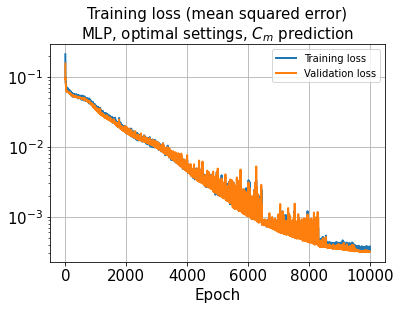

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

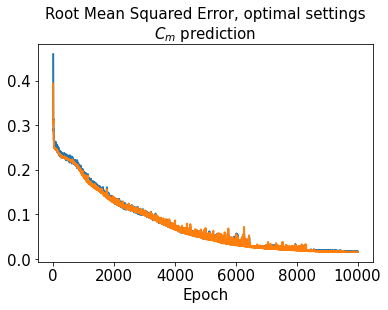

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

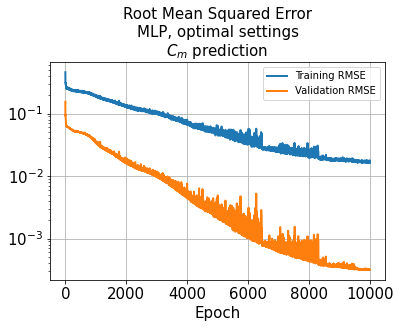

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate(x_train, y_train)

110/110 [==============================] - 0s 4ms/step - loss: 3.4612e-04 - rmse: 0.0169


In [37]:
val_results = model.evaluate(x_val, y_val)

32/32 [==============================] - 0s 4ms/step - loss: 3.1635e-04 - rmse: 0.0160


In [38]:
test_results = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 4ms/step - loss: 3.3004e-04 - rmse: 0.0164


In [39]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

16/16 [==============================] - 0s 2ms/step


In [40]:
decoded_train_

array([[0.10110714],
       [0.282345  ],
       [0.21197848],
       ...,
       [0.8874883 ],
       [0.13942078],
       [0.34448543]], dtype=float32)

In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [46]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [47]:
model_directory = "D:\\TrainedModels\\20221226"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221226unsteadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState100CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [48]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [51]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.04820707720215799
2.189989854615913


In [52]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.046853741122583864
2.1331095686916357


In [53]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.04541066849010648
2.1070724483980383


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

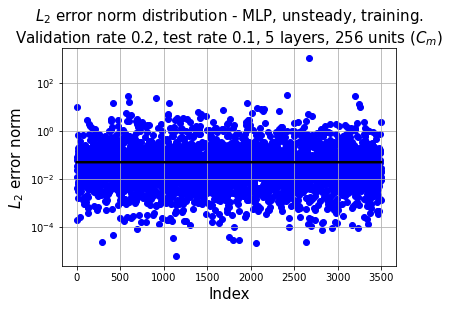

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

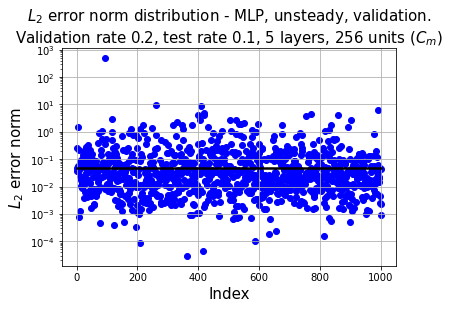

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

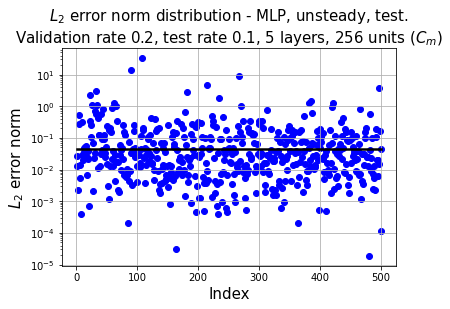

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

157/157 [==============================] - 0s 2ms/step


In [65]:
predicted.shape

(5000, 1)

In [66]:
t_train = t[index_train]
t_val = t[index_val]
t_test = t[index_test]

In [67]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
x += 10

In [70]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.0373


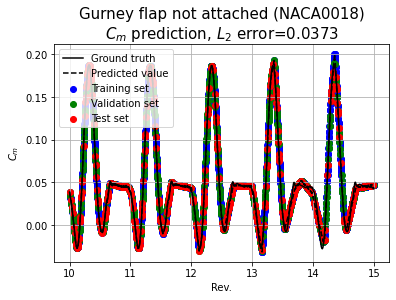

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0, 1):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted#[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain = np.array(iTrain)
    iVal = np.array(iVal)
    iTest = np.array(iTest)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

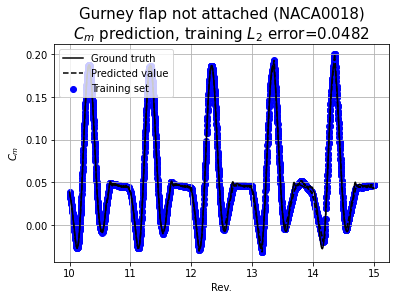

In [72]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, training $L_2$ error=%.4f' % l2_error_train
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

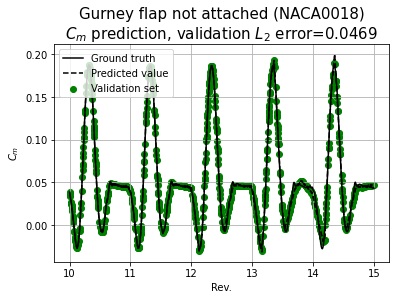

In [73]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, validation $L_2$ error=%.4f' % l2_error_val
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

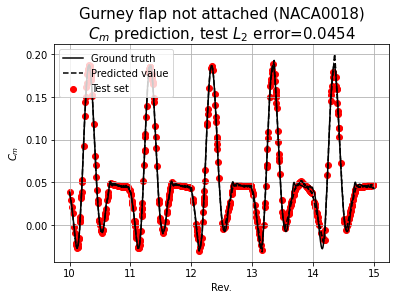

In [74]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, test $L_2$ error=%.4f' % l2_error_test
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()